# Analytics - Product Quality

#### Date: 2023/06

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2023/01
##### Professor: Hilmer Neri

##### Members:

- Member Adrian Soares Lopes
- Member Ana Carolina Rodrigues Leite
- Member Carlos Eduardo de Sousa Fiuza
- Member Davi Matheus da Rocha de Oliveira
- Member Edvan Barreira Gomes Júnio
- Member Giulia Lobo Barros
- Member Guilherme Verissimo Cerveira Braz
- Member Igor Queiroz Lima
- Member Jonathan Jorge Barbosa Oliveira
- Member Liverson Paulo Furtado Severo
- Member Luis Gustavo Ferreira Marques
- Member Marcos Gabriel Tavares
- Member Murilo Gomes de Souza
- Member Paulo Batista


### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [4]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2023-1-MeasureSoftGram-'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'Service': 'py',
    'CLI': 'py',
    'Front': 'ts',
    'Core': 'py',
    'Action': 'ts',
    'Parser': 'py'
}

### SonarCloud
##### Path to the folder with all your jsons

In [5]:
# Maybe you should change this path to your own path
import os
import re

sonar_files = glob('../analytics-raw-data/*.json')
sonar_files = [file for file in sonar_files if "Helper-Action" not in file and "/test.json" not in file]

for file in sonar_files:
    wrong_date = re.findall(r"[a-z]-(\d+-\d+-\d+-\d+-\d+)-[a-z]", file)
    if len(wrong_date) > 0:
        print(re.sub(r"(\d+-\d+-\d+-\d+-\d+)", wrong_date[0][3:5] + wrong_date[0][2:3] + wrong_date[0][:2] + wrong_date[0][5:] + "-01", file))
        os.rename(file, re.sub(r"(\d+-\d+-\d+-\d+-\d+)", wrong_date[0][3:5] + wrong_date[0][2:3] + wrong_date[0][:2] + wrong_date[0][5:] + "-01", file))

sonar_files = glob('../analytics-raw-data/*.json')
sonar_files = [file for file in sonar_files if "Helper-Action" not in file and "/test.json" not in file]

## Create DataFrame

#### Unmarshall json

In [6]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [7]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [8]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [9]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [10]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [11]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)

        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[base_name.split("-")[6]])


        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)
        
    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [12]:
file_component_df = create_component_df(sonar_files)
file_component_df = file_component_df[~file_component_df.path.str.contains("__init__") & ~file_component_df.path.str.contains("staticfiles")]
file_component_df.repository.unique()

array(['fga-eps-mds-2023-1-MeasureSoftGram-Action',
       'fga-eps-mds-2023-1-MeasureSoftGram-CLI',
       'fga-eps-mds-2023-1-MeasureSoftGram-Core',
       'fga-eps-mds-2023-1-MeasureSoftGram-Front',
       'fga-eps-mds-2023-1-MeasureSoftGram-Parser',
       'fga-eps-mds-2023-1-MeasureSoftGram-Service'], dtype=object)

### Create dataframe per repository

In [13]:
repos_dataframes = []

for repo in repos_language.keys():
    dataframe = file_component_df[file_component_df['repository'] == repo_name+repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Measure calculations according to Q-Rapids quality model

In [14]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [15]:
def m1(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [16]:
def m2(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [17]:
def m3(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [18]:
def m4(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [19]:
def m5(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [20]:
def m6(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [21]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(m1(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(m2(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(m3(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(m4(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(m5(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(m6(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'm1': m1_list,
        'm2': m2_list,
        'm3': m3_list,
        'm4': m4_list,
        'm5': m5_list,
        'm6': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [22]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

## Data visualization

In this area you will need to plot the metrics of each repository.

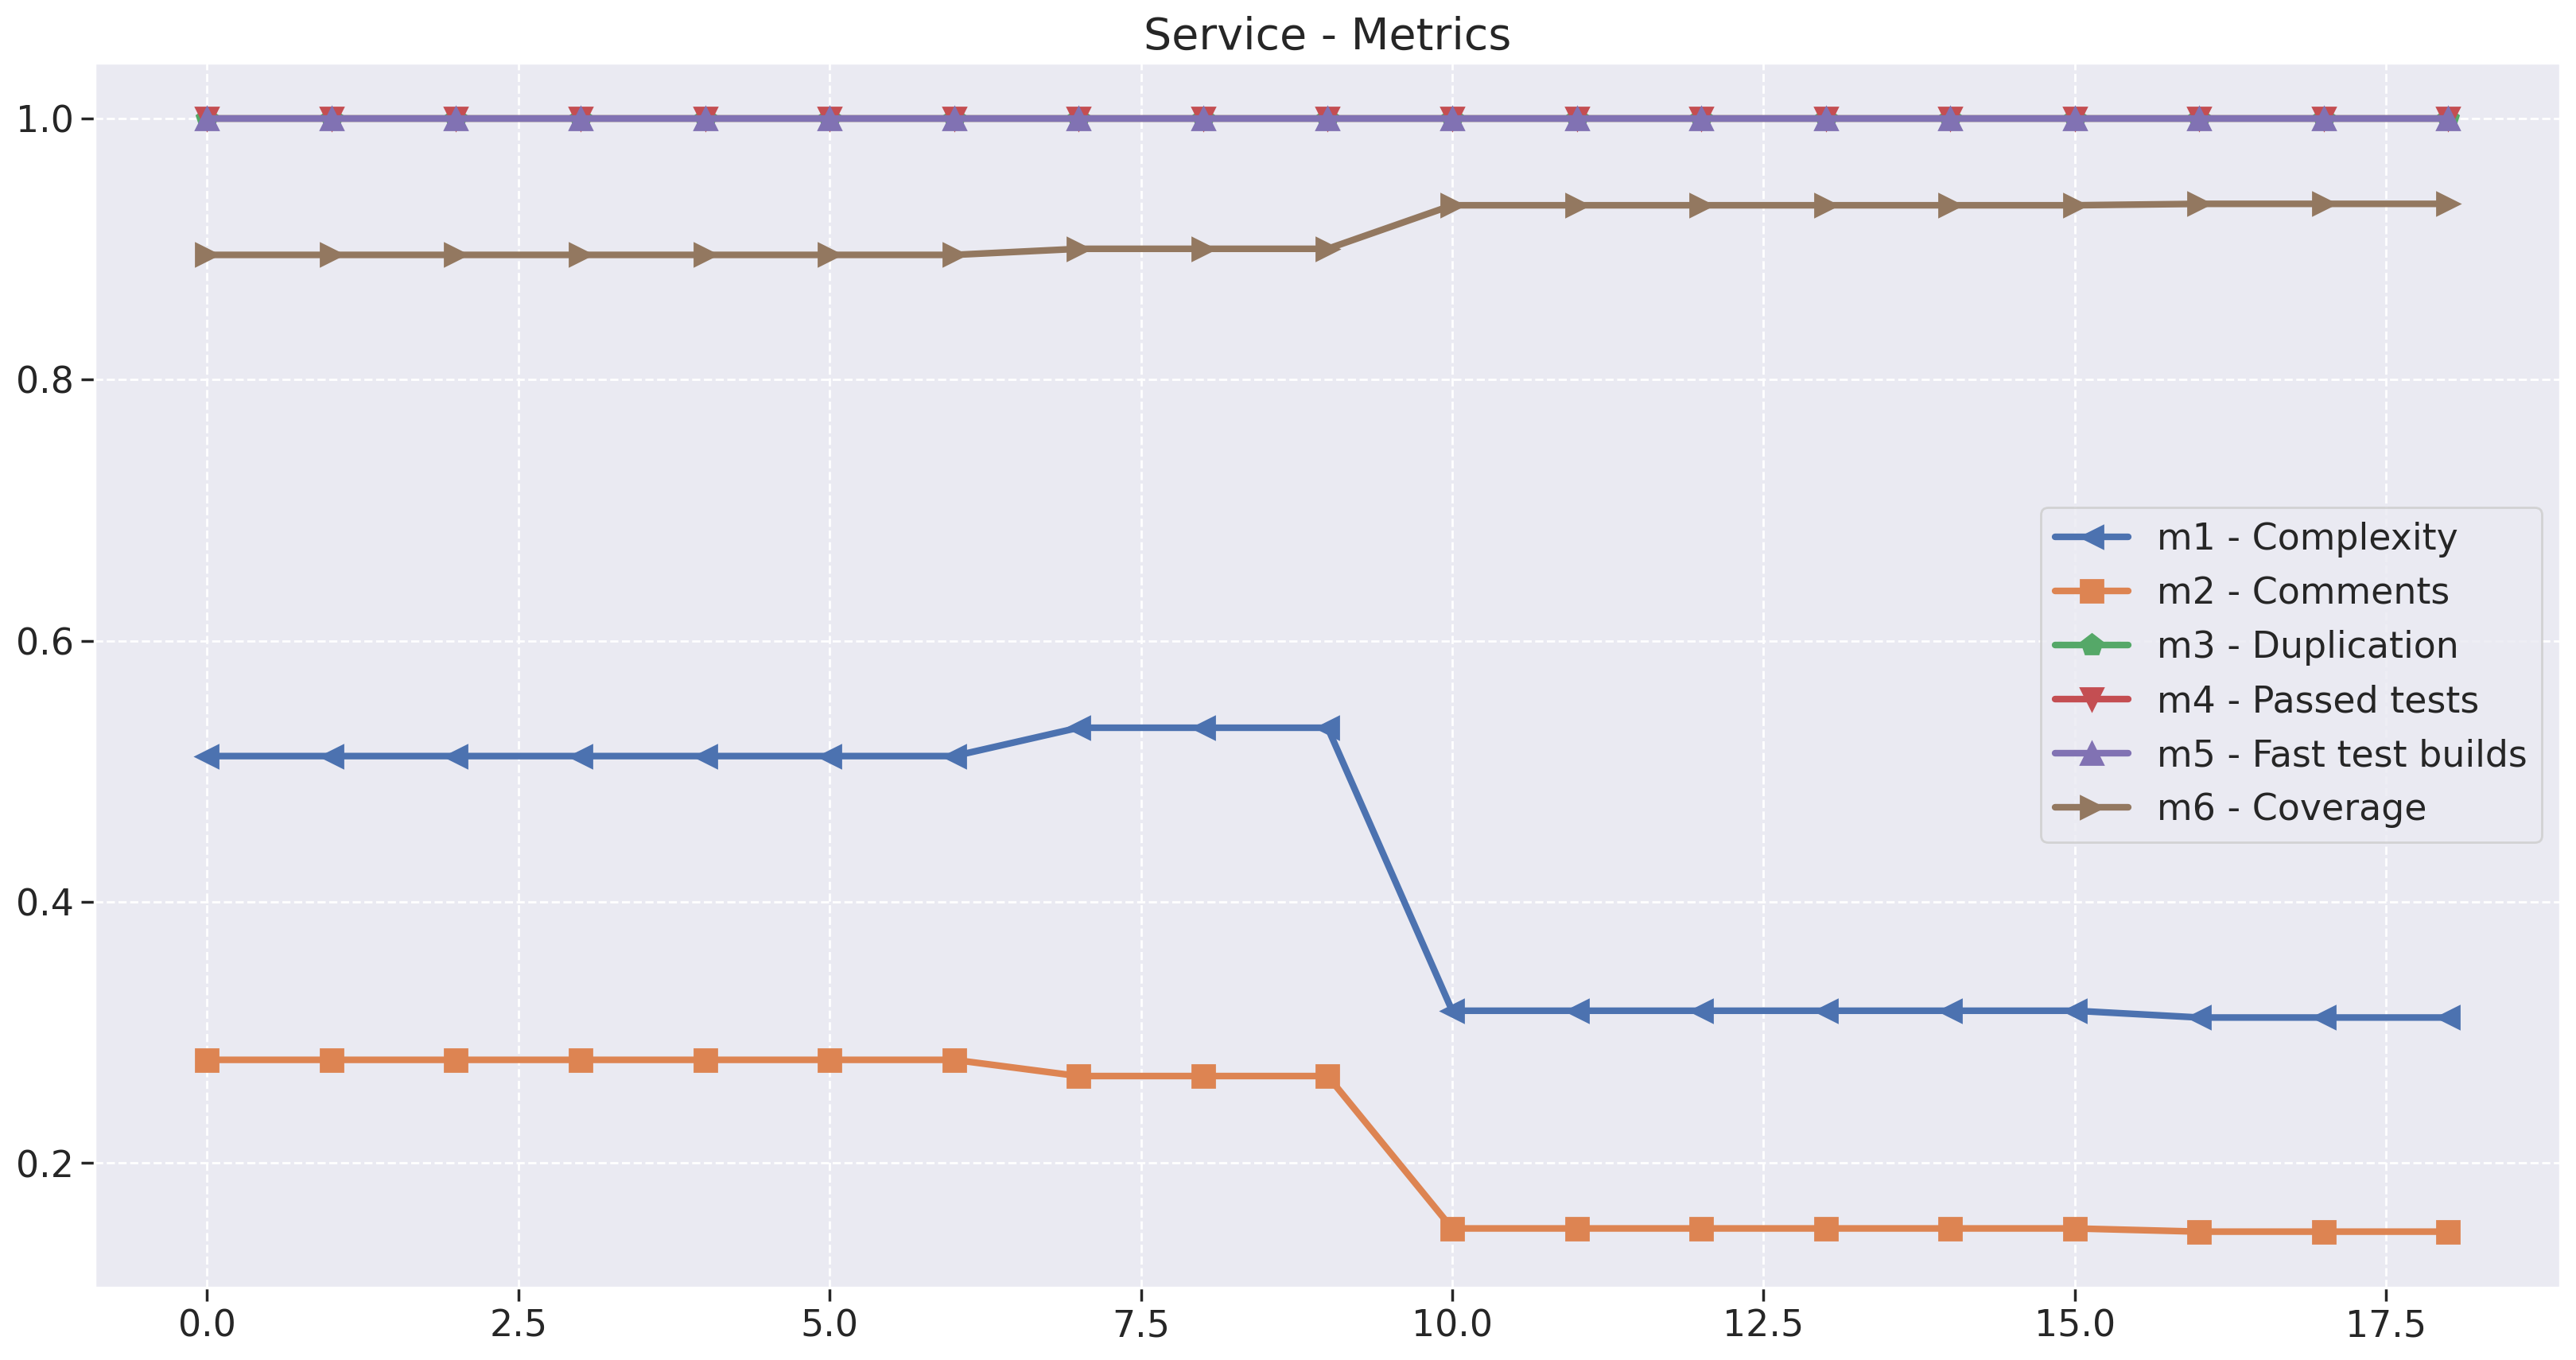

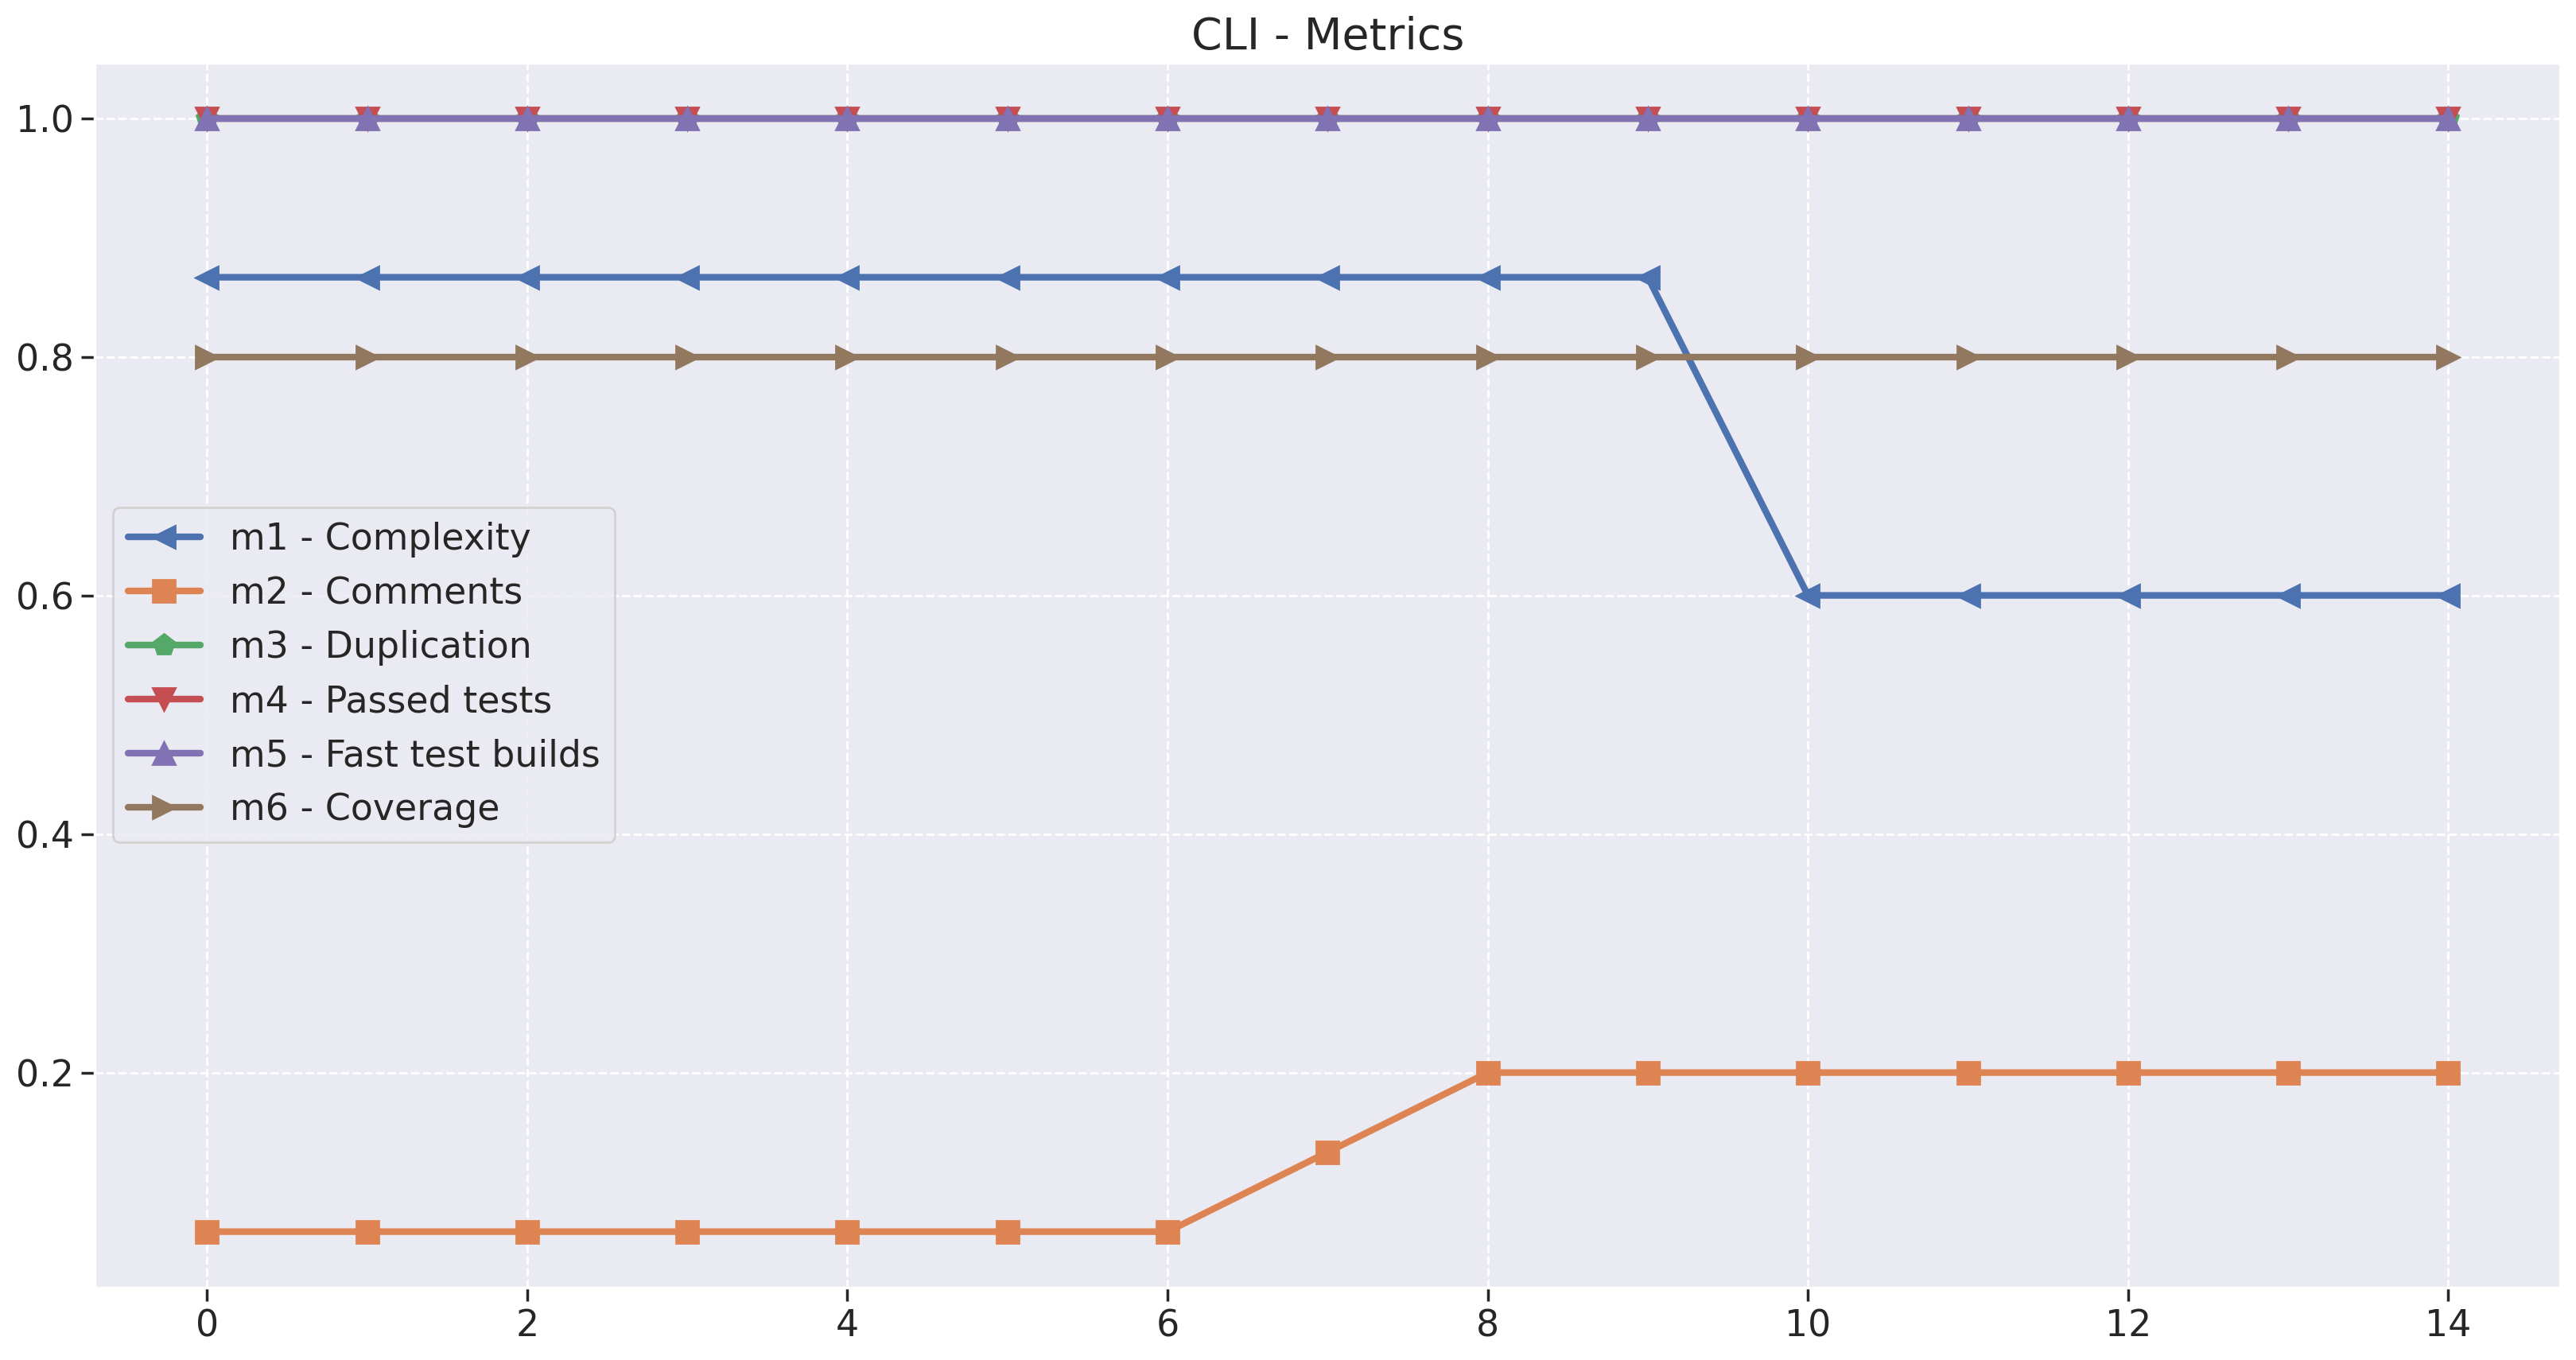

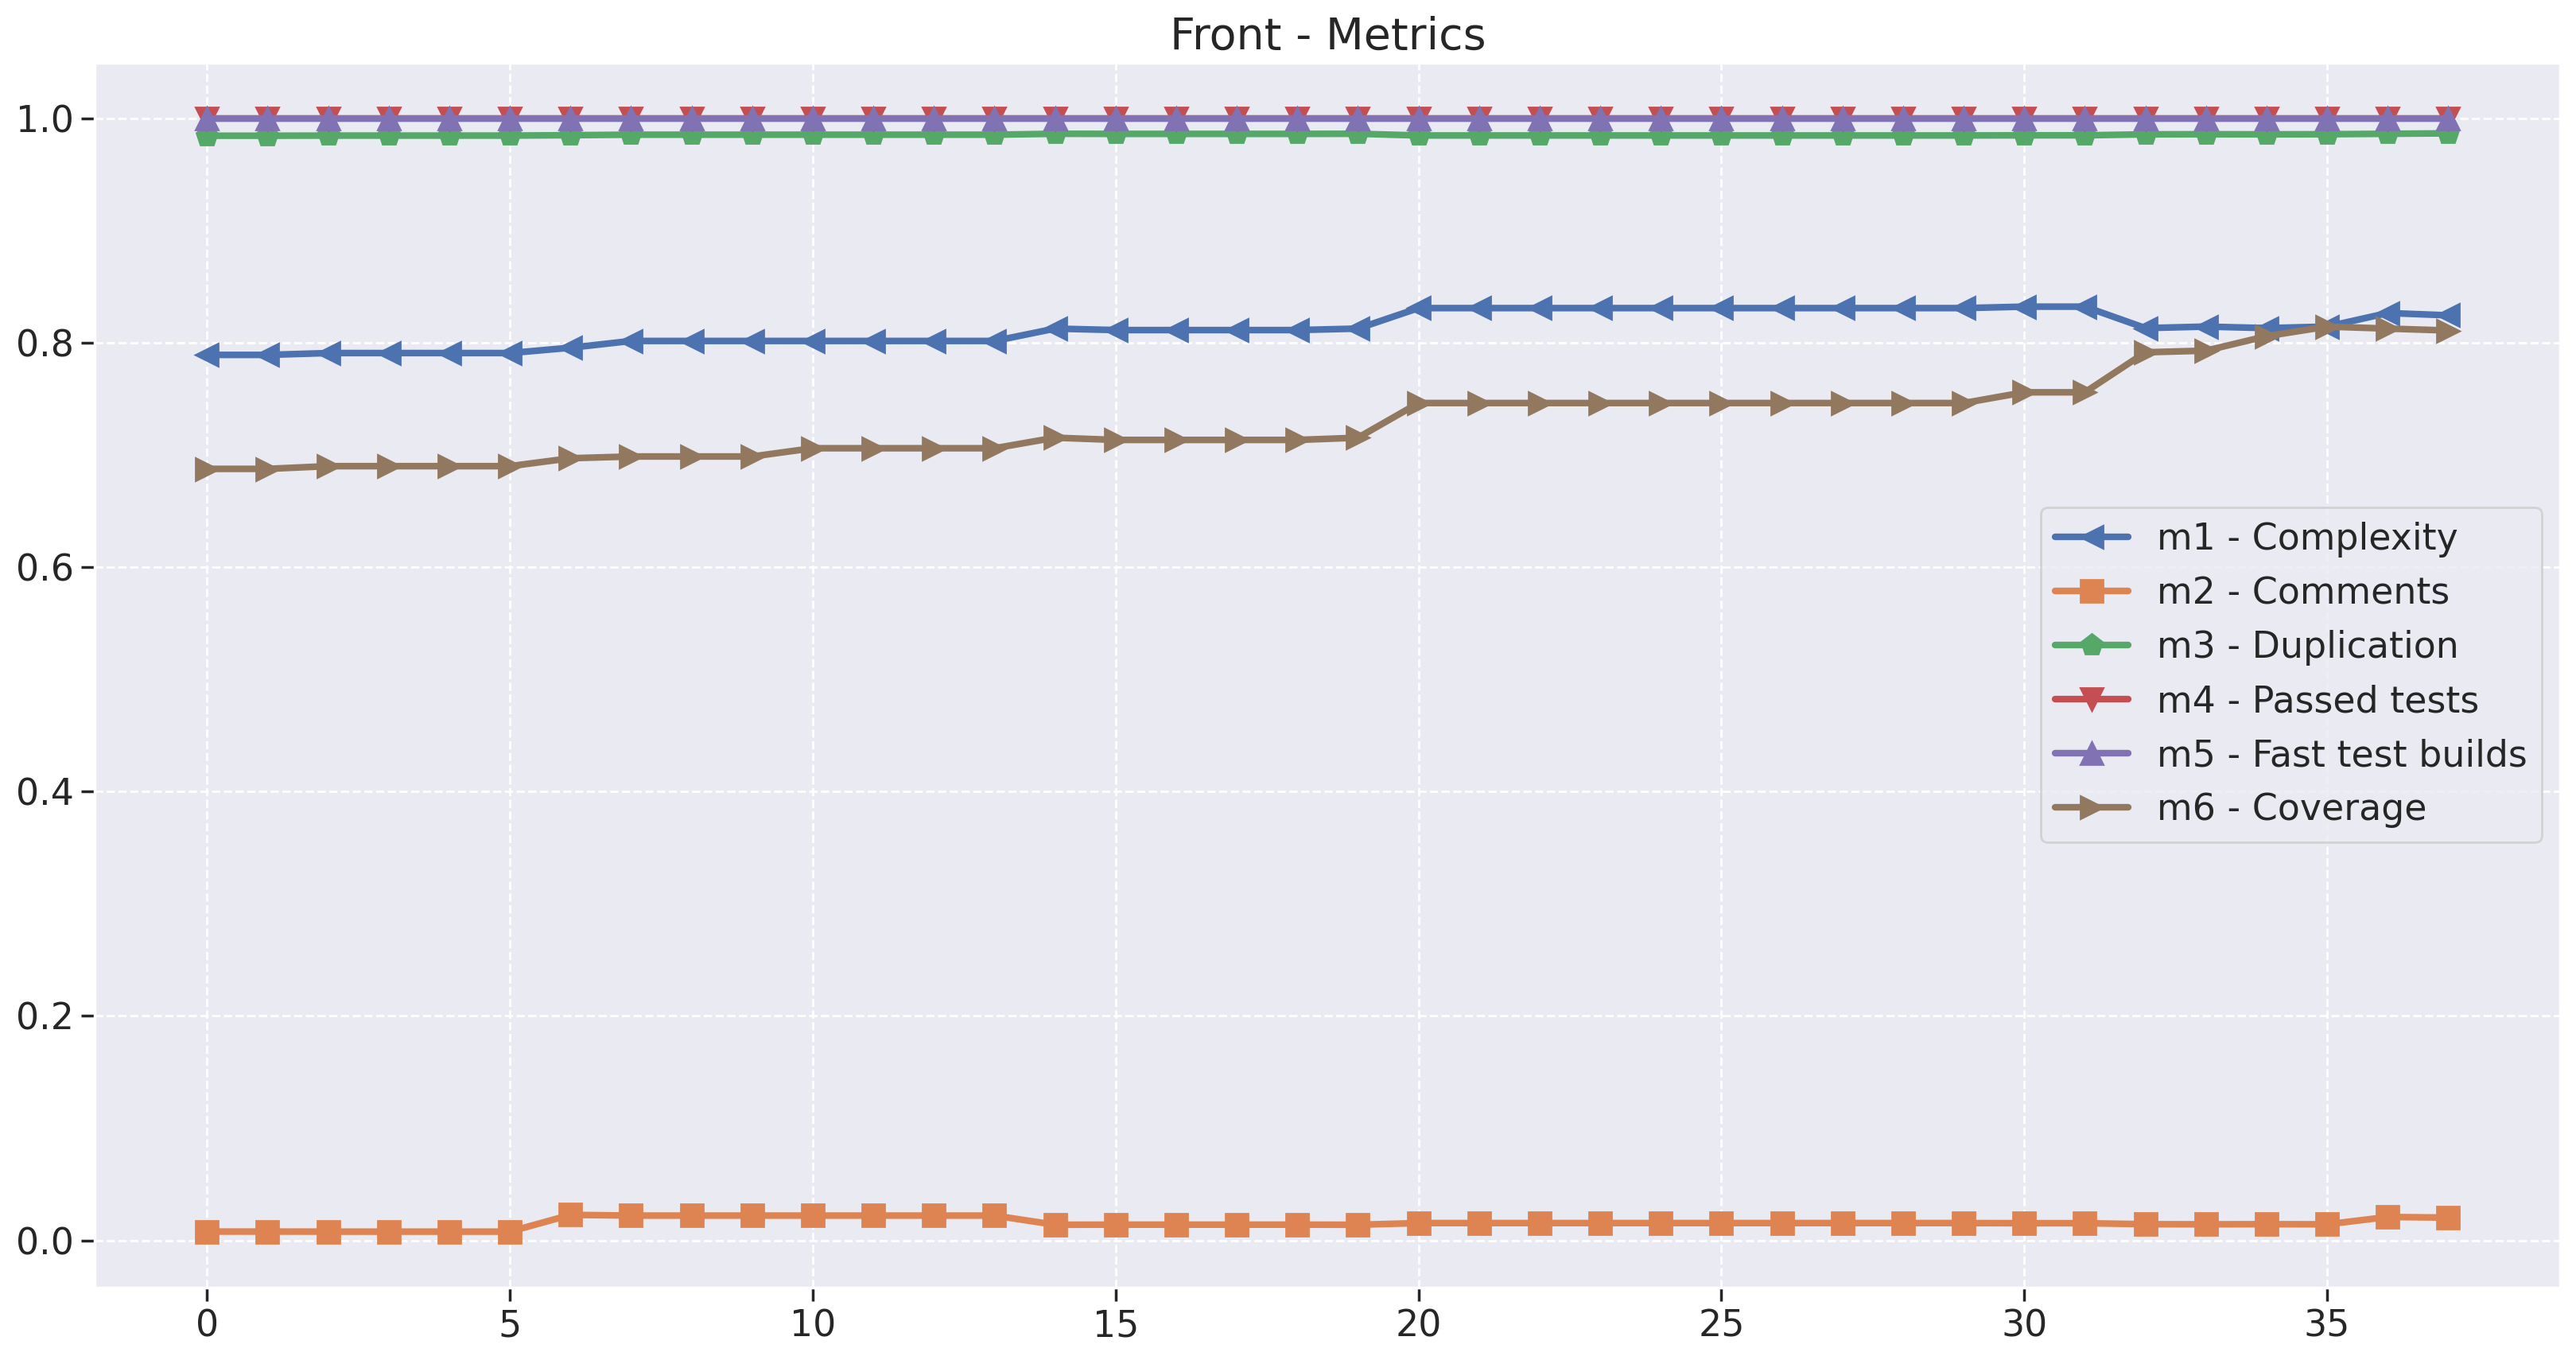

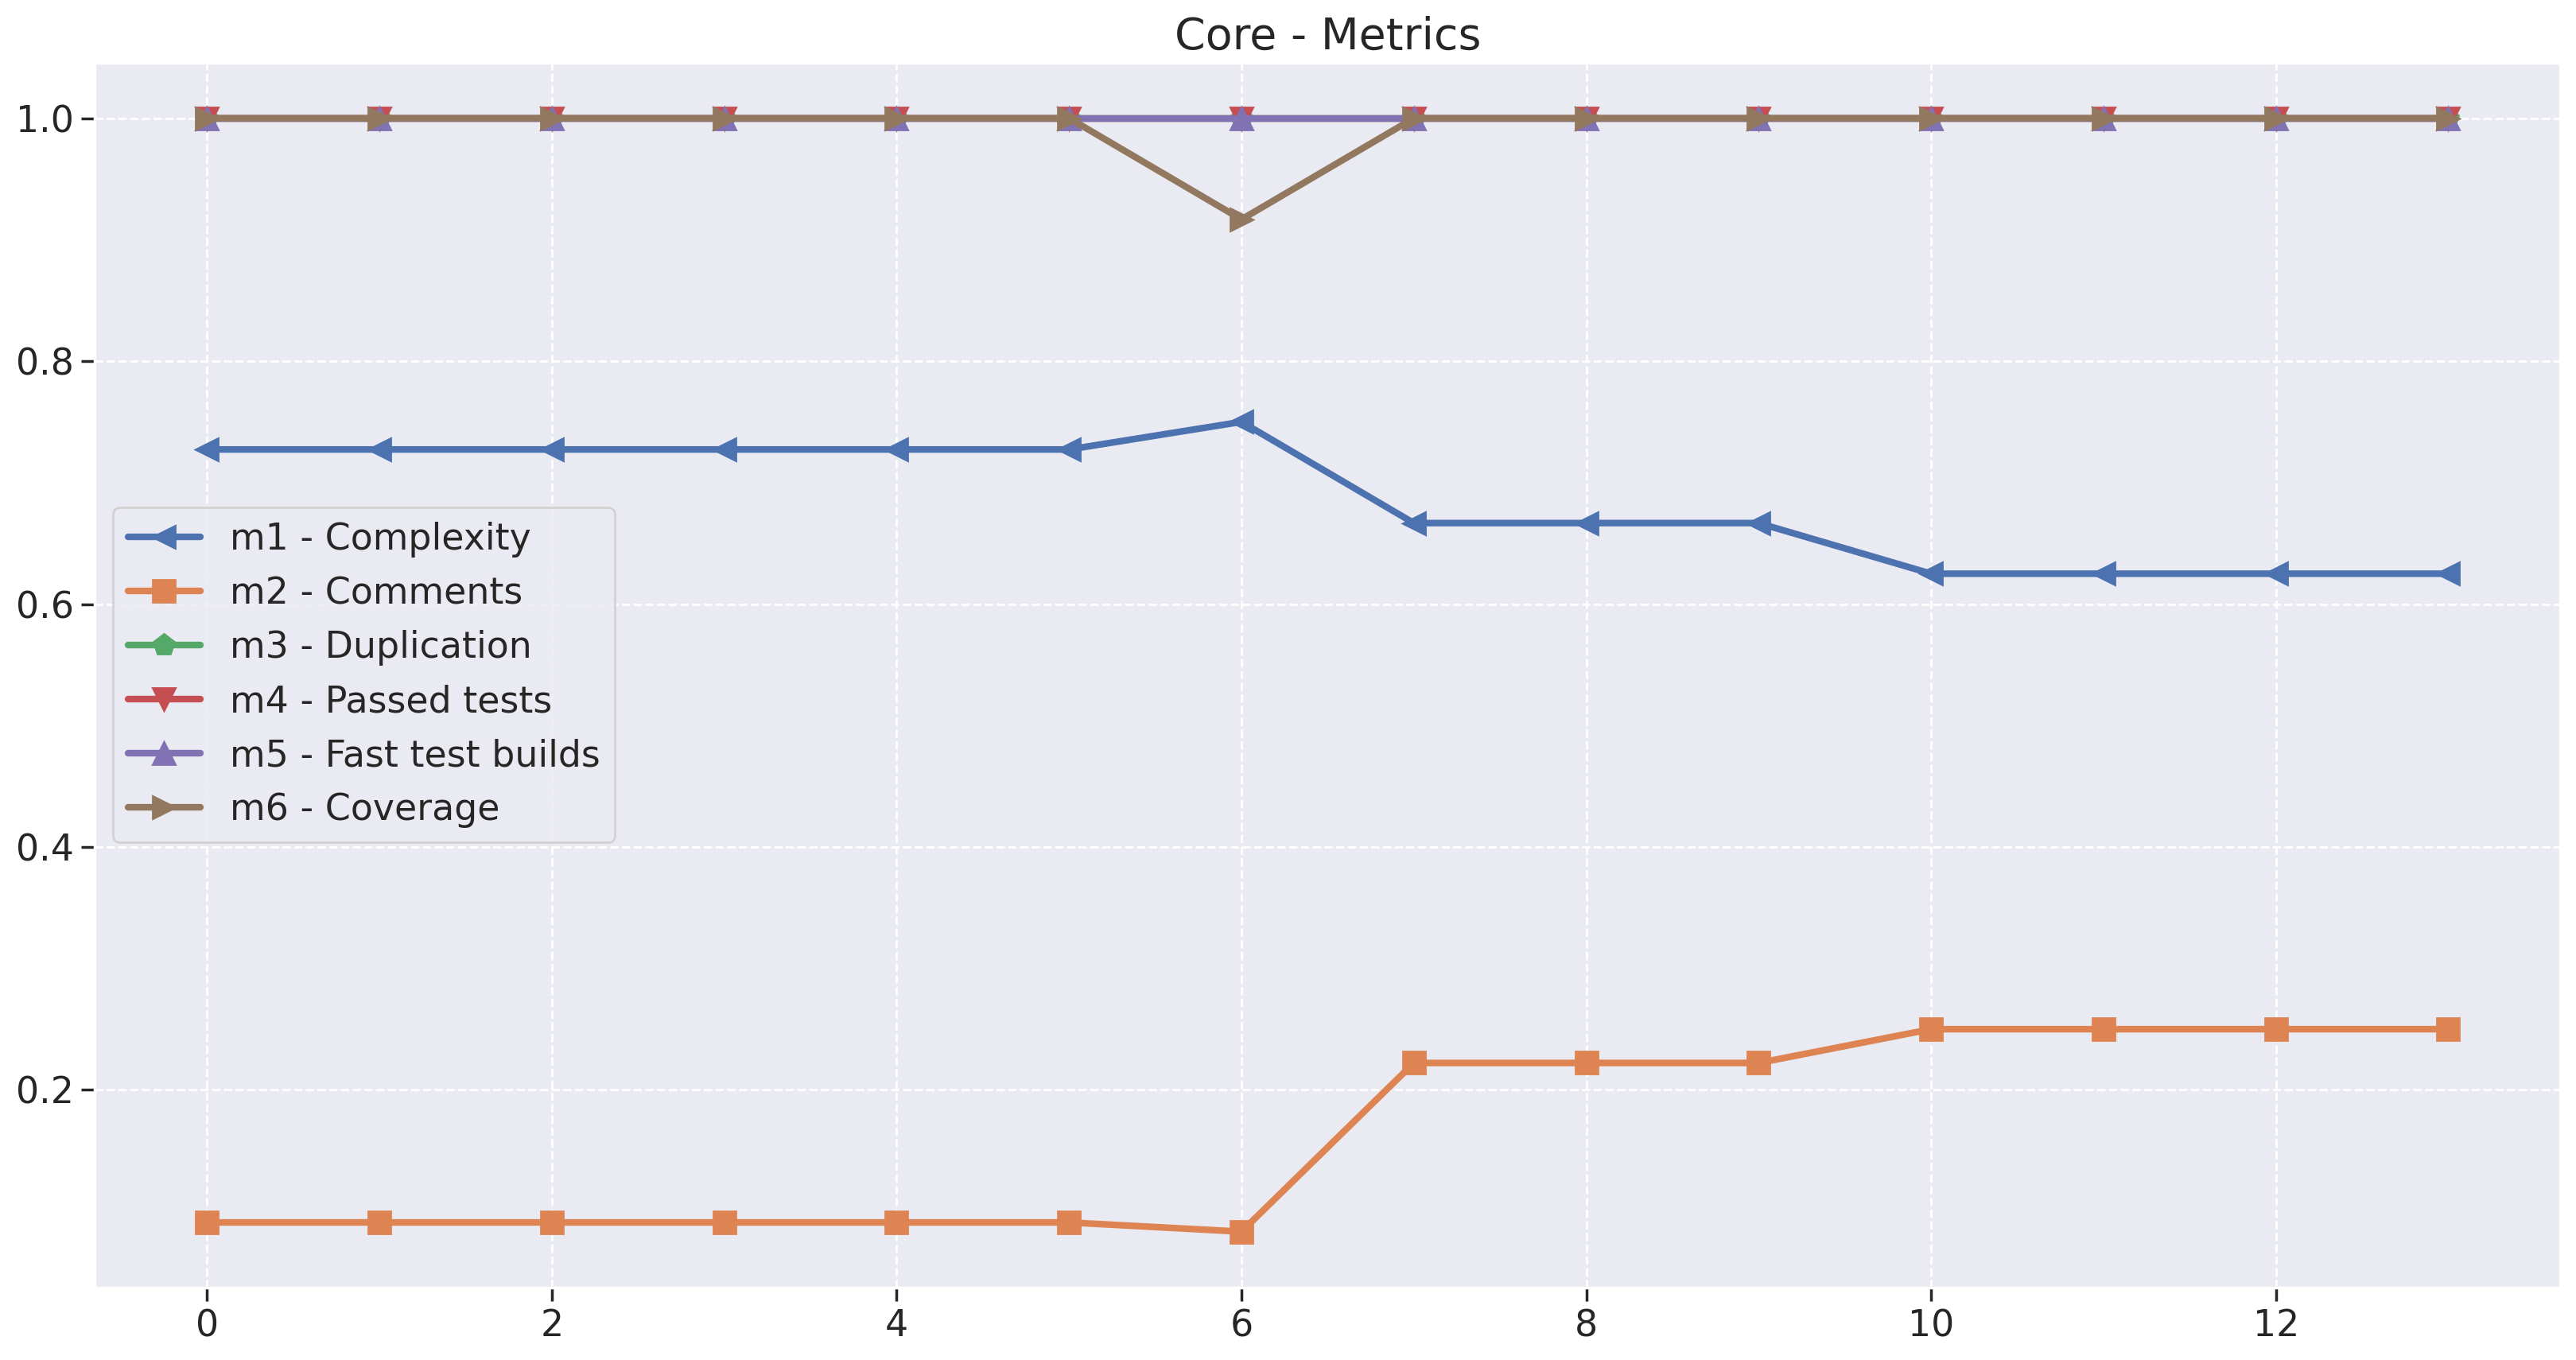

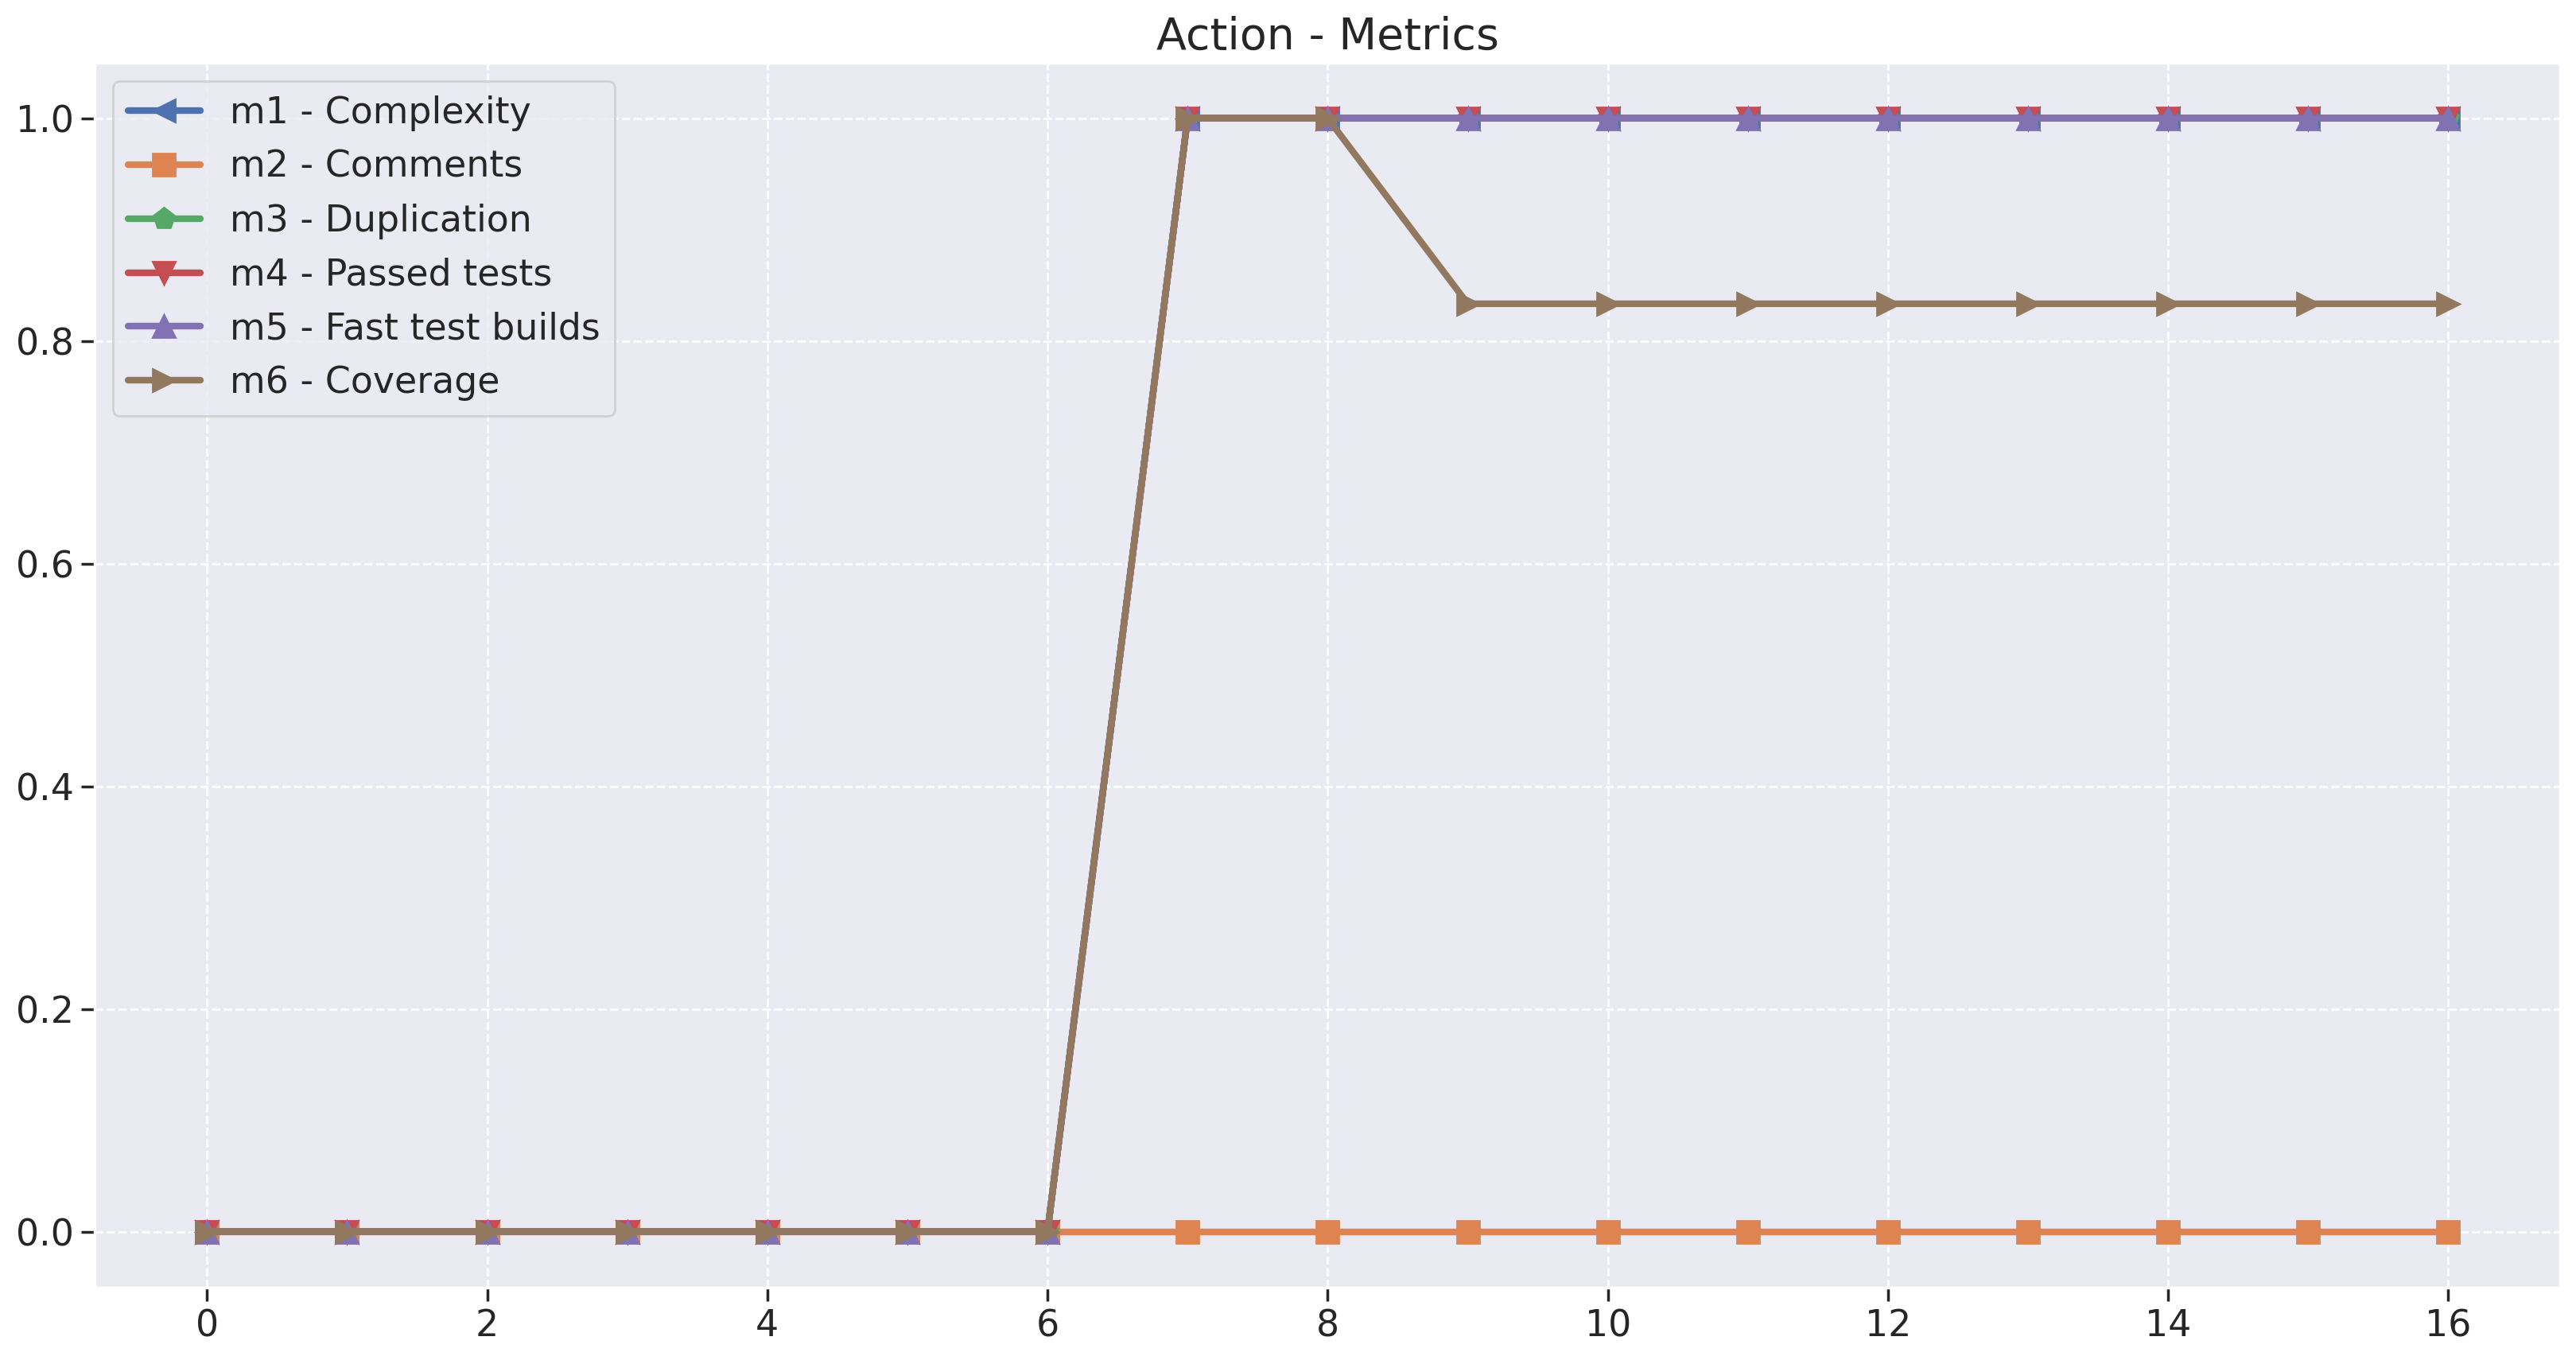

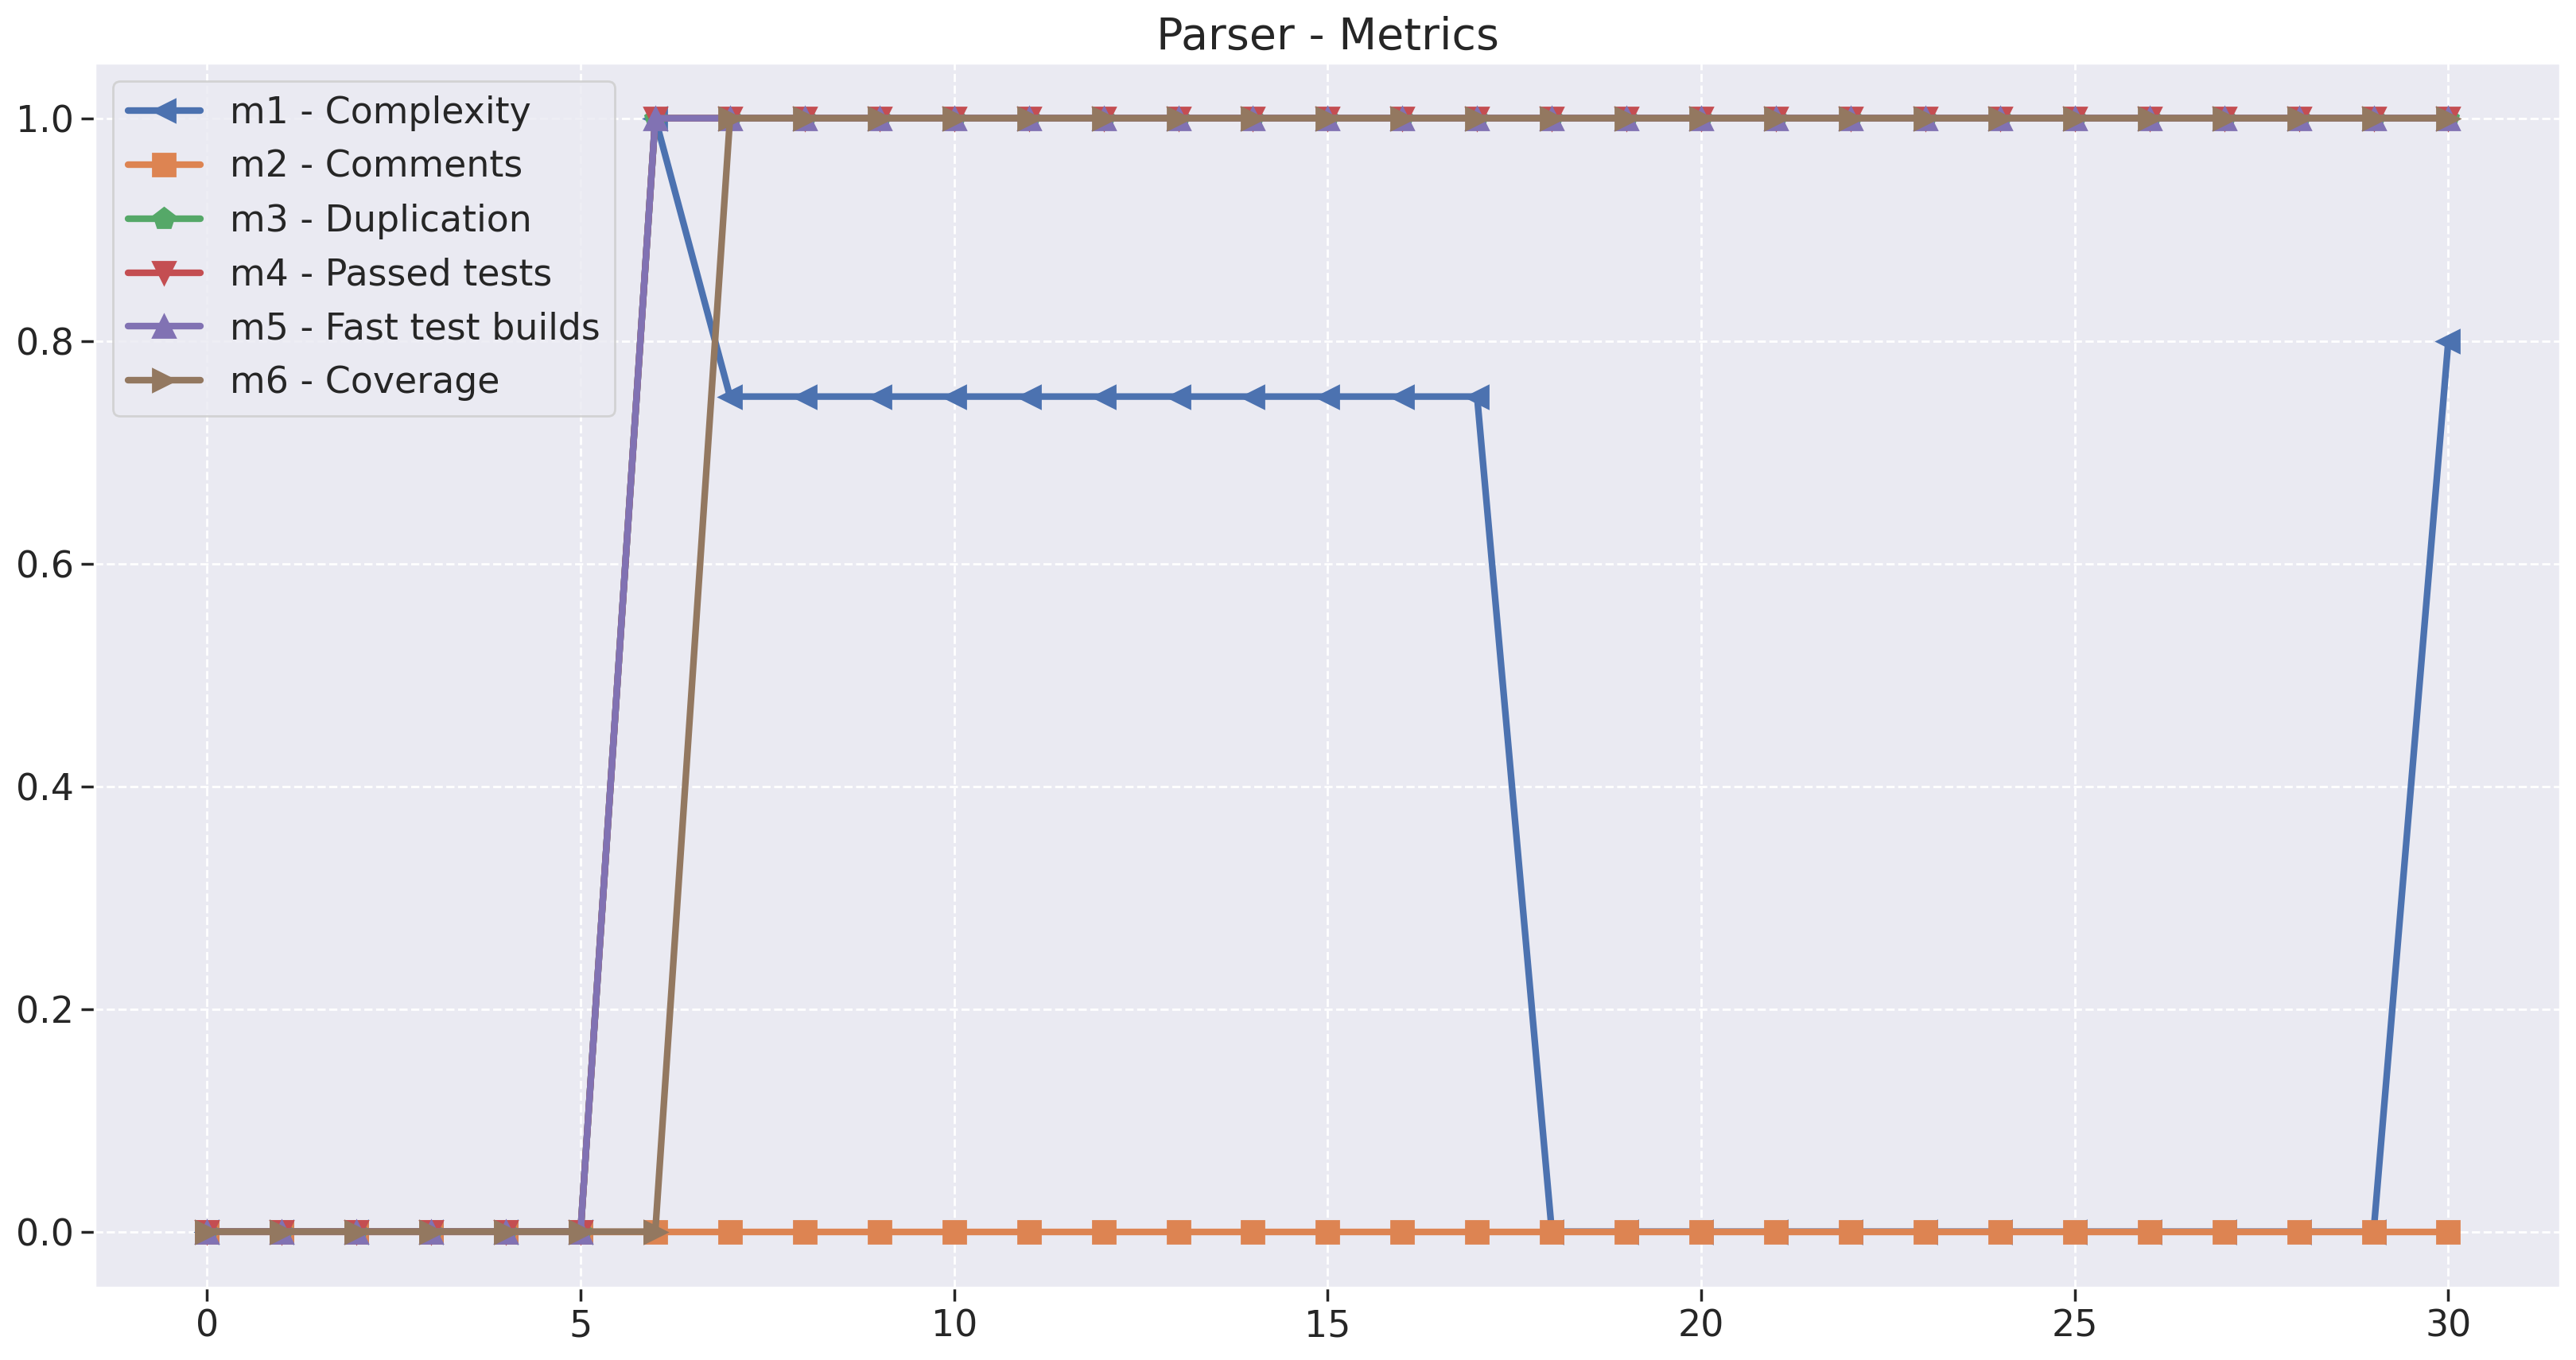

In [23]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['m1'], linewidth=3, marker='<', markersize=10, label="m1 - Complexity")
    plt.plot(data['m2'], linewidth=3, marker='s', markersize=10, label="m2 - Comments")
    plt.plot(data['m3'], linewidth=3, marker='p', markersize=10, label="m3 - Duplication")
    plt.plot(data['m4'], linewidth=3, marker='v', markersize=10, label="m4 - Passed tests")
    plt.plot(data['m5'], linewidth=3, marker='^', markersize=10, label="m5 - Fast test builds")
    plt.plot(data['m6'], linewidth=3, marker='>', markersize=10, label="m6 - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [24]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['m1']*pm1) + (data['m2']*pm2) + (data['m3']*pm3)) * psc1
    data['testing_status'] = ((data['m4']*pm4) + (data['m5']*pm5) + (data['m6']*pm6)) * psc2

### Code Quality visualization

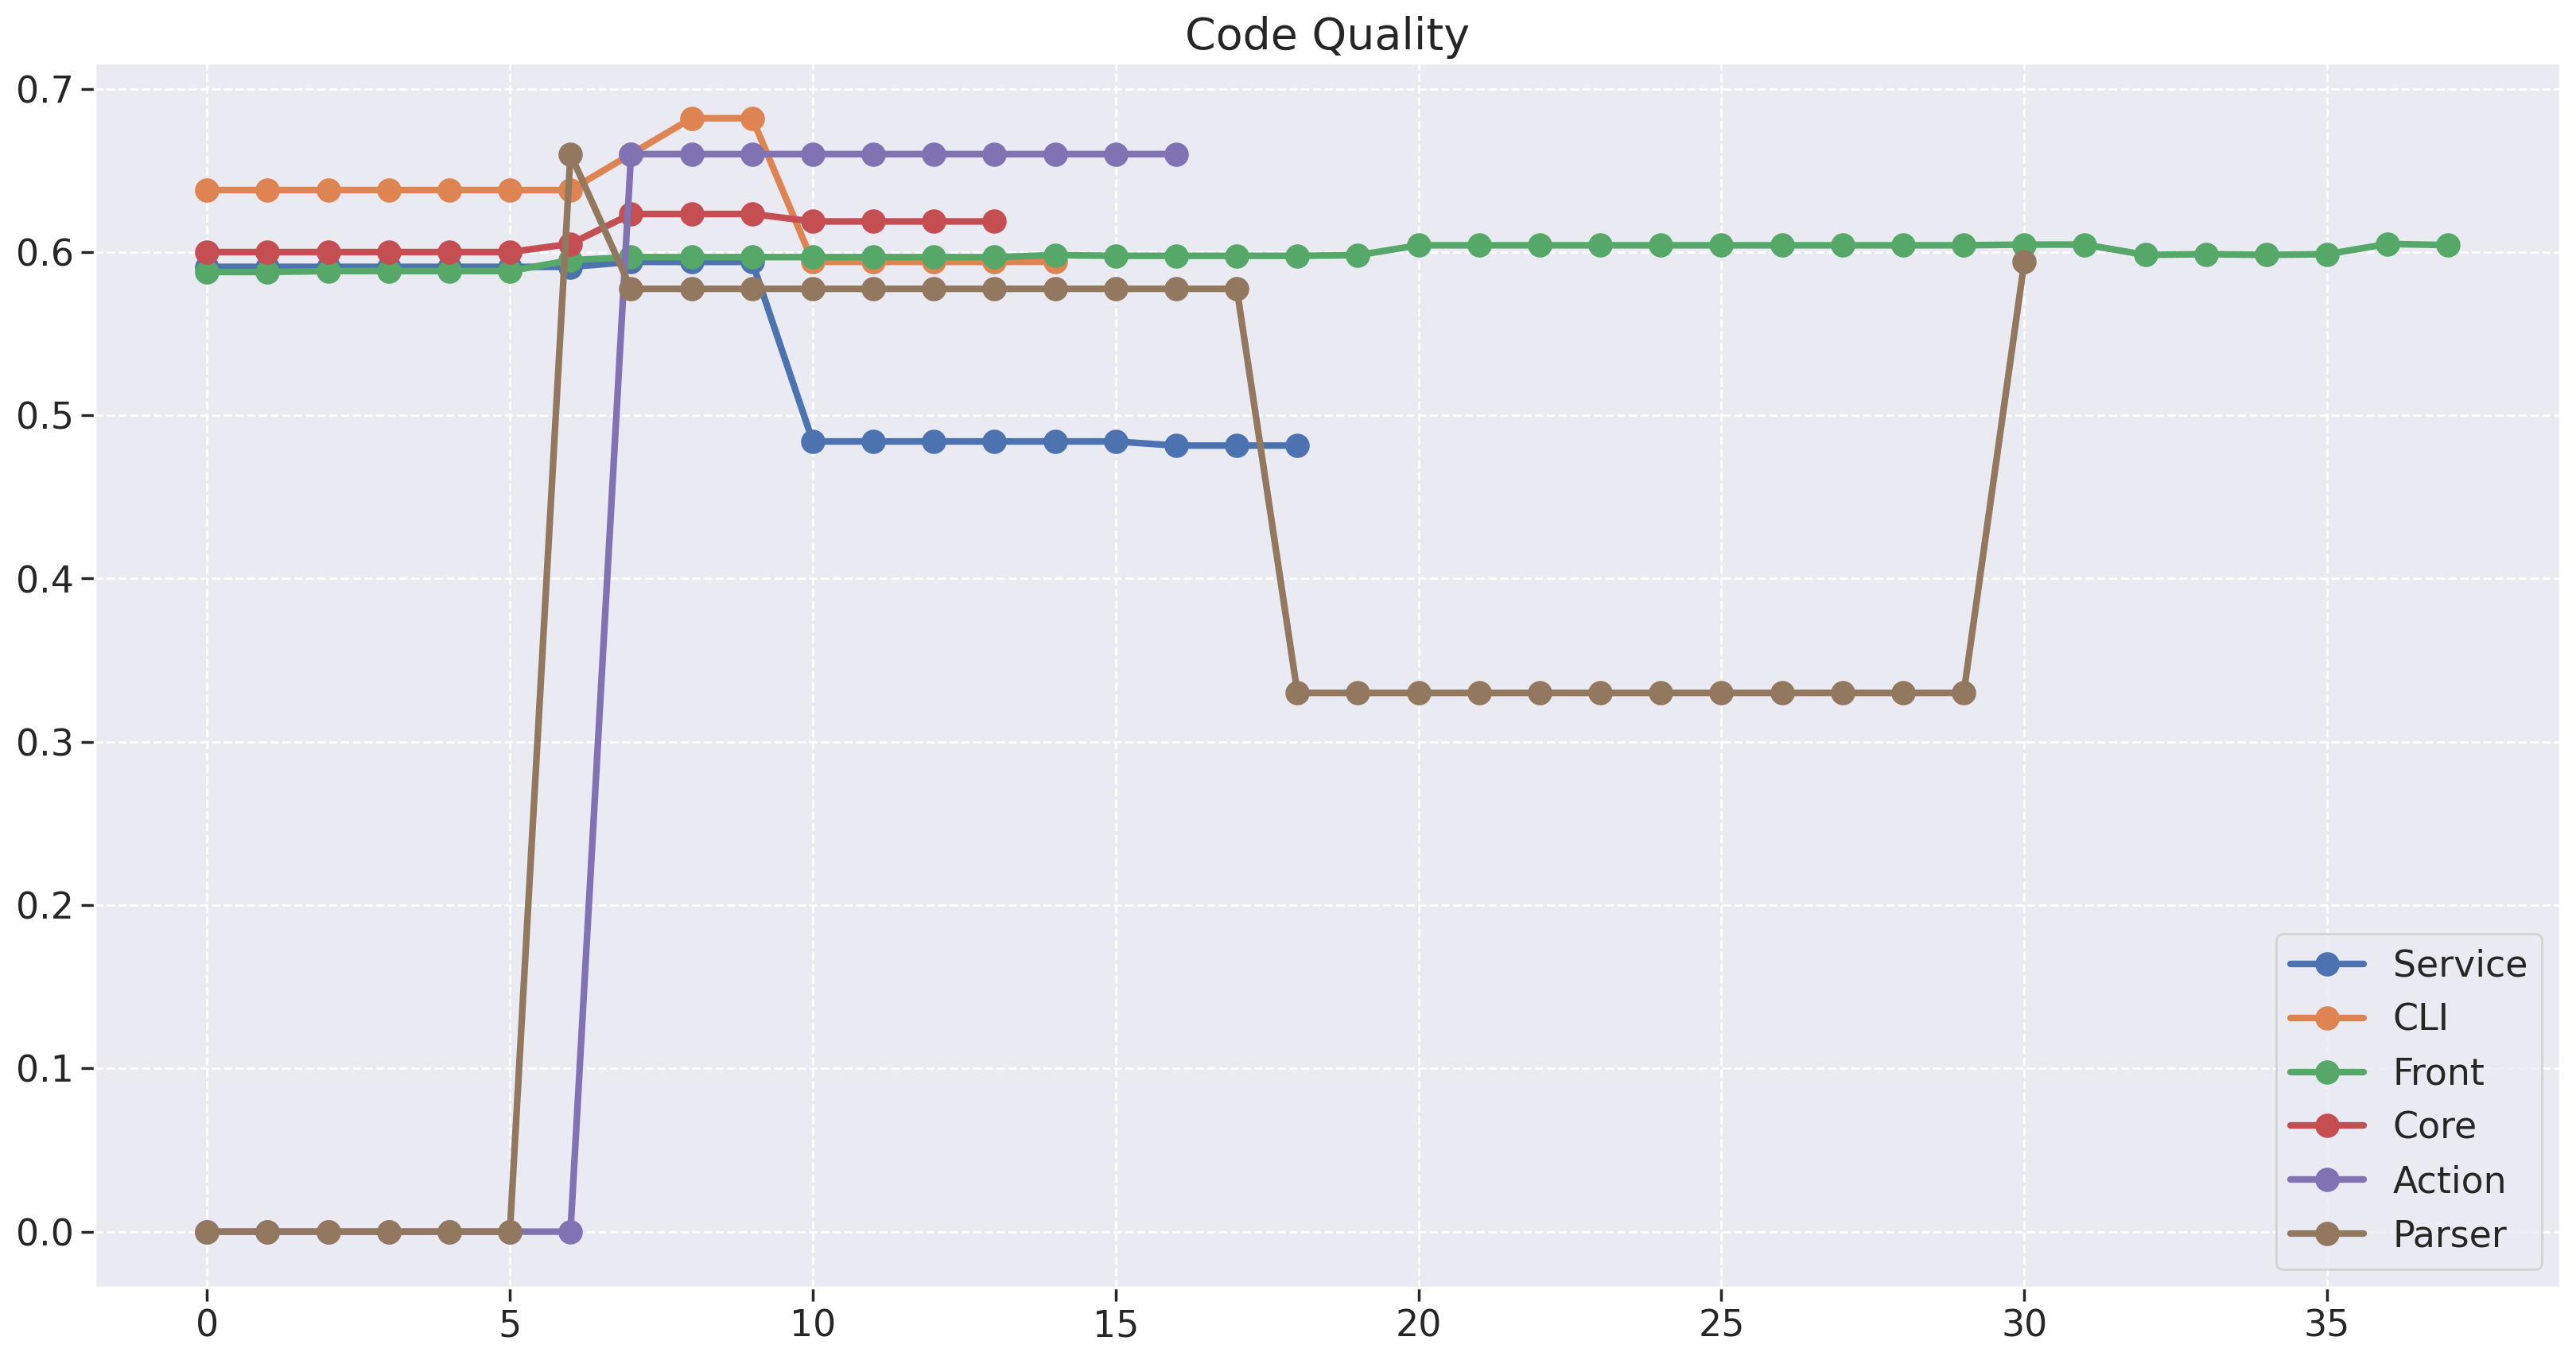

In [25]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

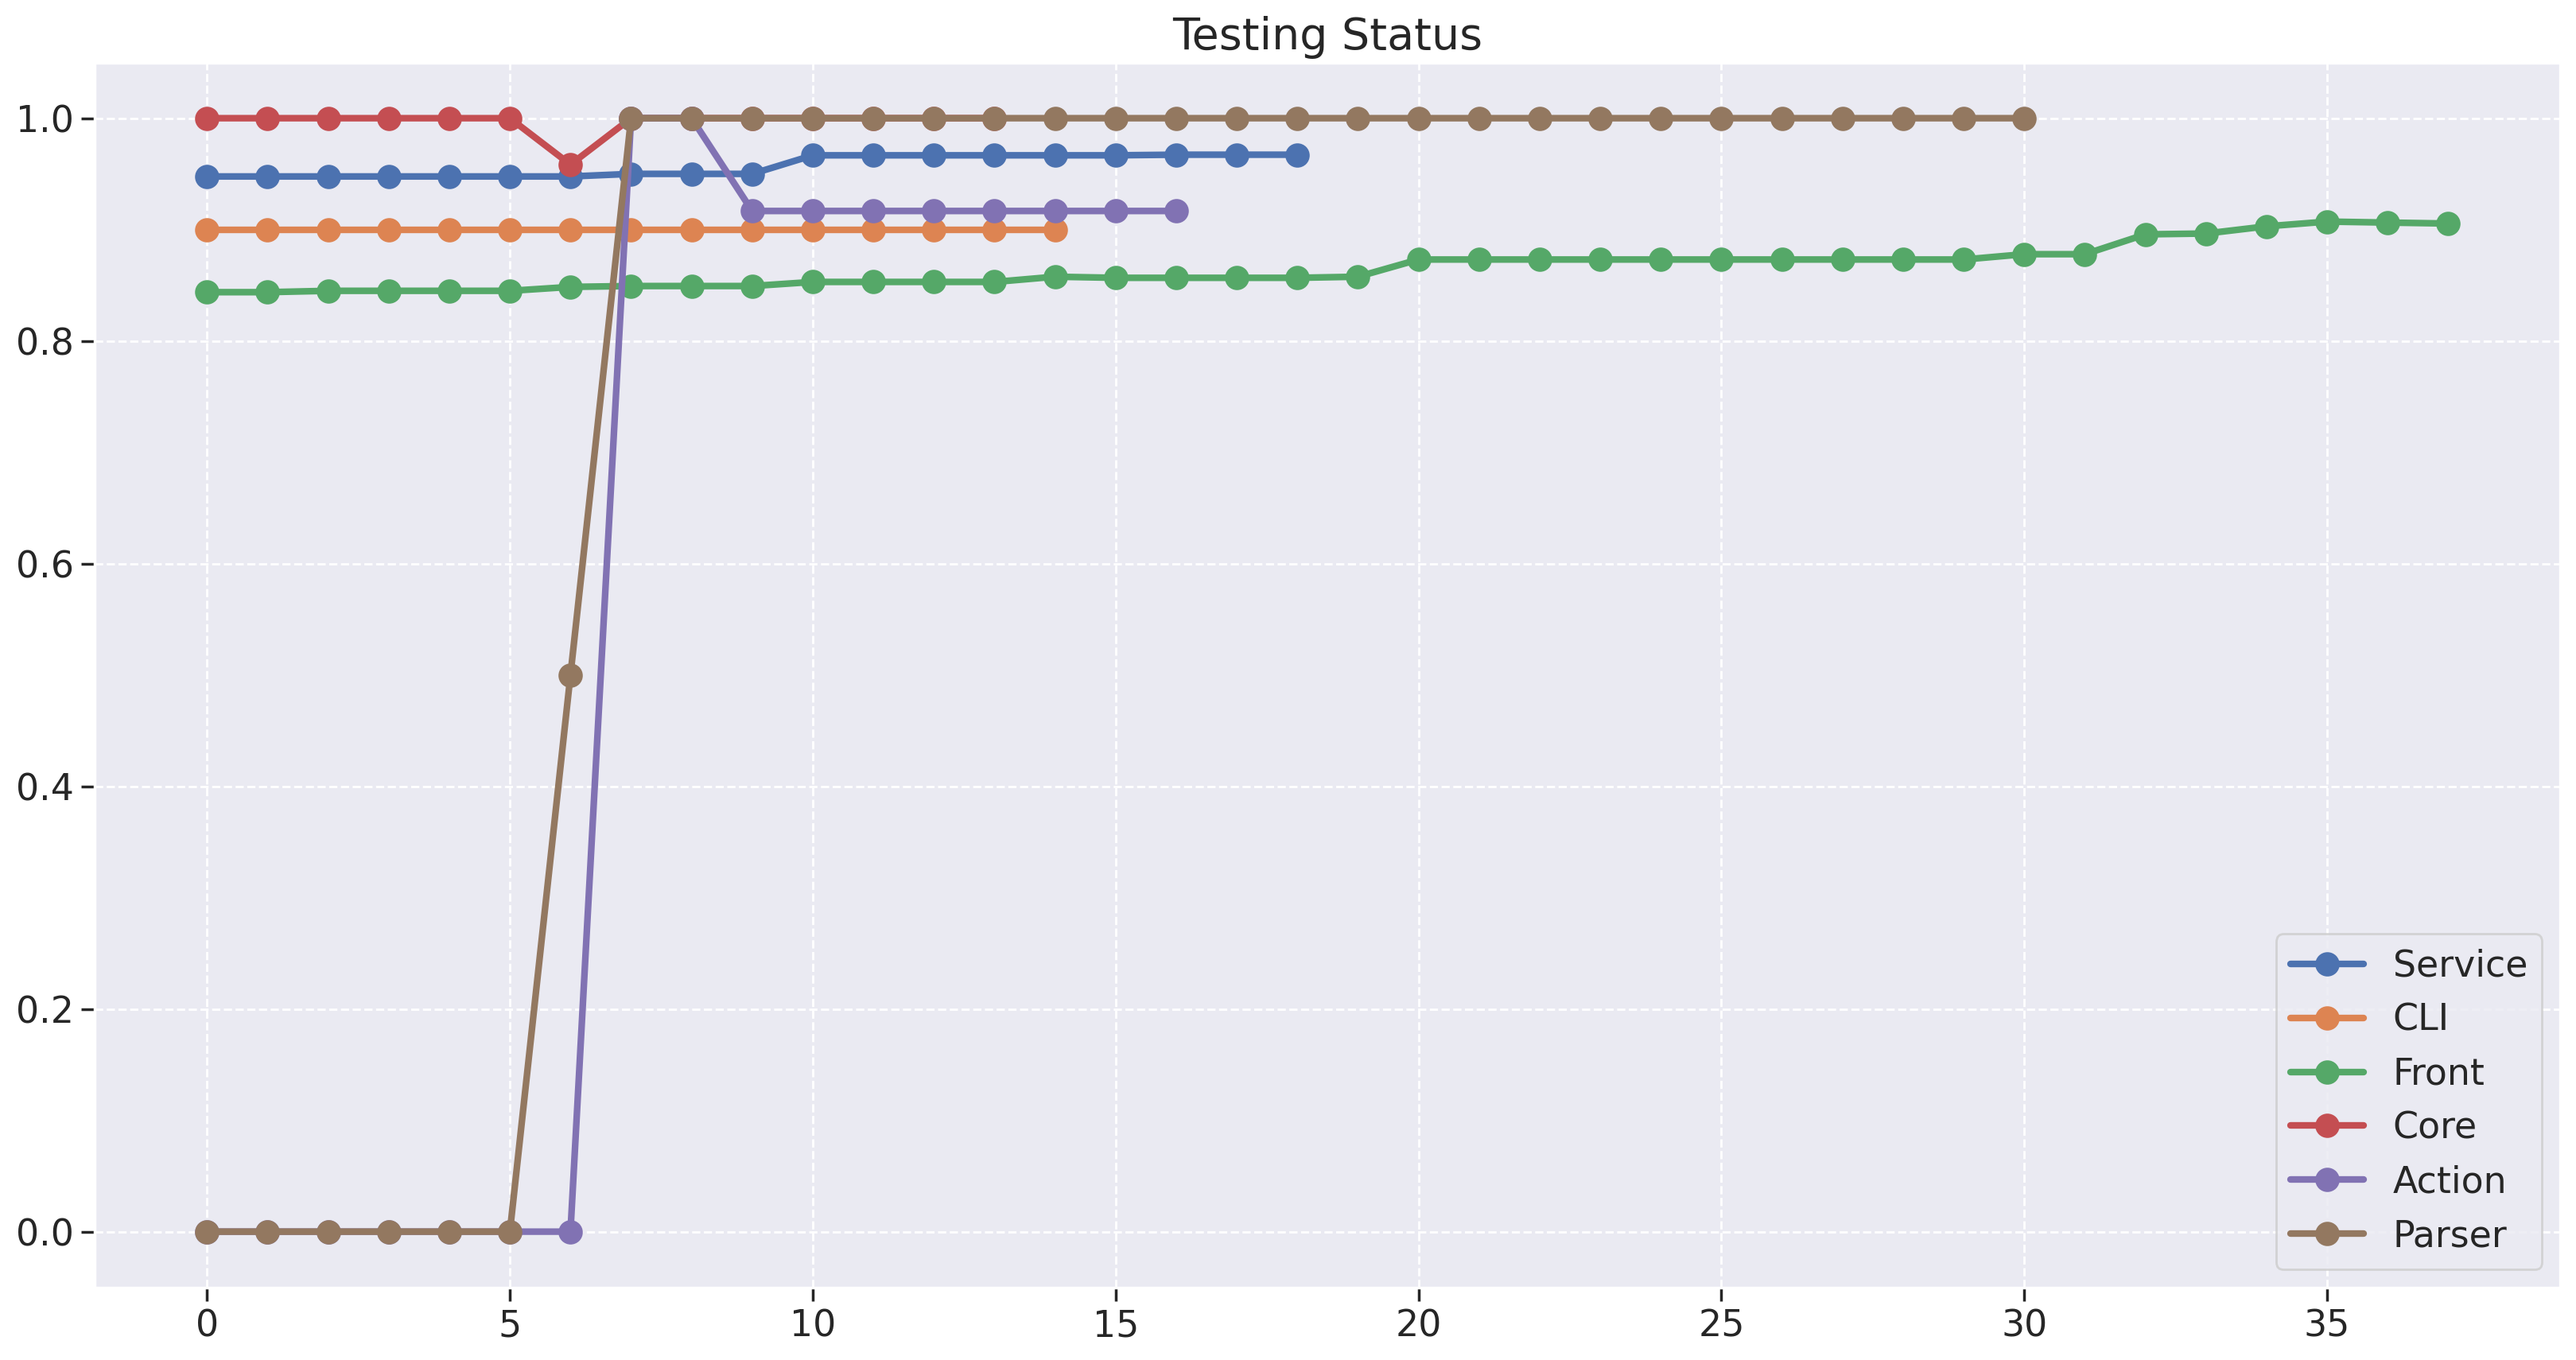

In [26]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [27]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [28]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [29]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

Service
Maintainability Stats
    mean     mode   median      std      var      min   max
0.270183 0.295465 0.295465 0.027887 0.000778 0.240738 0.297
Reliability Stats
    mean     mode  median      std      var      min      max
0.478562 0.473837   0.475 0.004757 0.000023 0.473837 0.483607


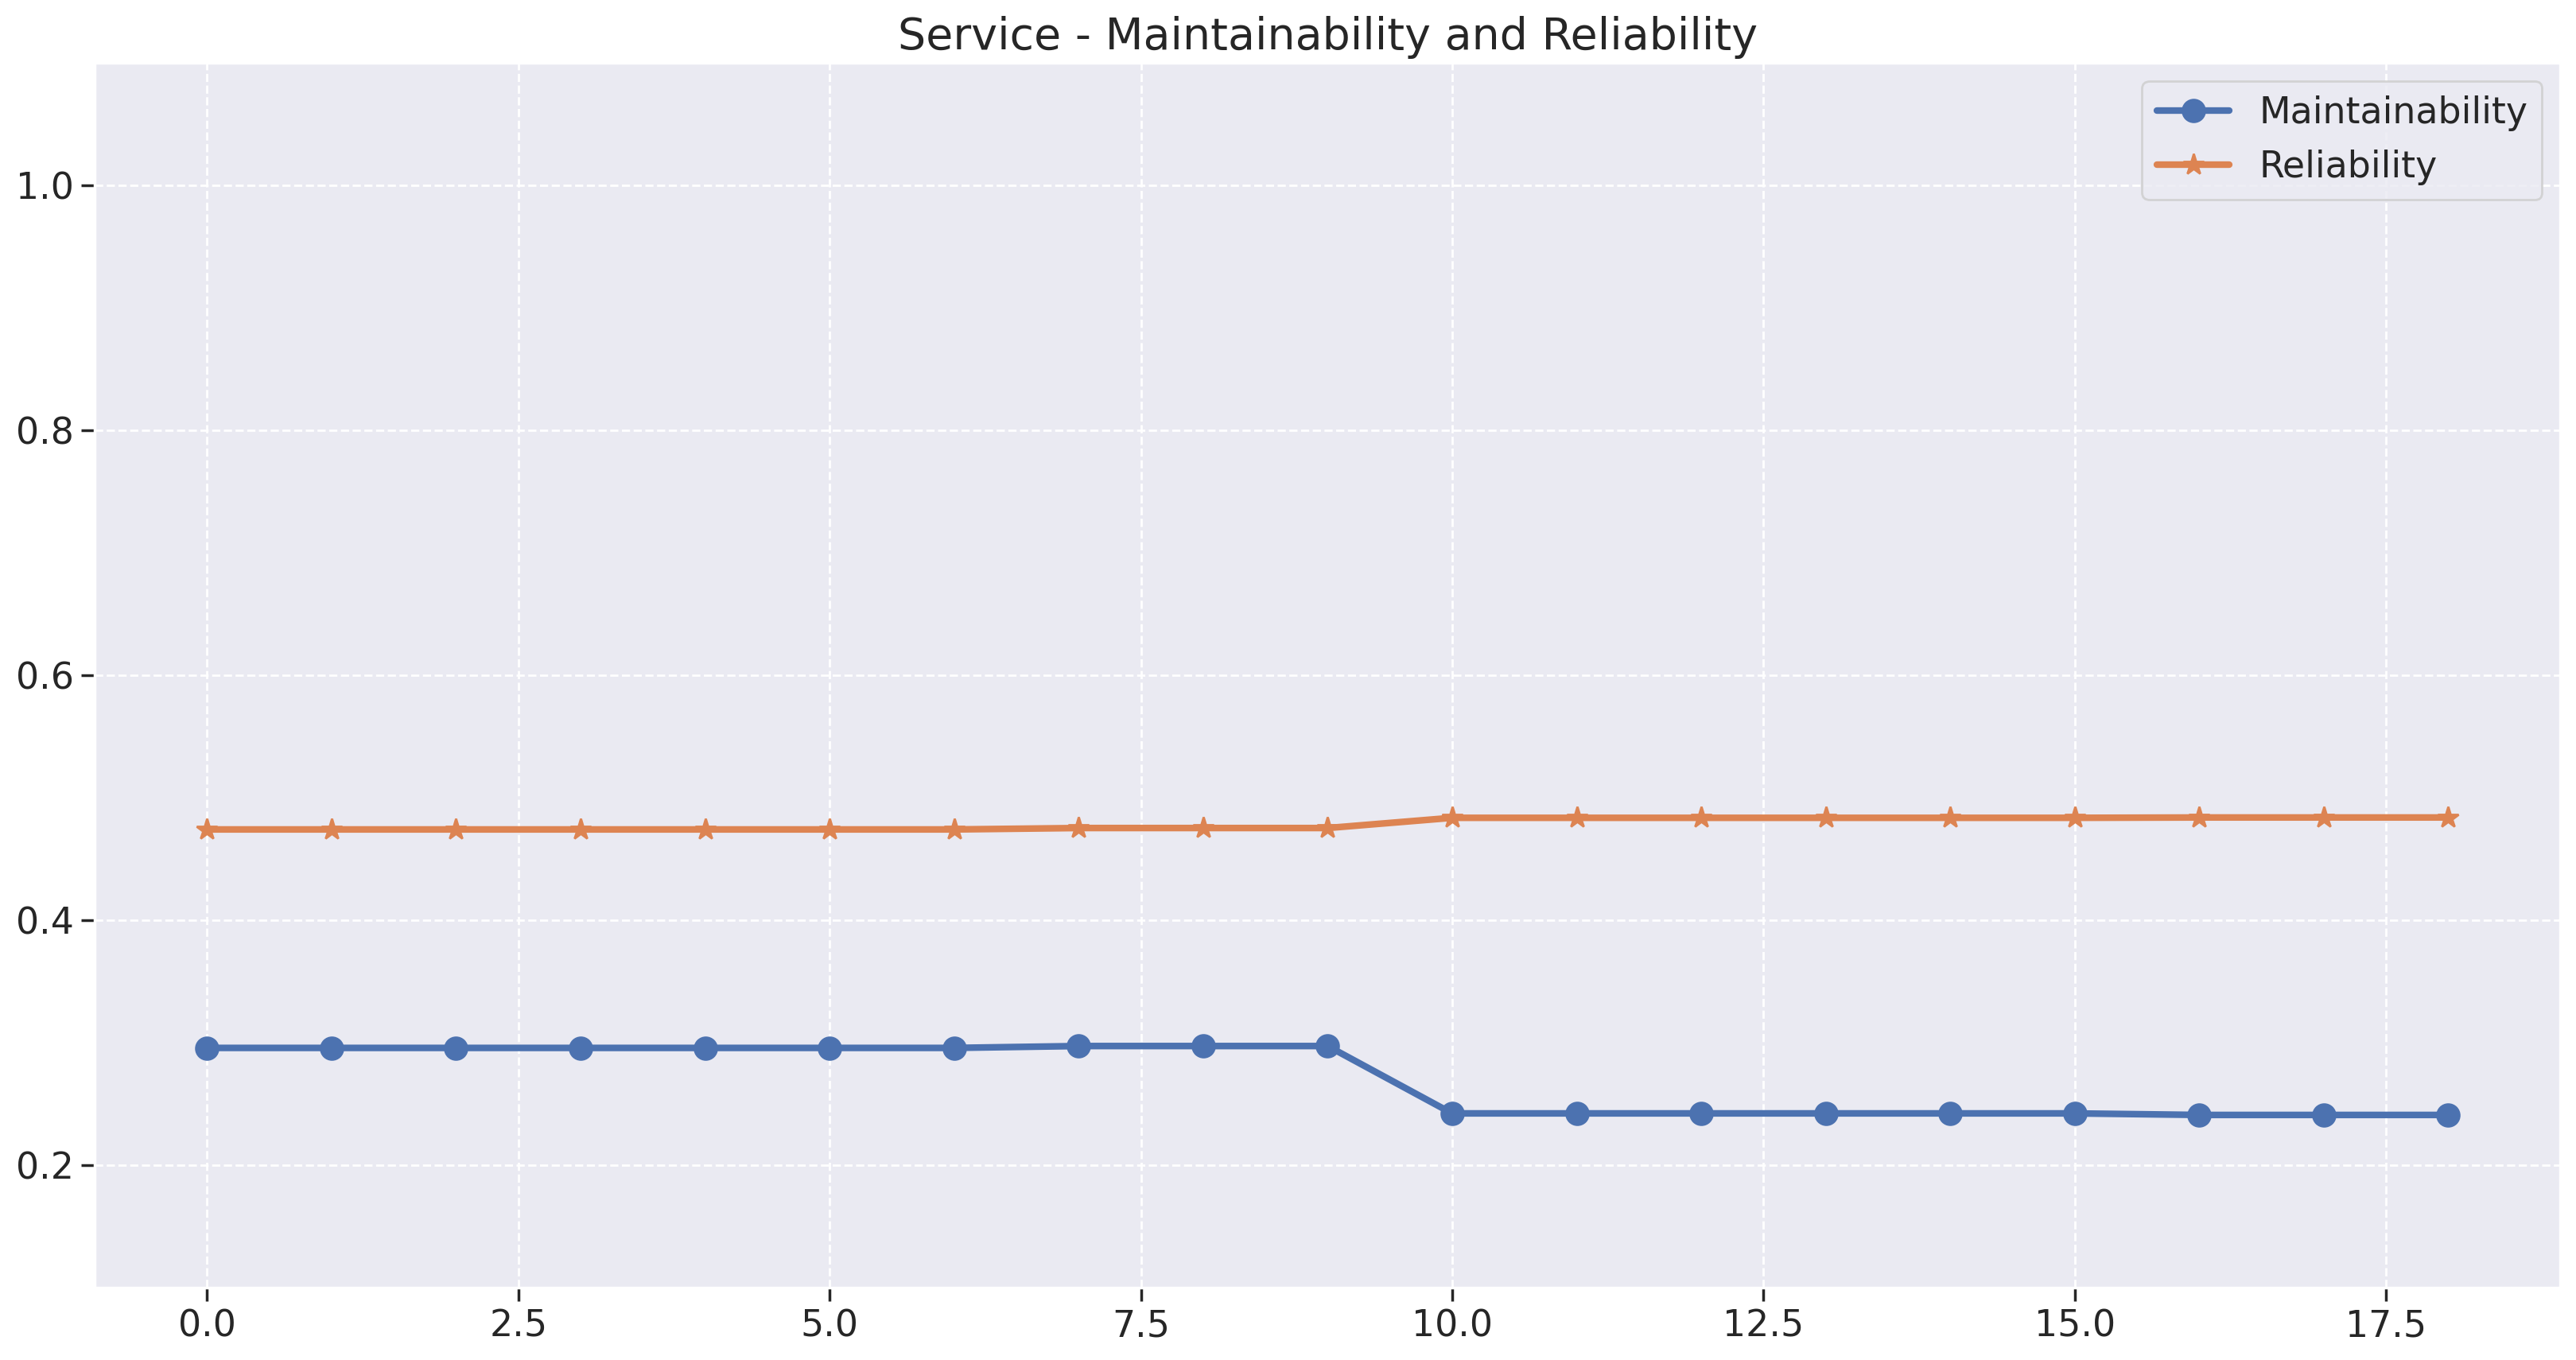

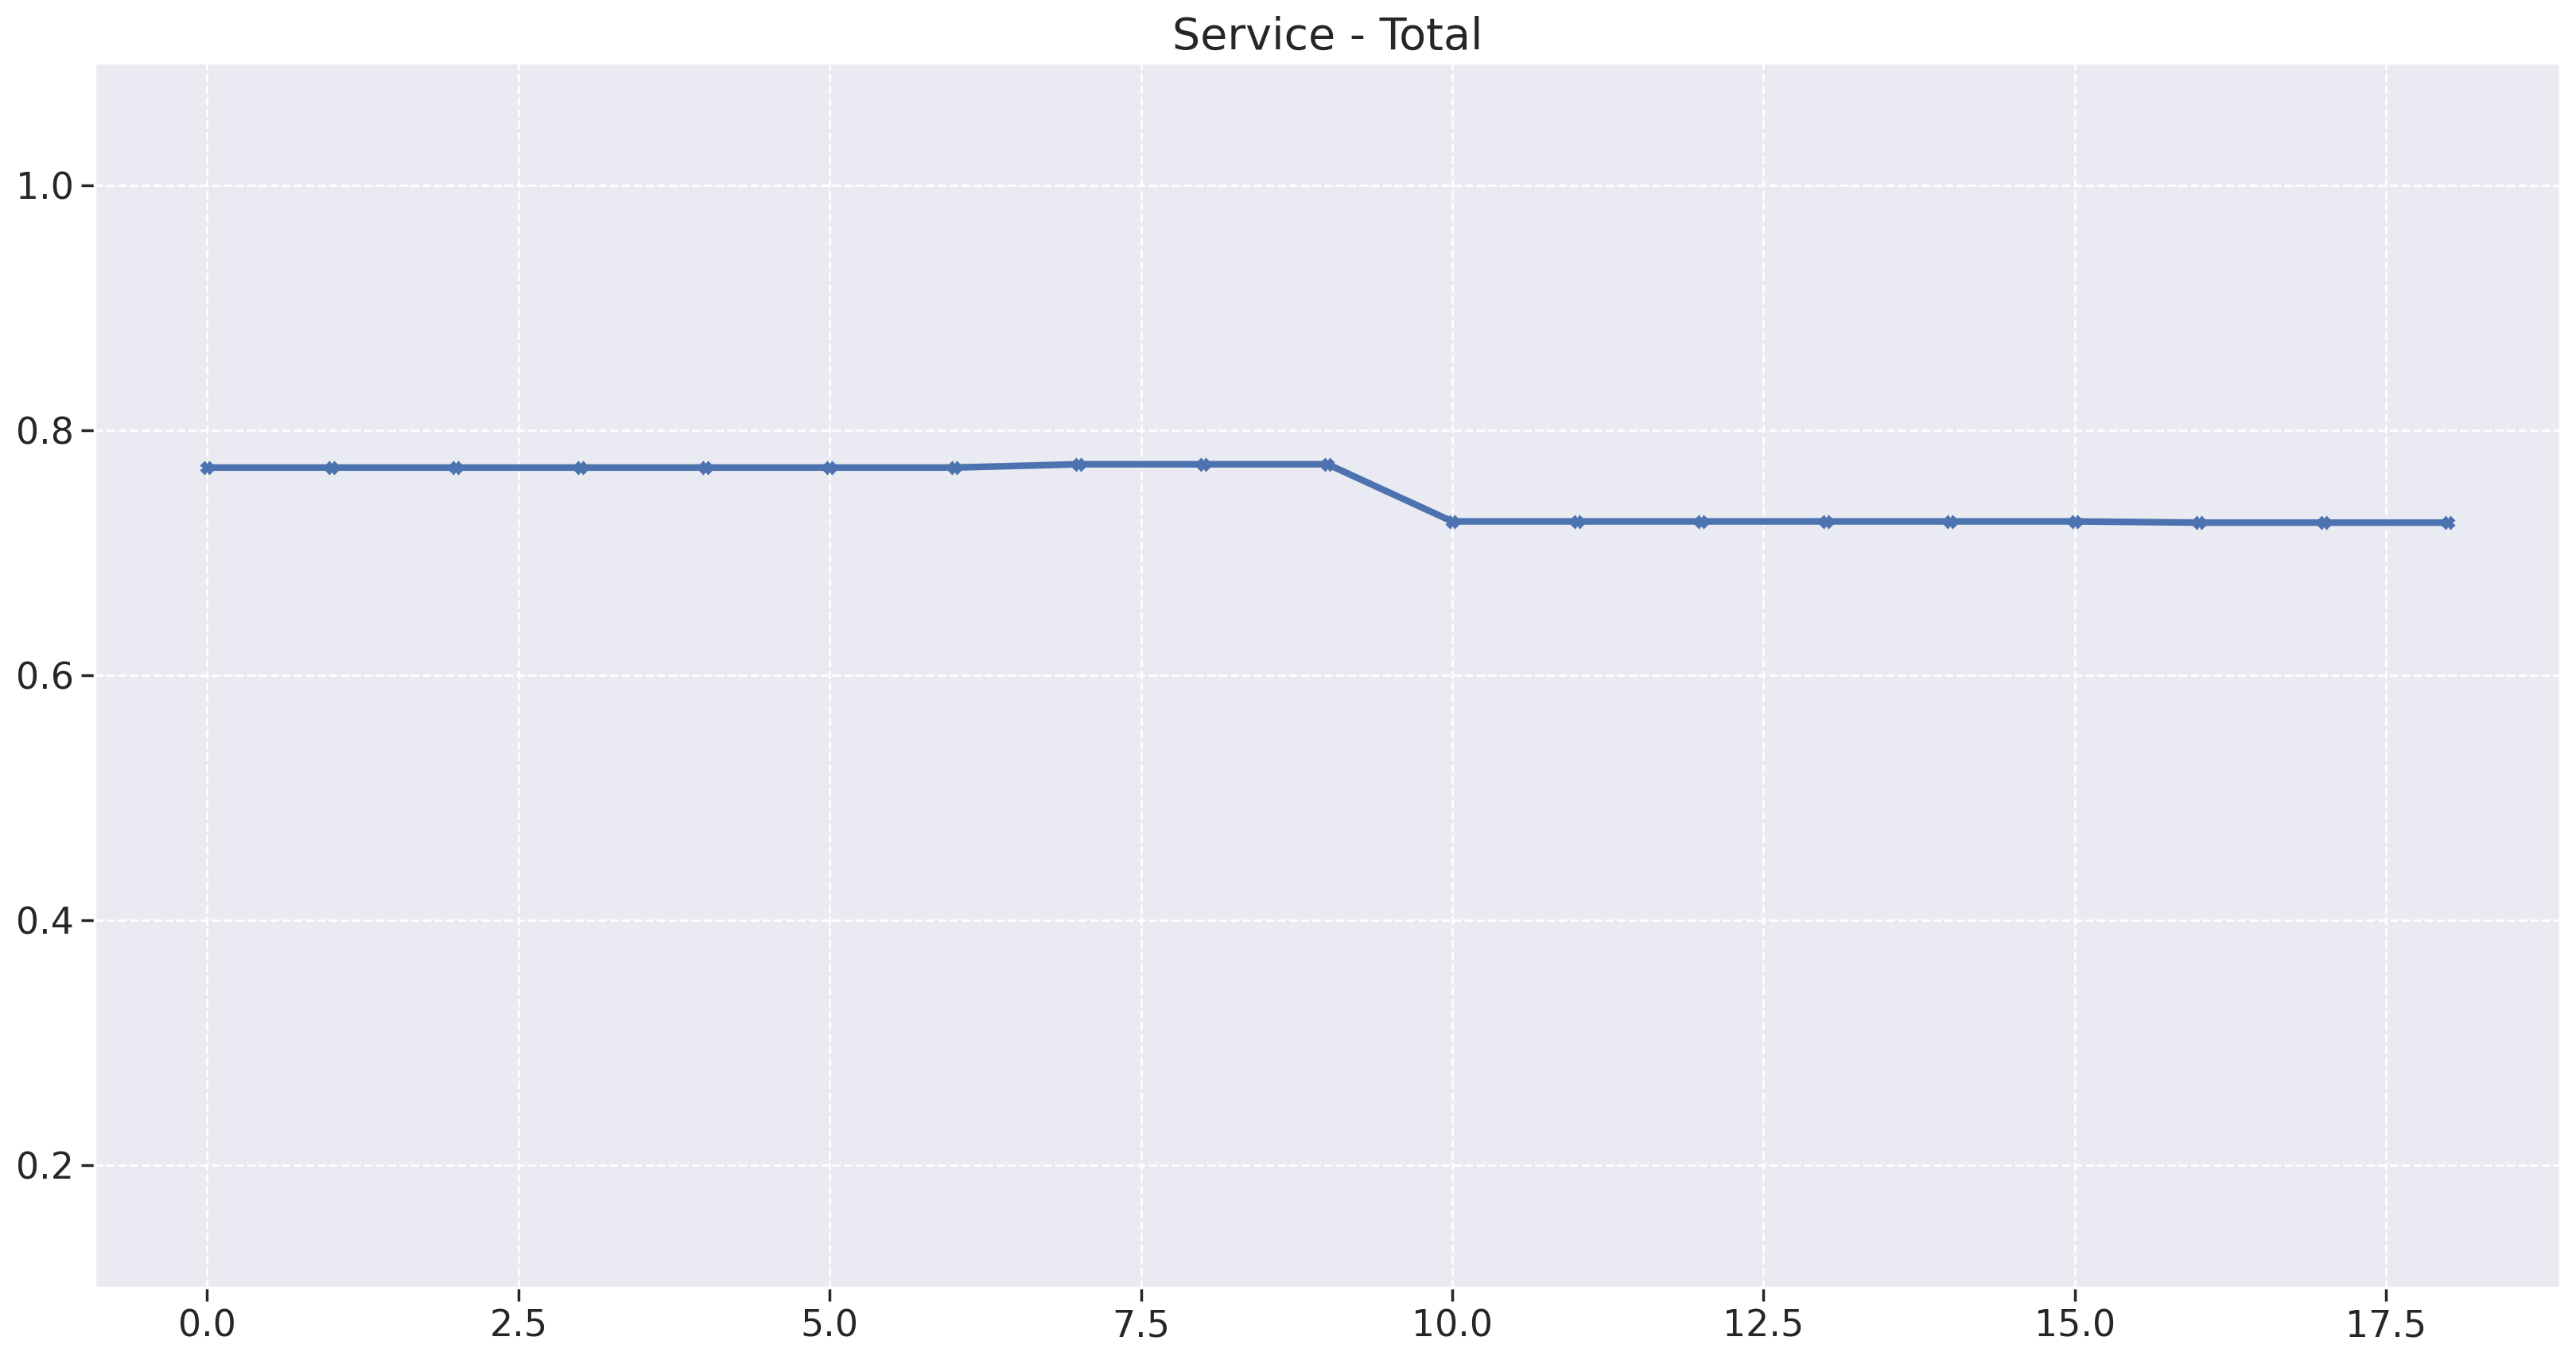

CLI
Maintainability Stats
    mean  mode  median     std      var   min   max
0.315333 0.319   0.319 0.01537 0.000236 0.297 0.341
Reliability Stats
 mean  mode  median          std          var  min  max
 0.45  0.45    0.45 5.745950e-17 3.301594e-33 0.45 0.45


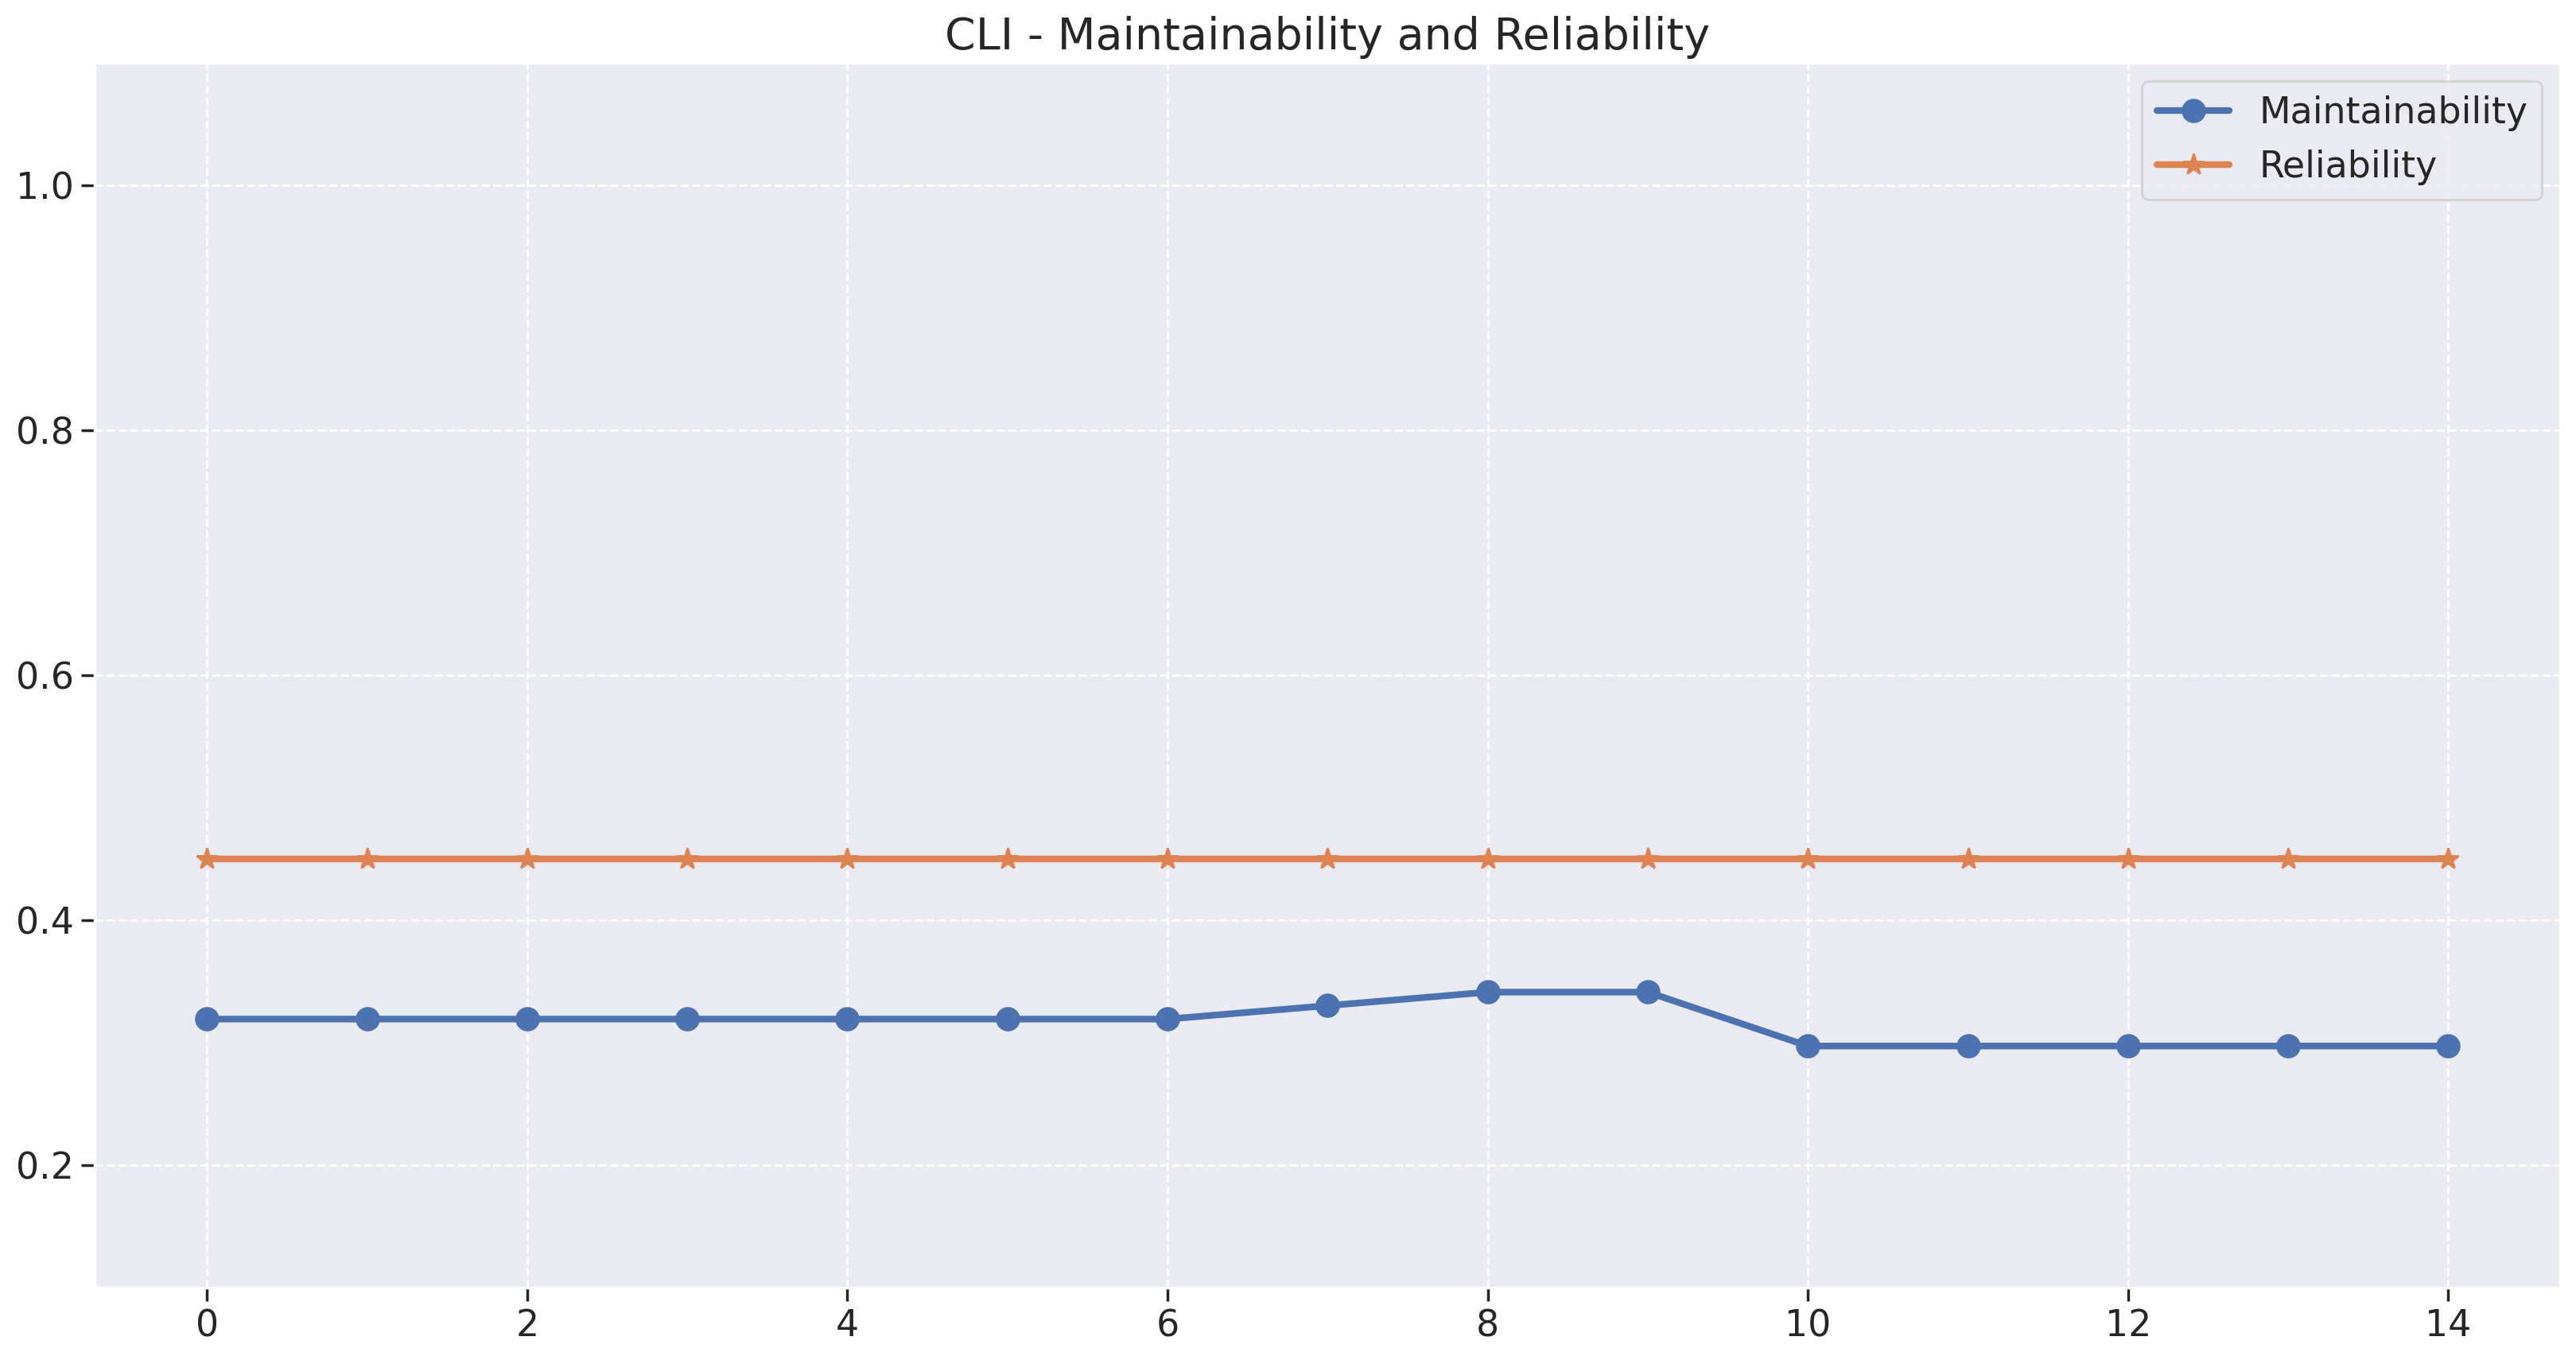

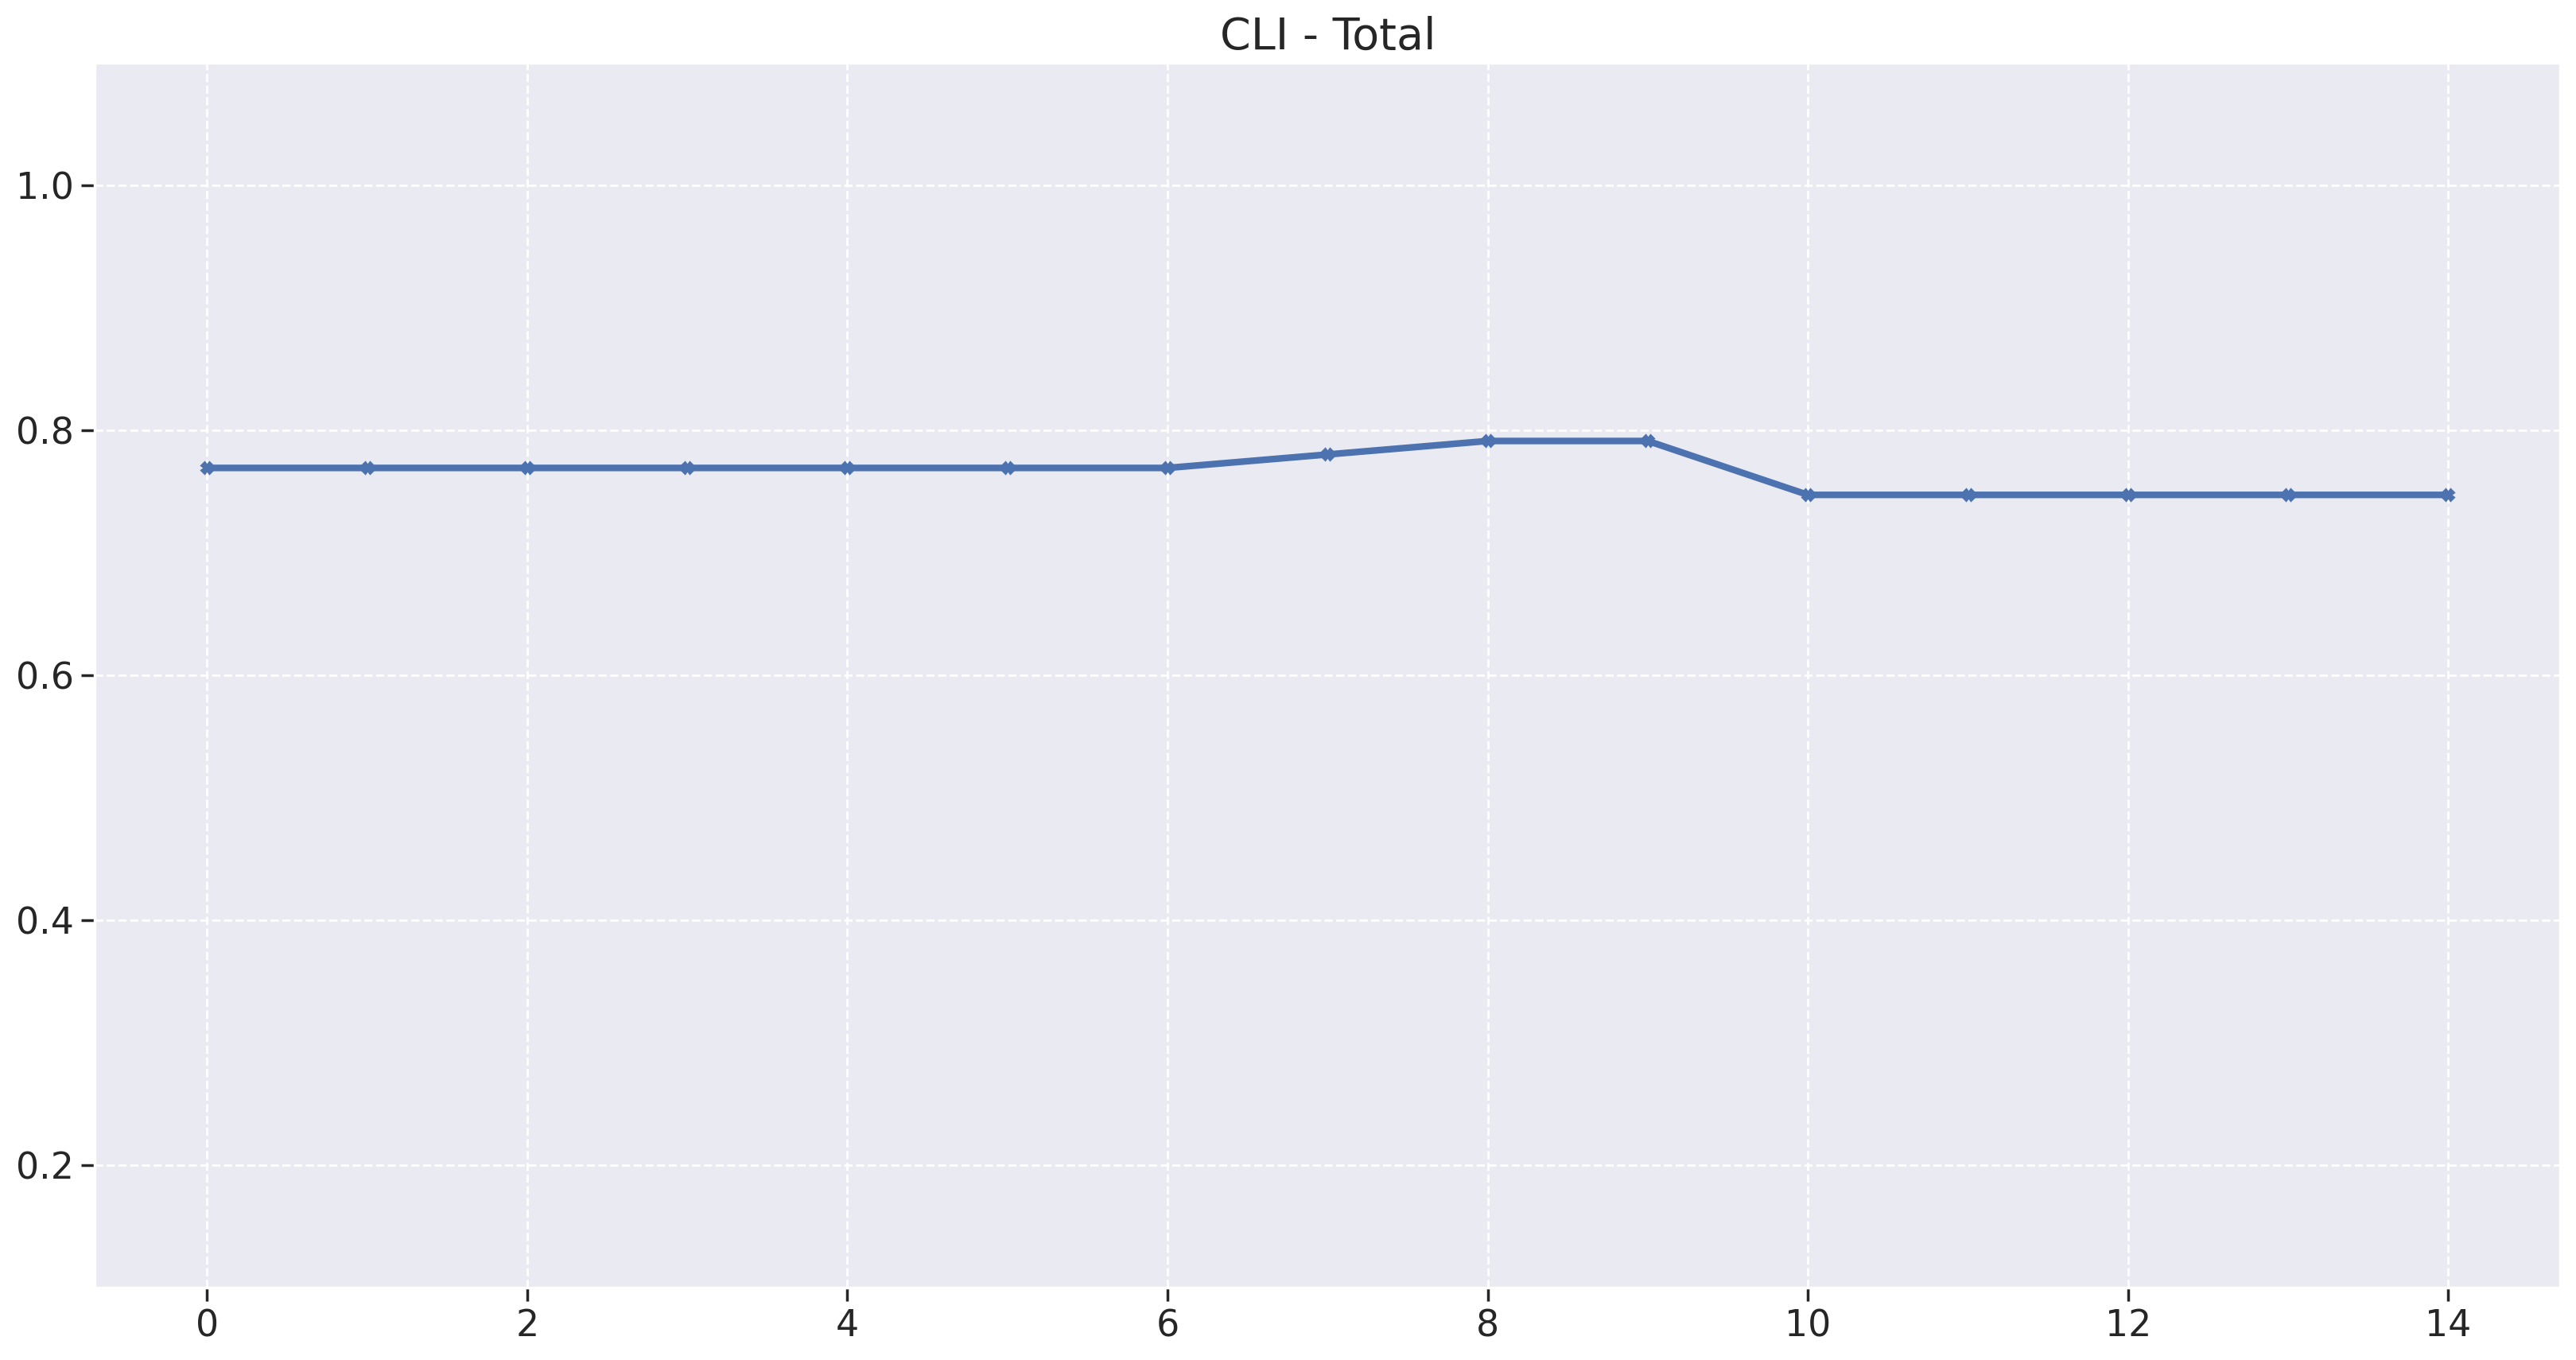

Front
Maintainability Stats
    mean     mode   median      std      var      min    max
0.299256 0.302077 0.299063 0.002776 0.000008 0.293906 0.3025
Reliability Stats
    mean     mode   median      std      var      min      max
0.433125 0.436538 0.428819 0.009688 0.000094 0.421875 0.453571


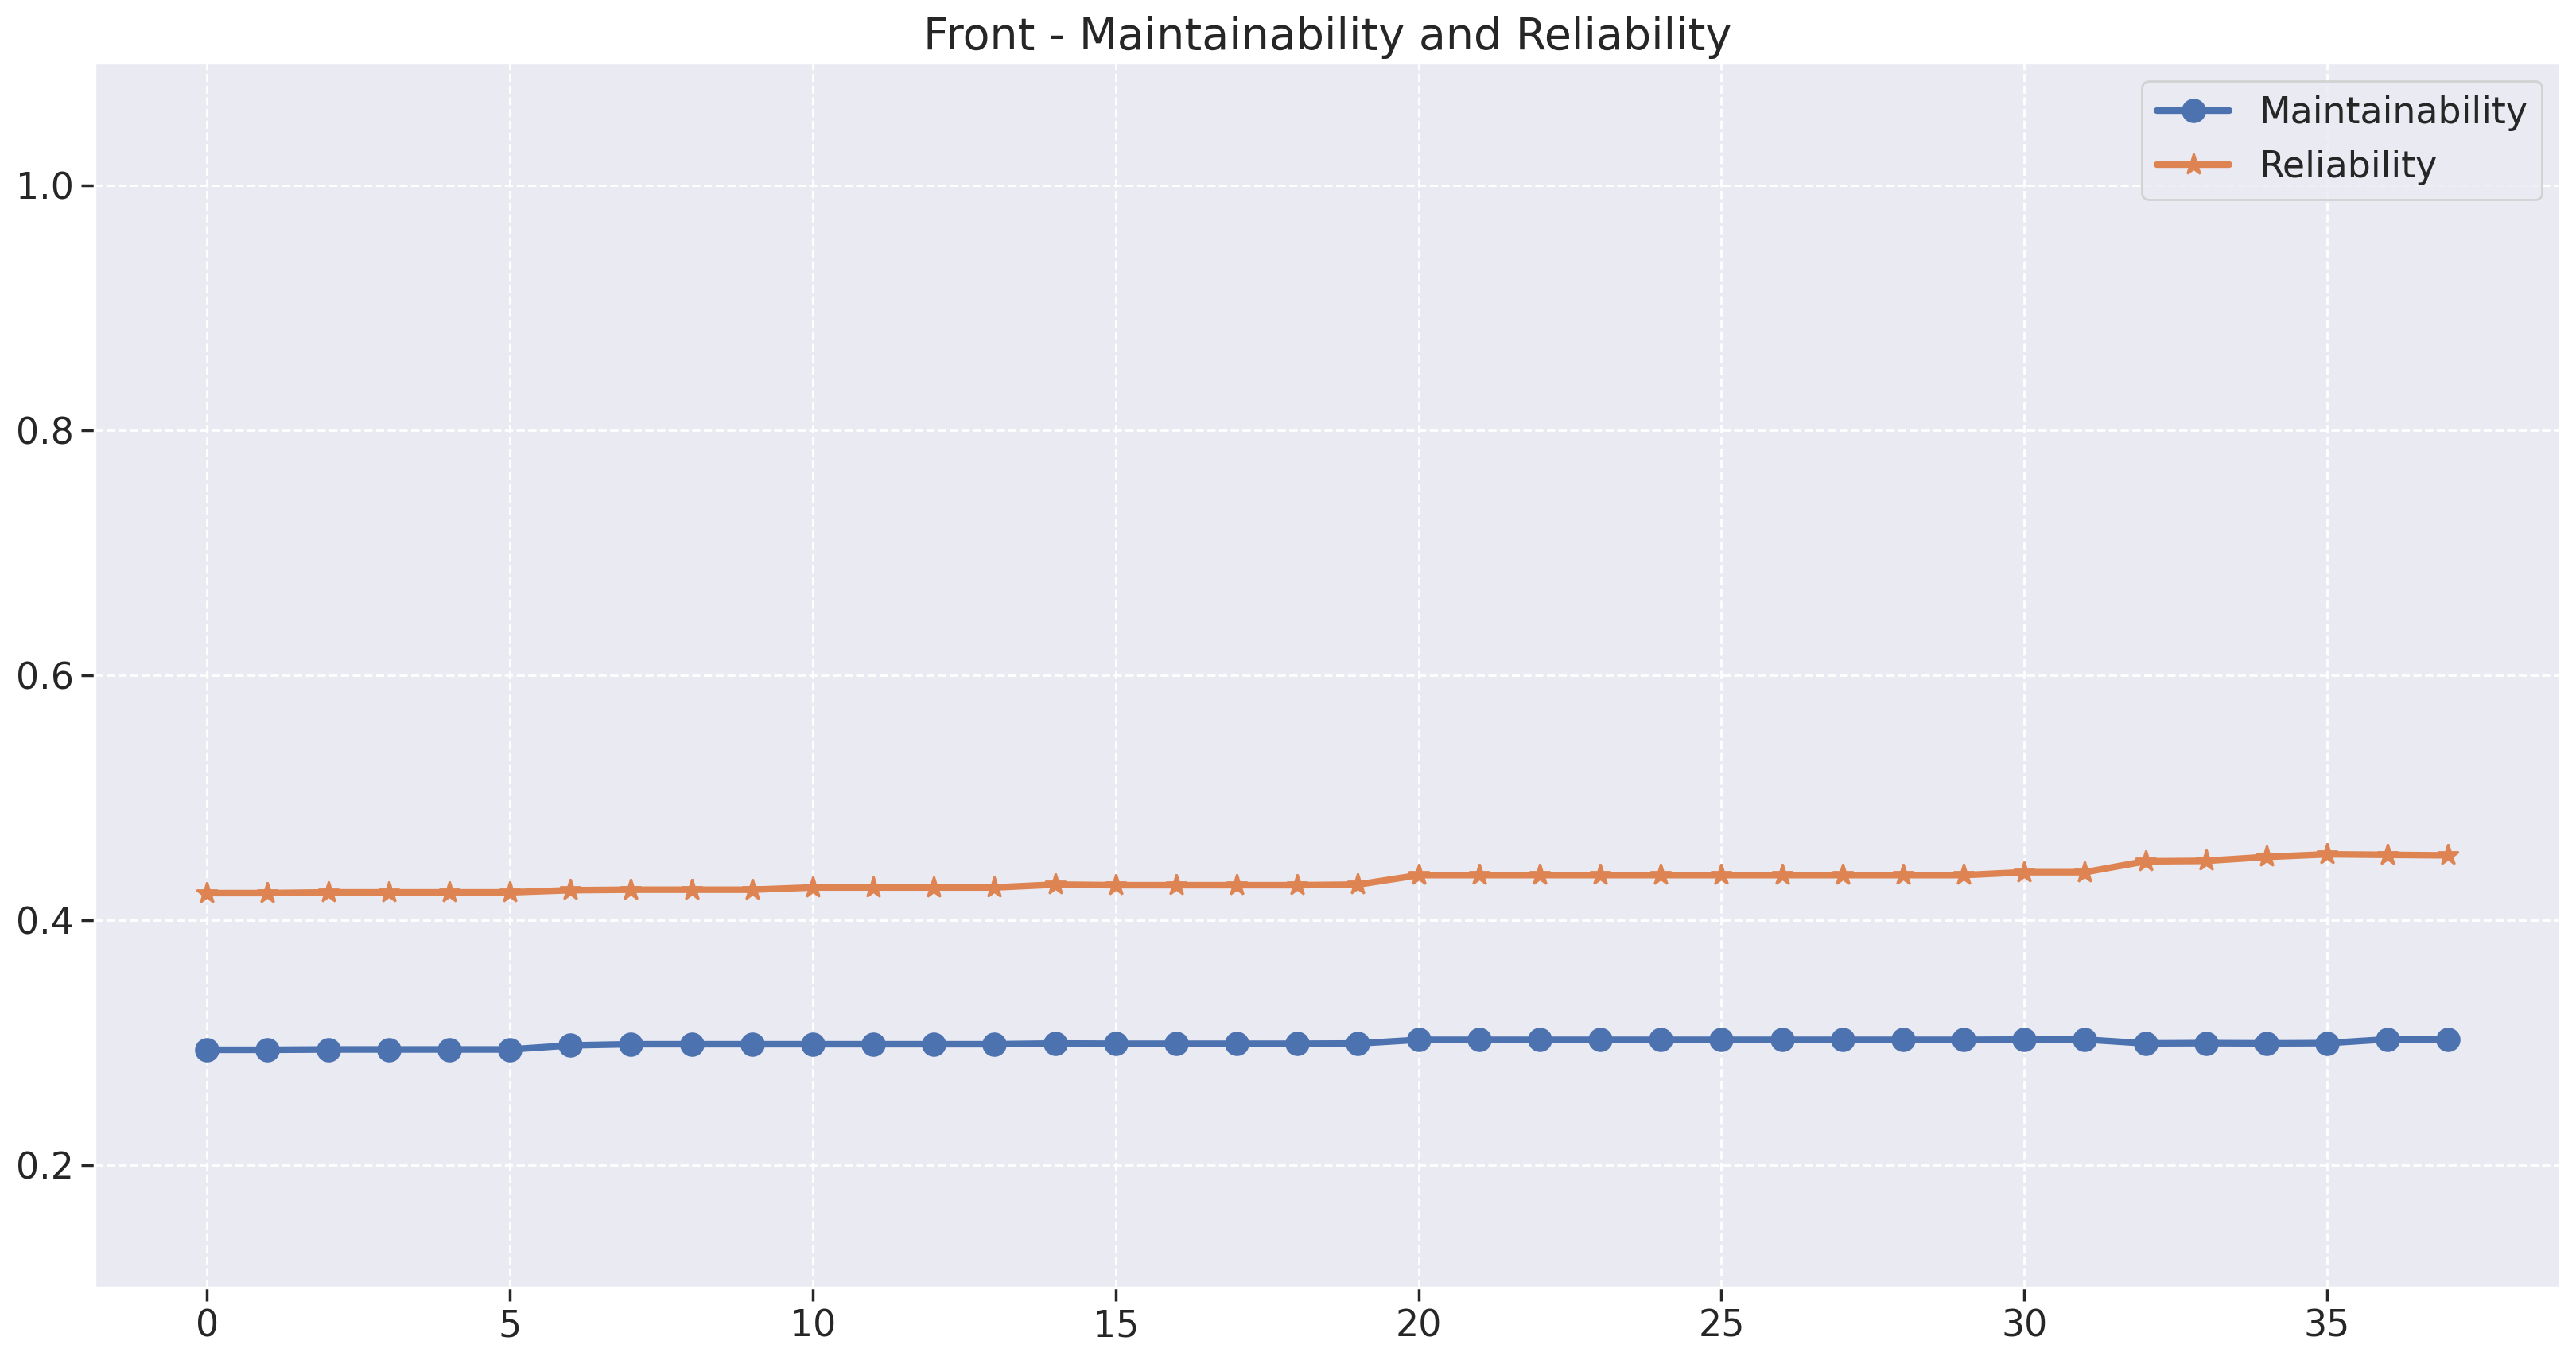

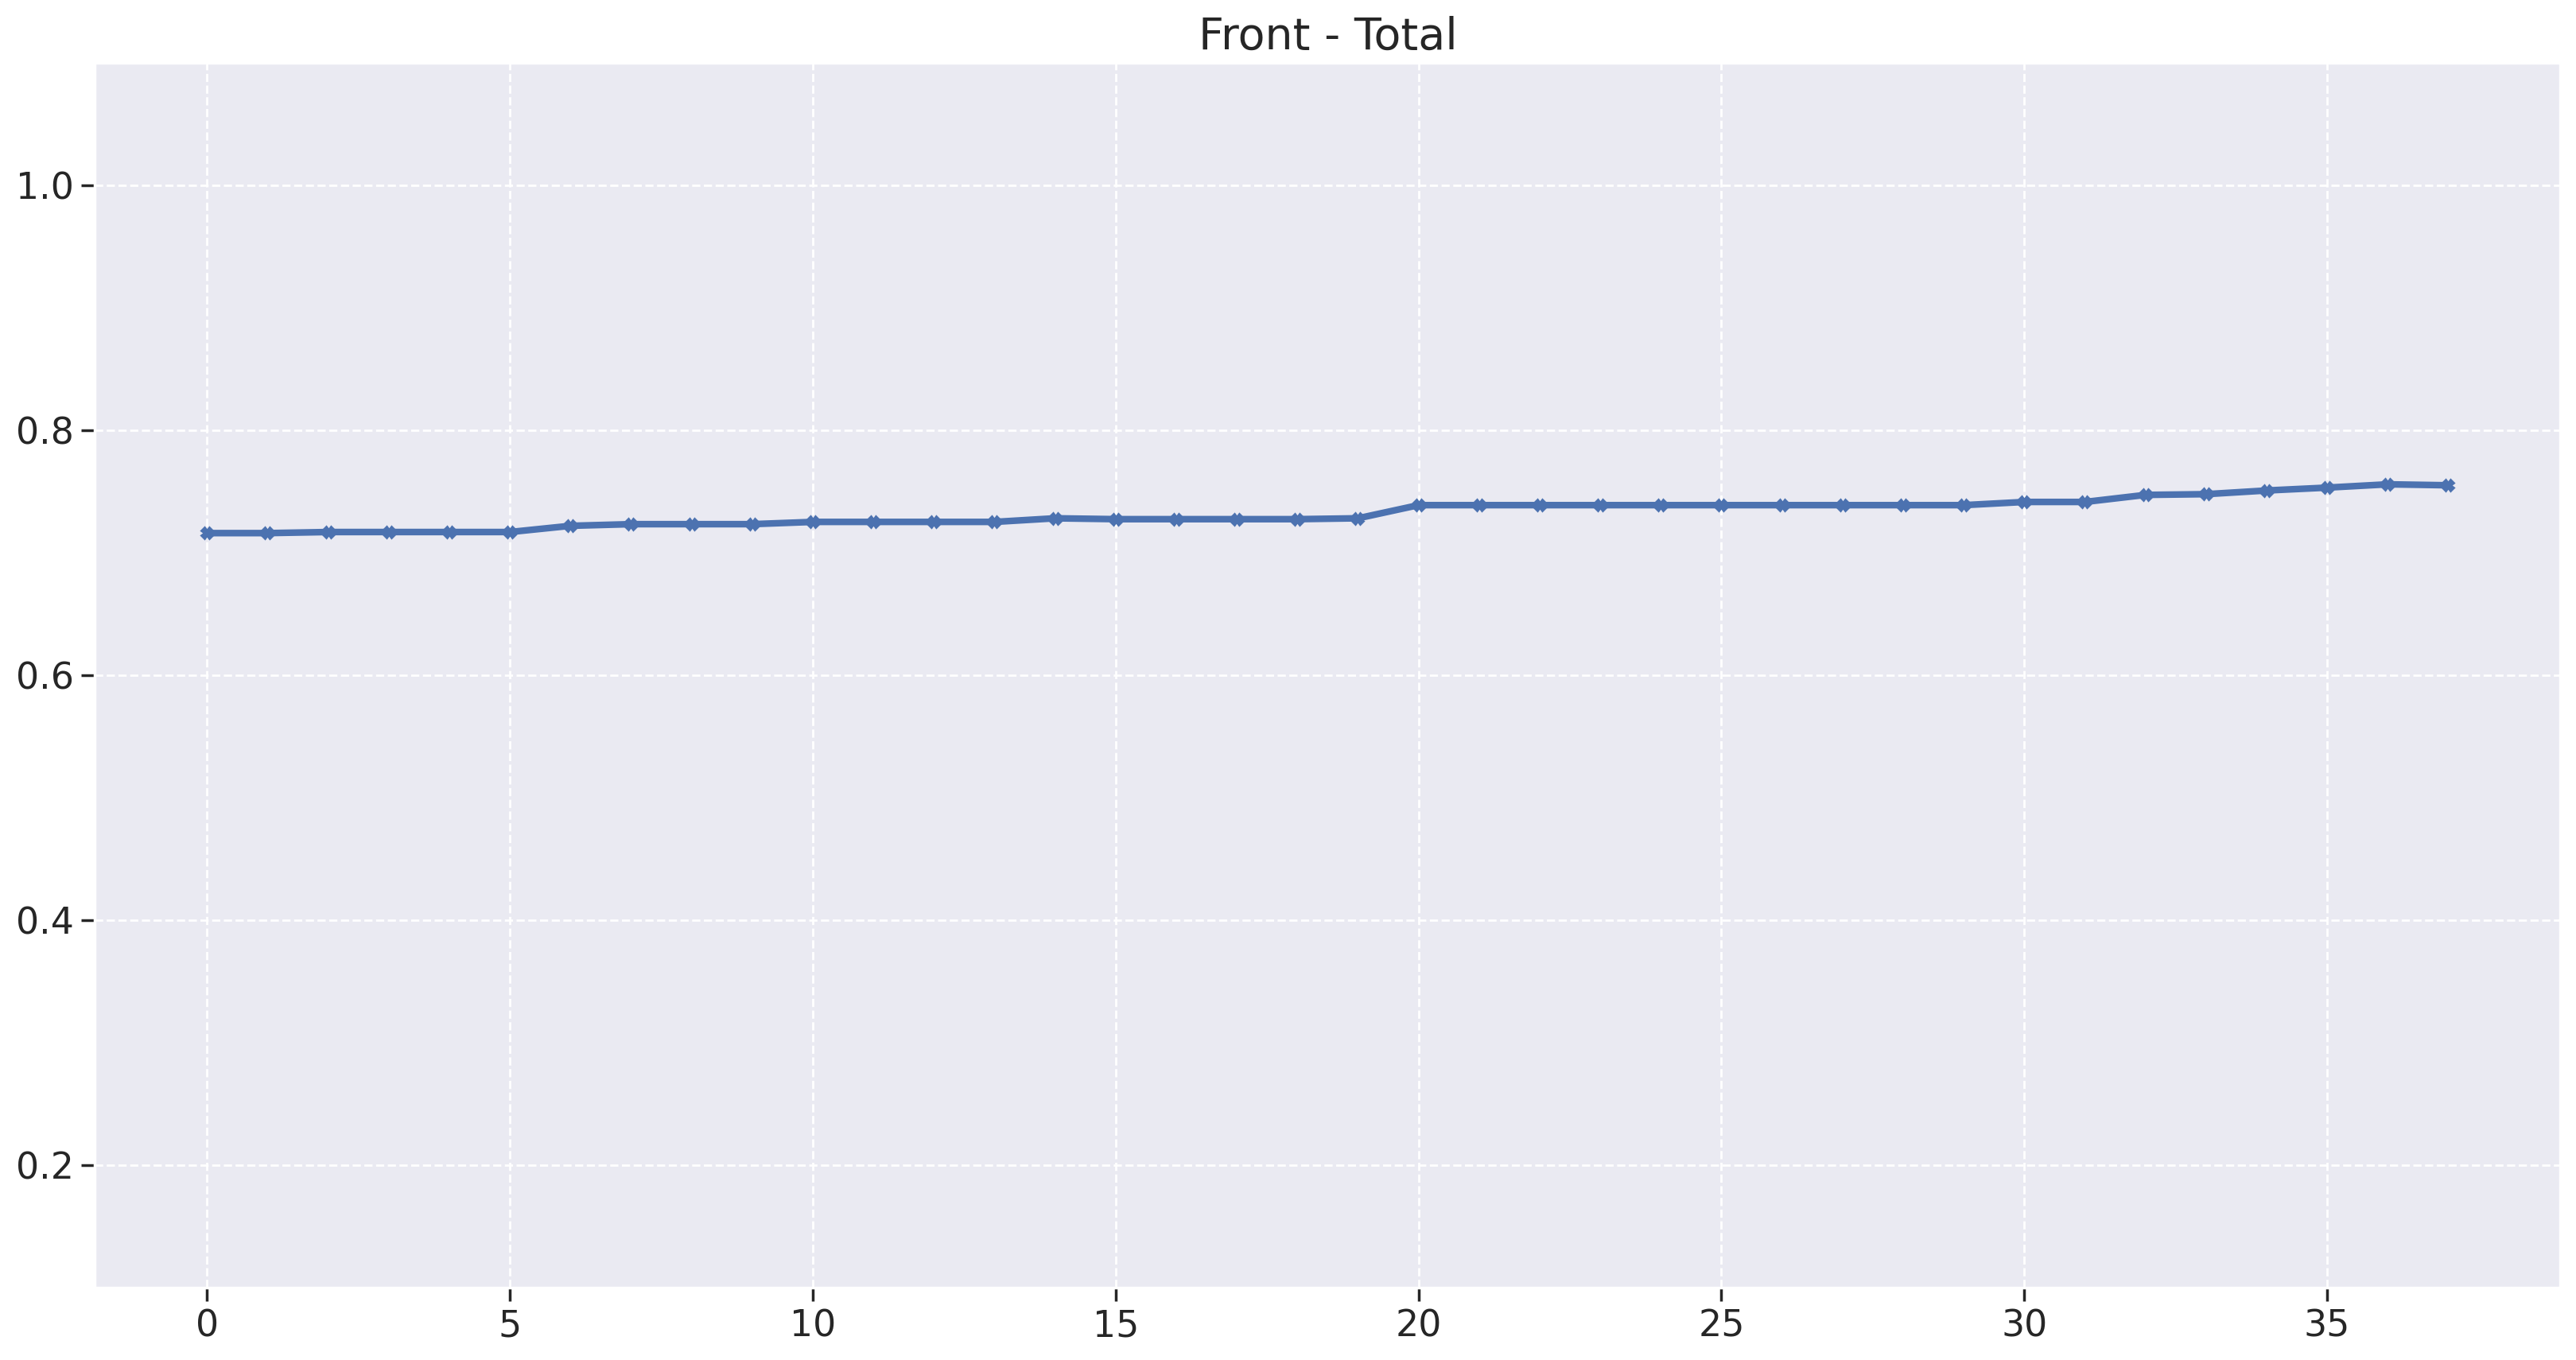

Core
Maintainability Stats
    mean  mode   median      std      var  min      max
0.305357   0.3 0.305937 0.005294 0.000028  0.3 0.311667
Reliability Stats
    mean  mode  median      std      var      min  max
0.498512   0.5     0.5 0.005568 0.000031 0.479167  0.5


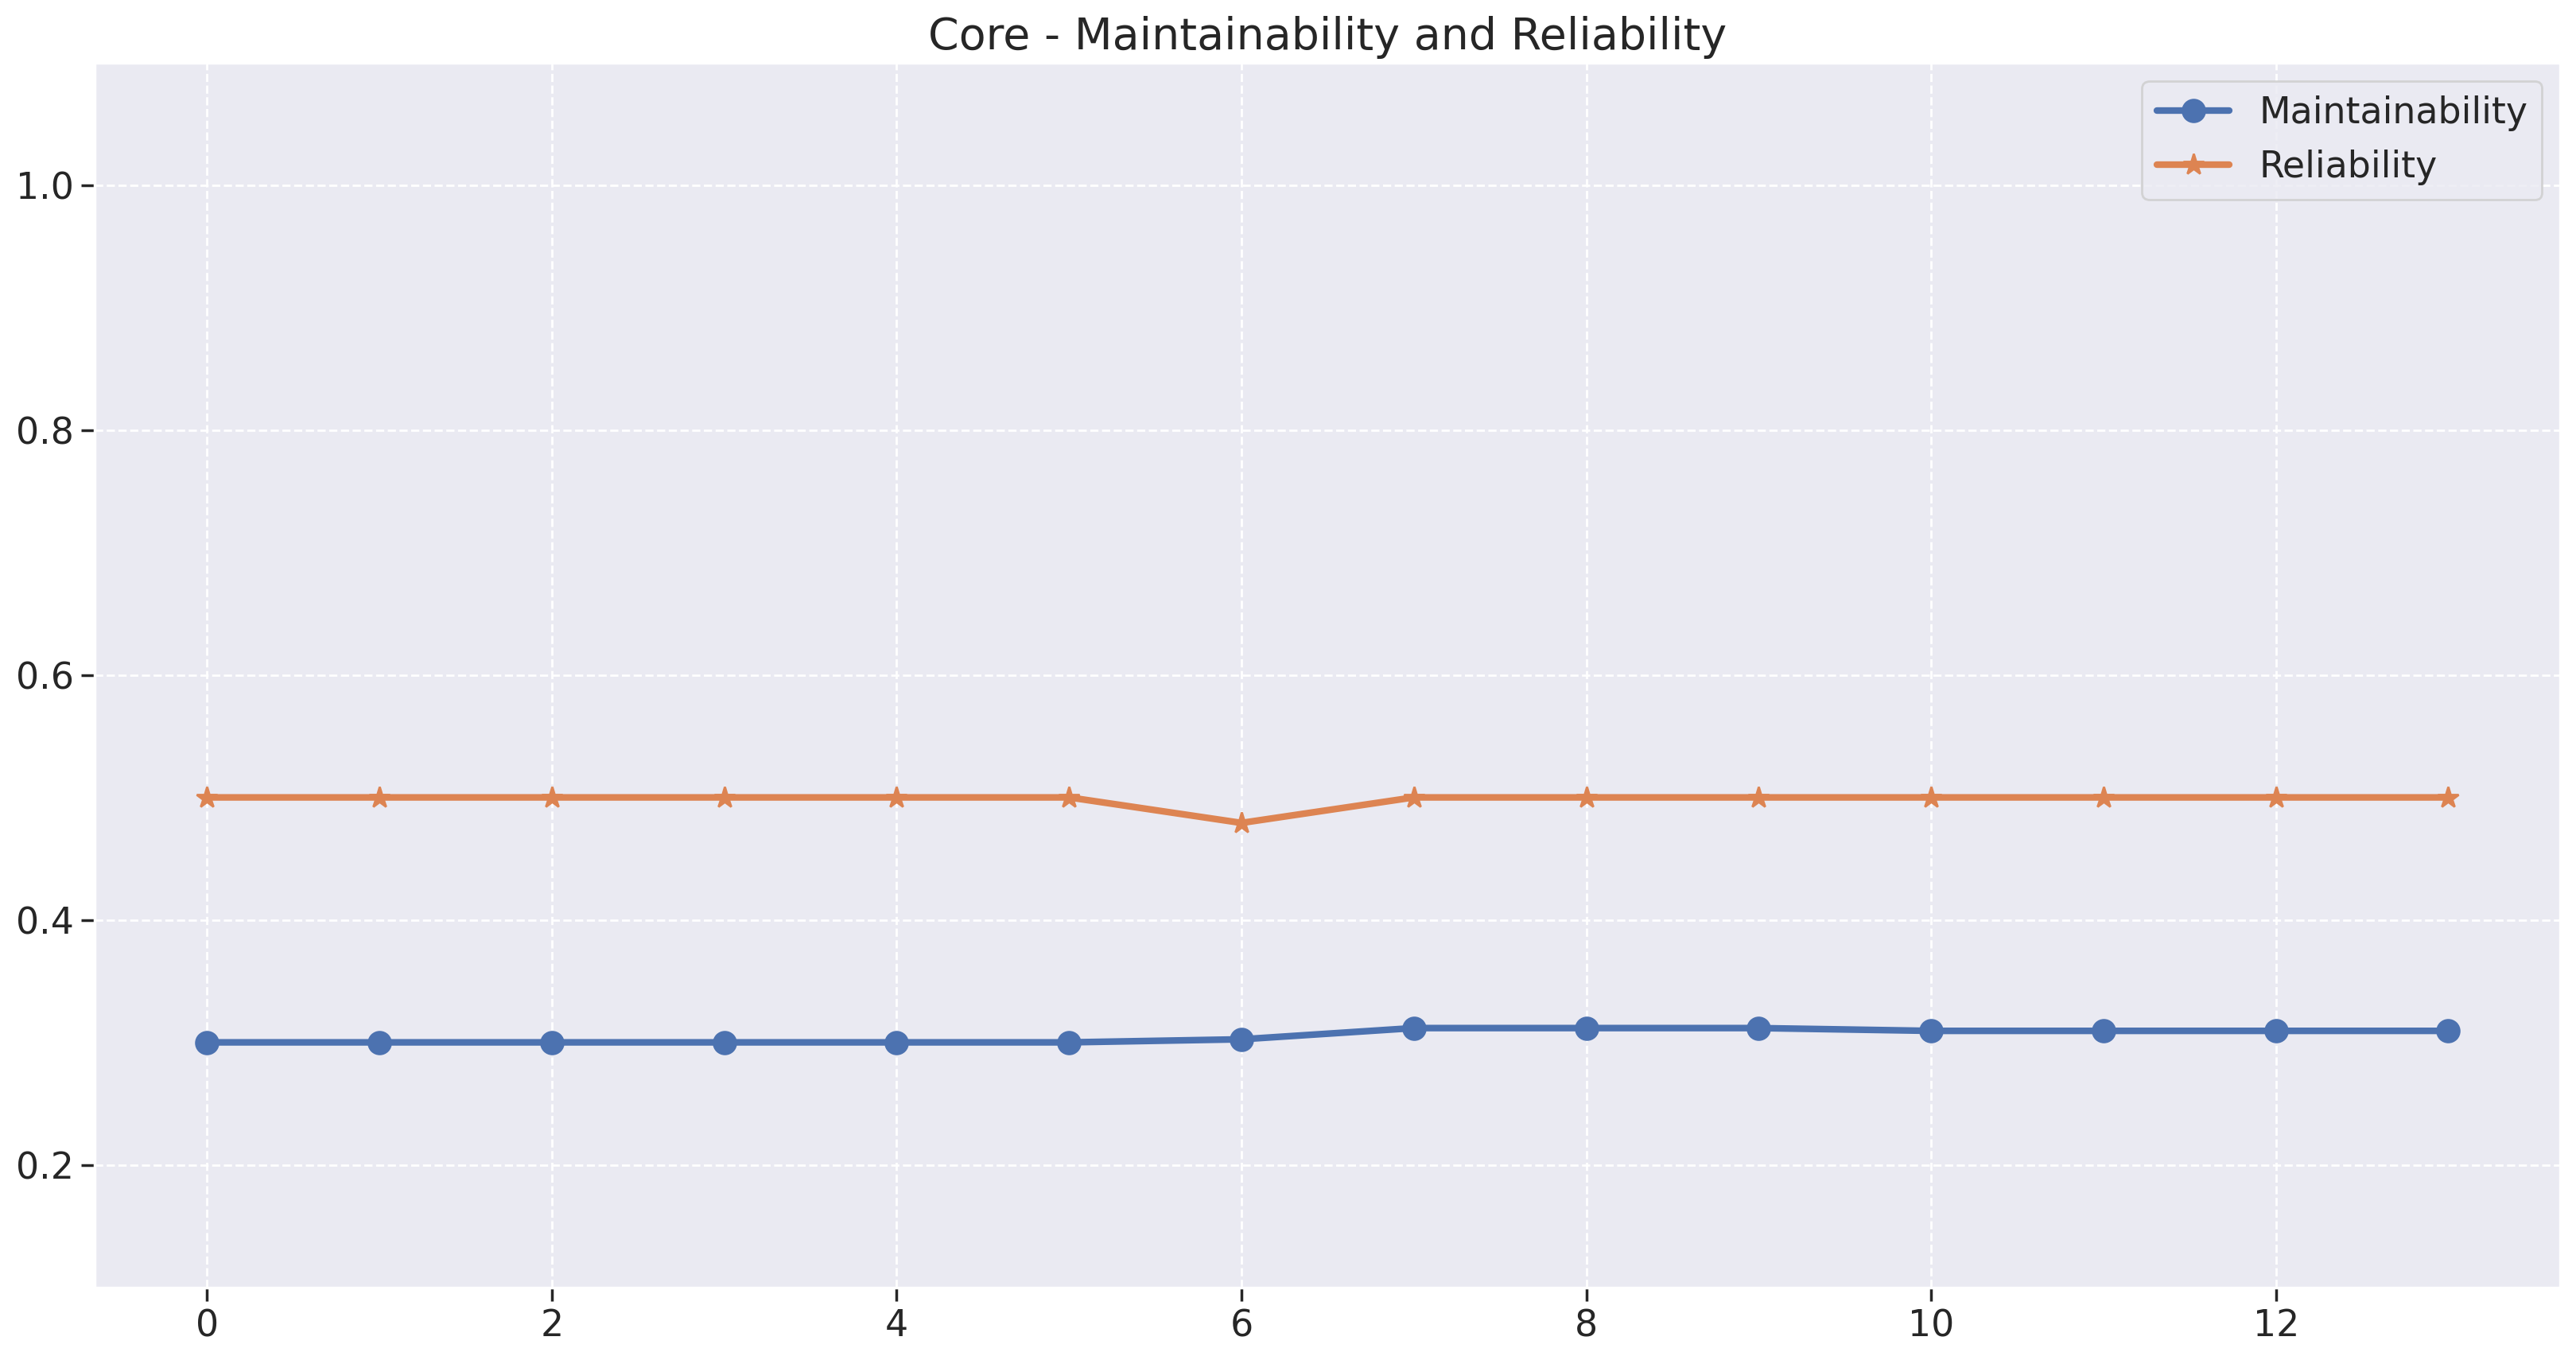

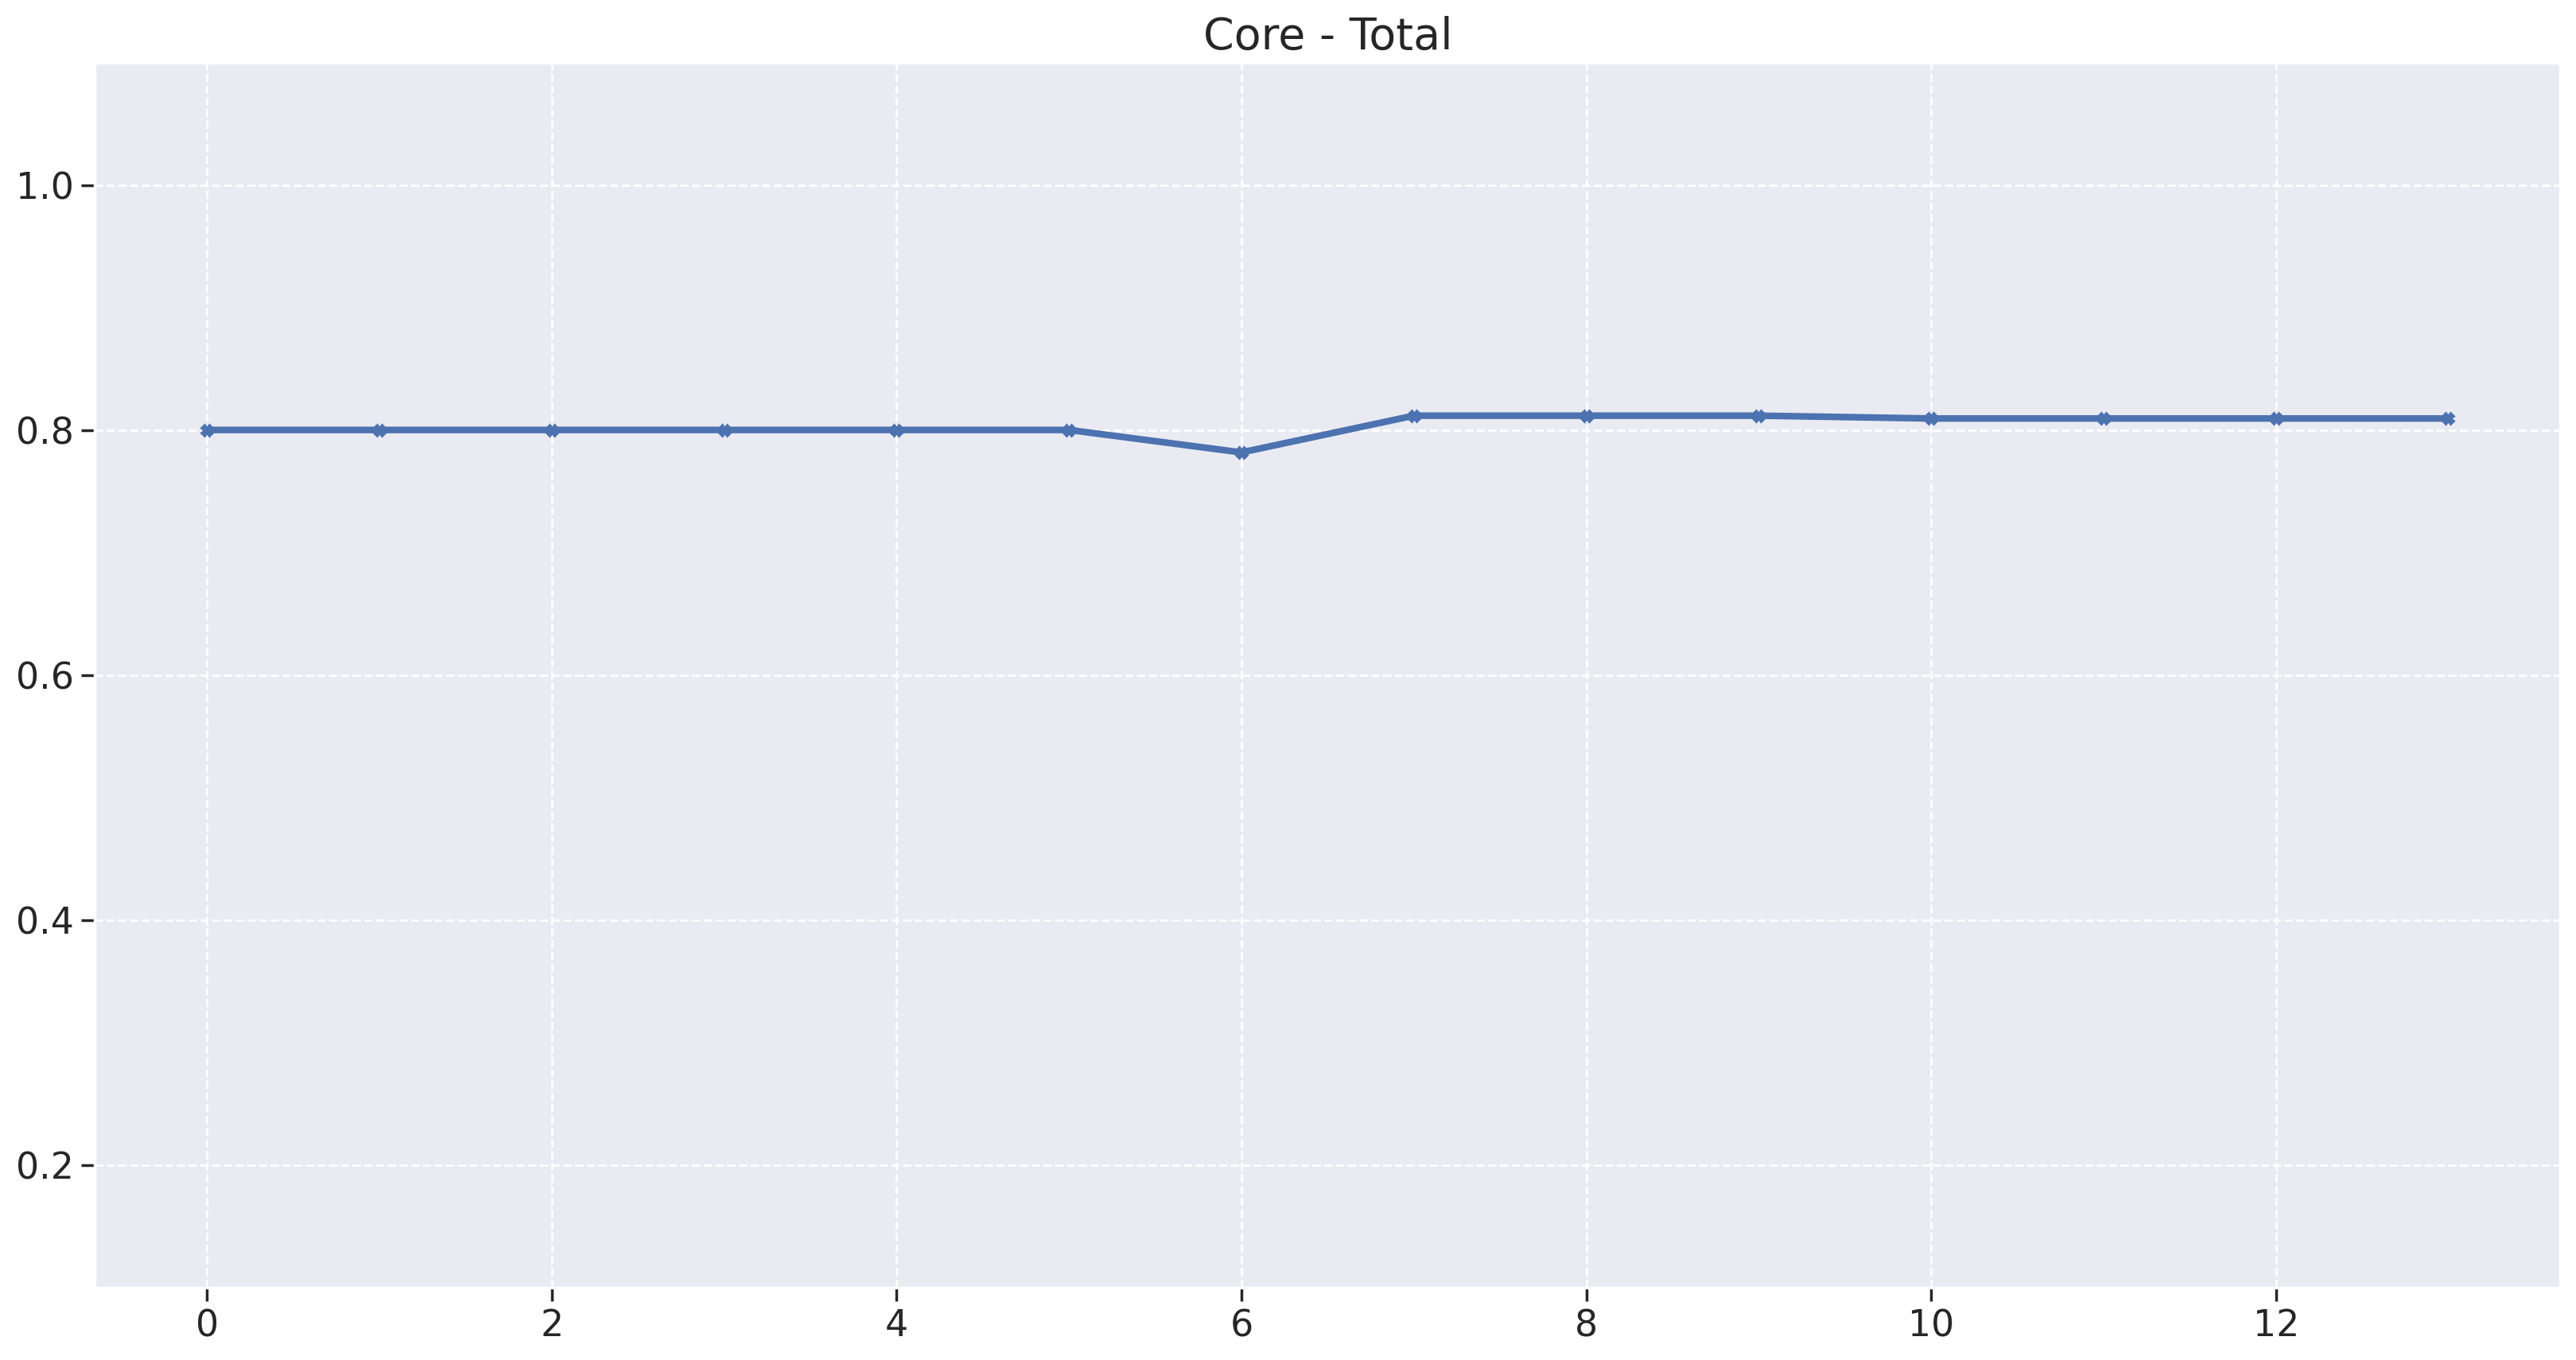

Action
Maintainability Stats
    mean  mode  median      std      var  min  max
0.194118  0.33    0.33 0.167409 0.028026  0.0 0.33
Reliability Stats
   mean     mode   median      std      var  min  max
0.27451 0.458333 0.458333 0.237106 0.056219  0.0  0.5


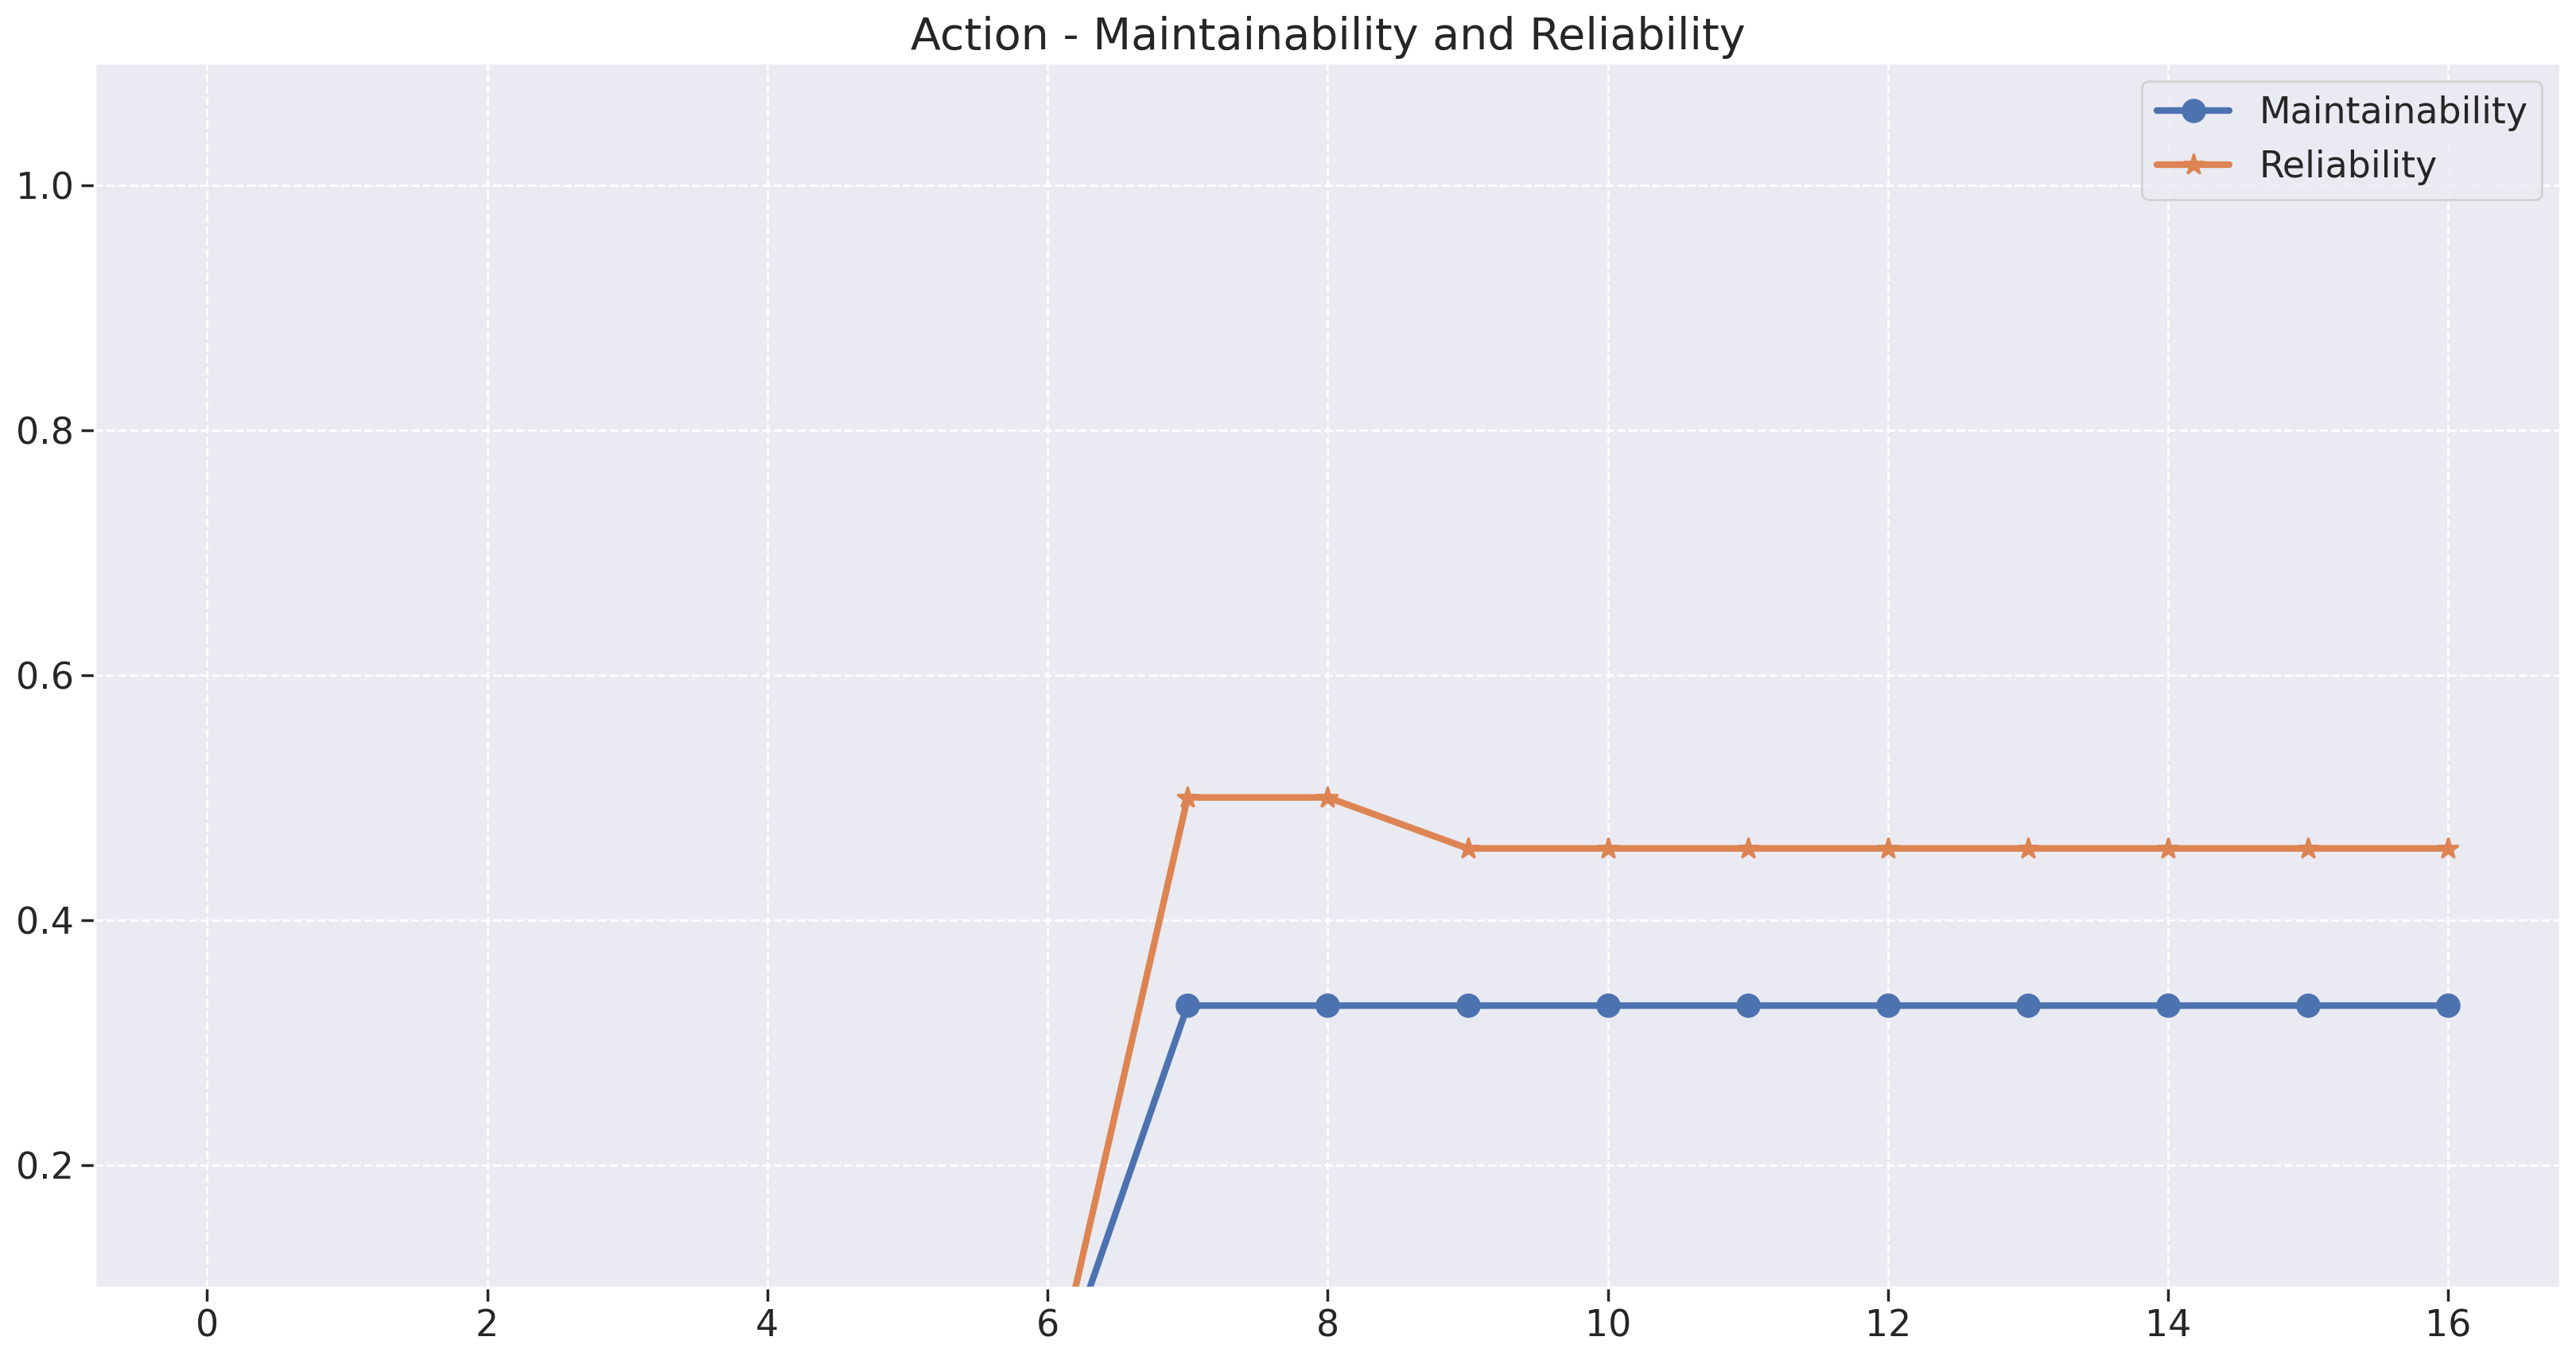

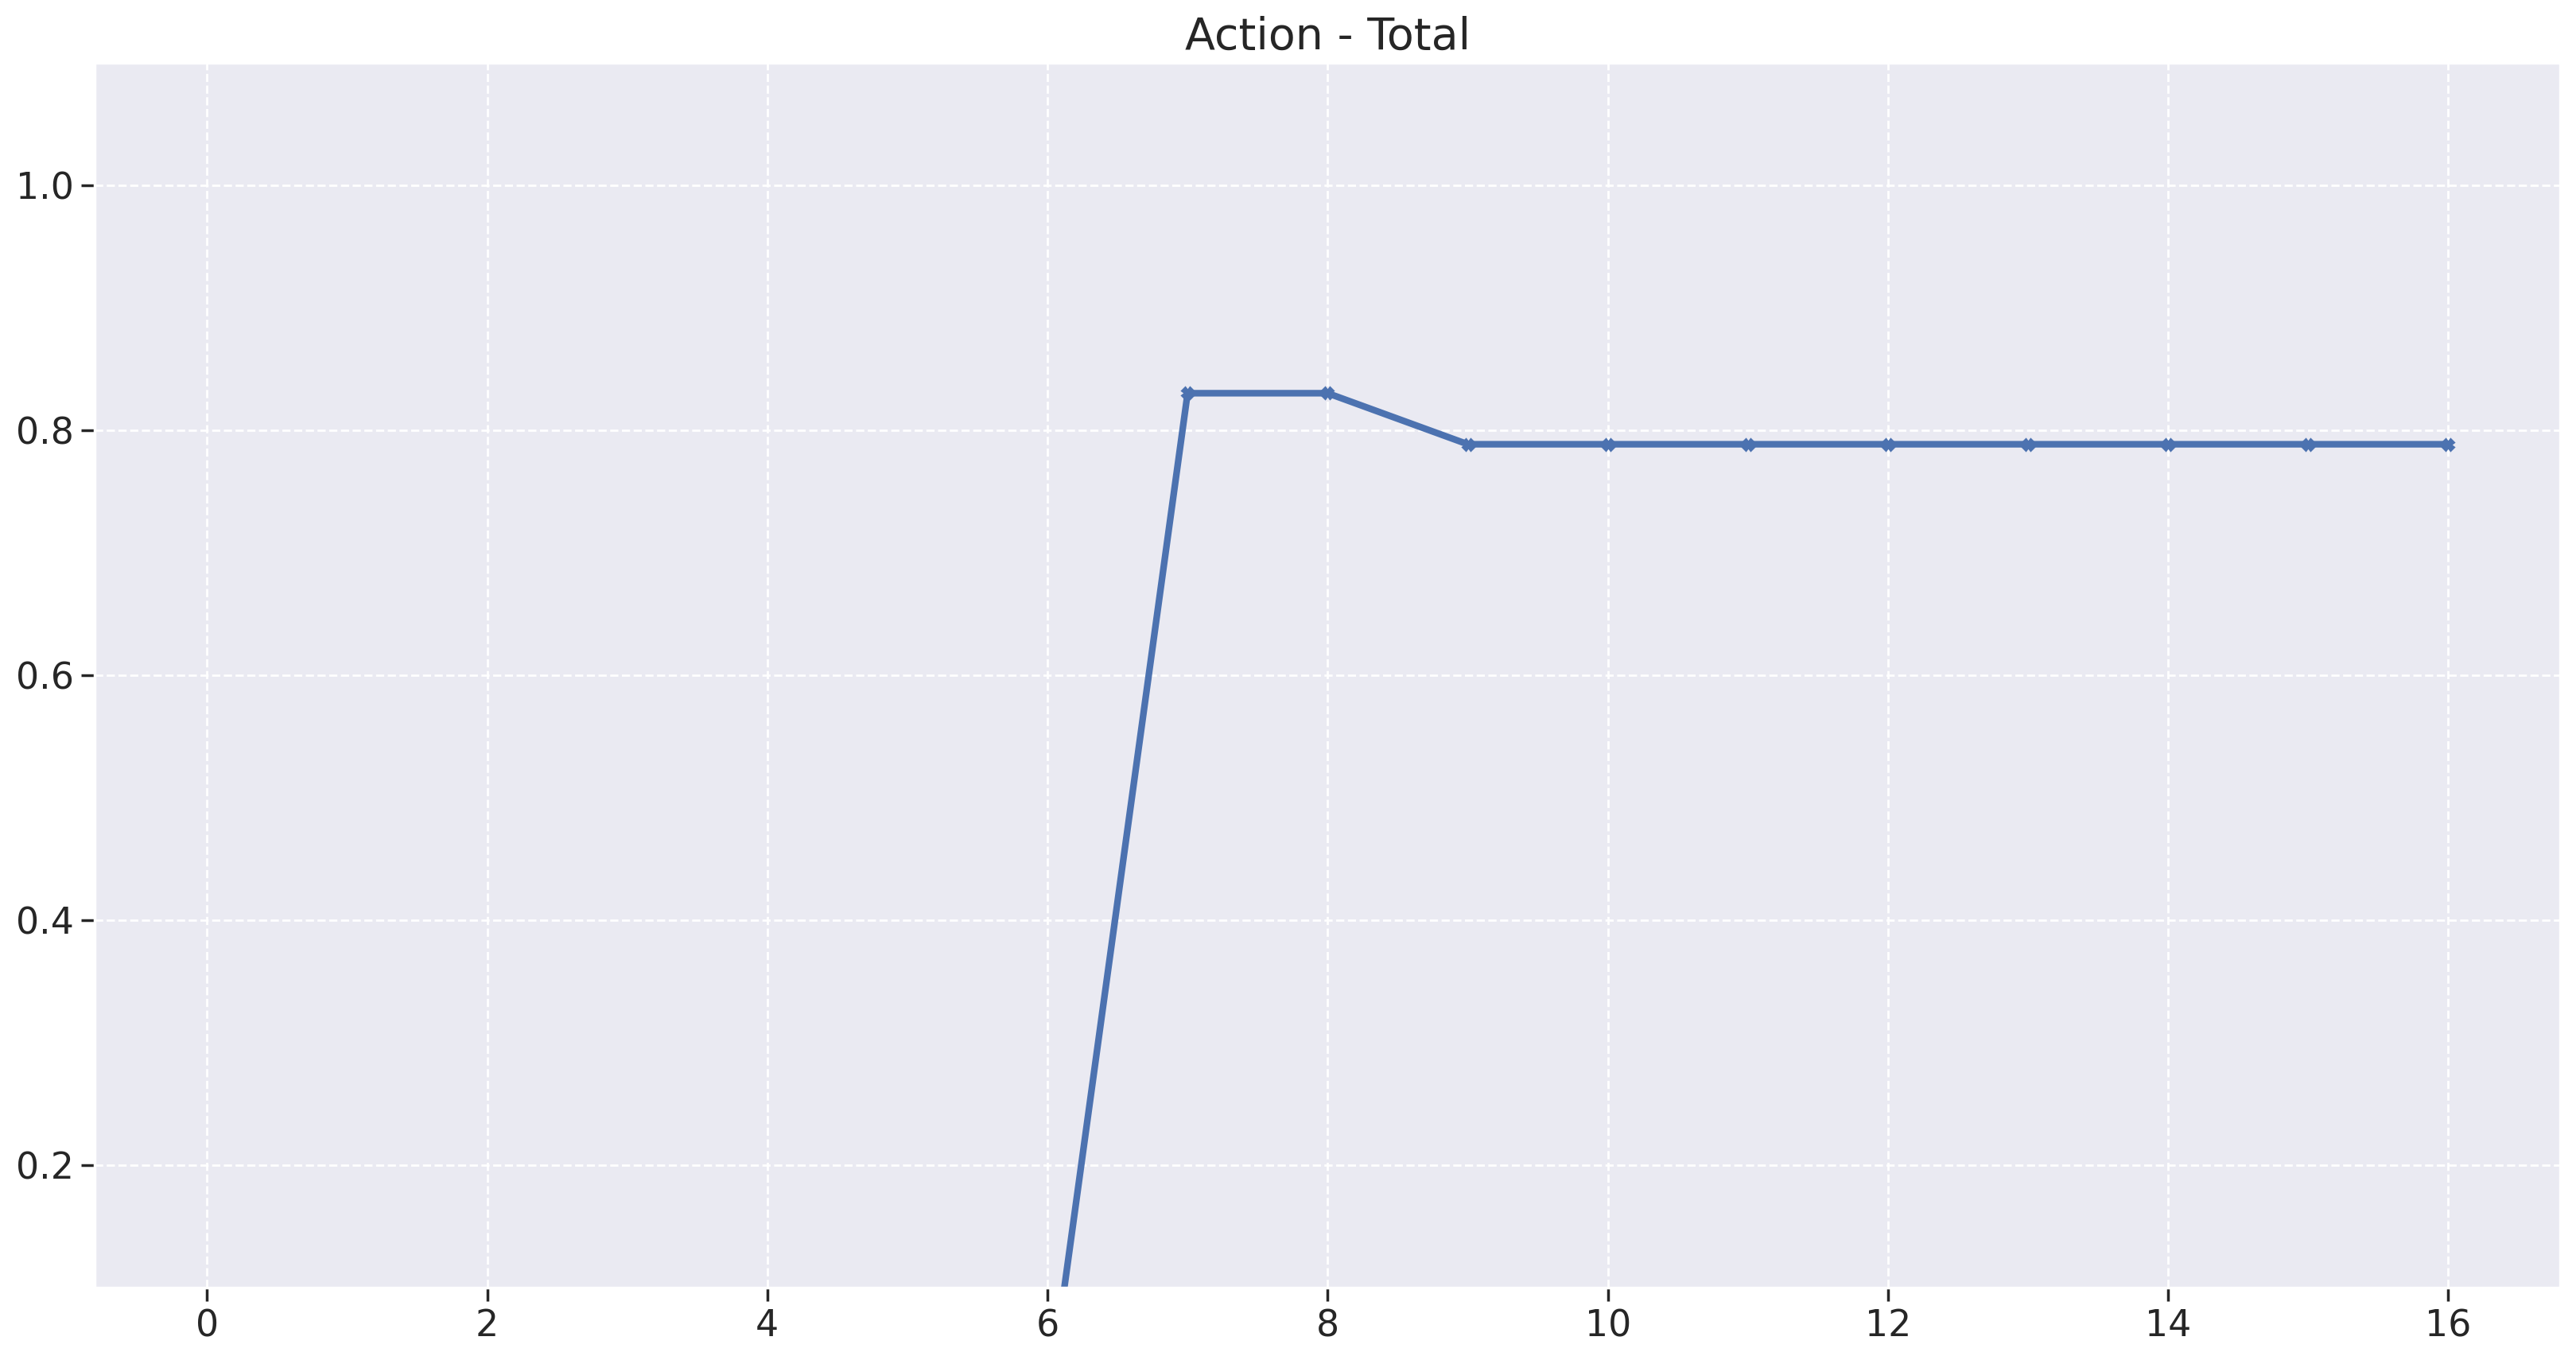

Parser
Maintainability Stats
    mean  mode  median      std      var  min  max
0.186556 0.165   0.165 0.109856 0.012068  0.0 0.33
Reliability Stats
    mean  mode  median      std      var  min  max
0.395161   0.5     0.5 0.201806 0.040726  0.0  0.5


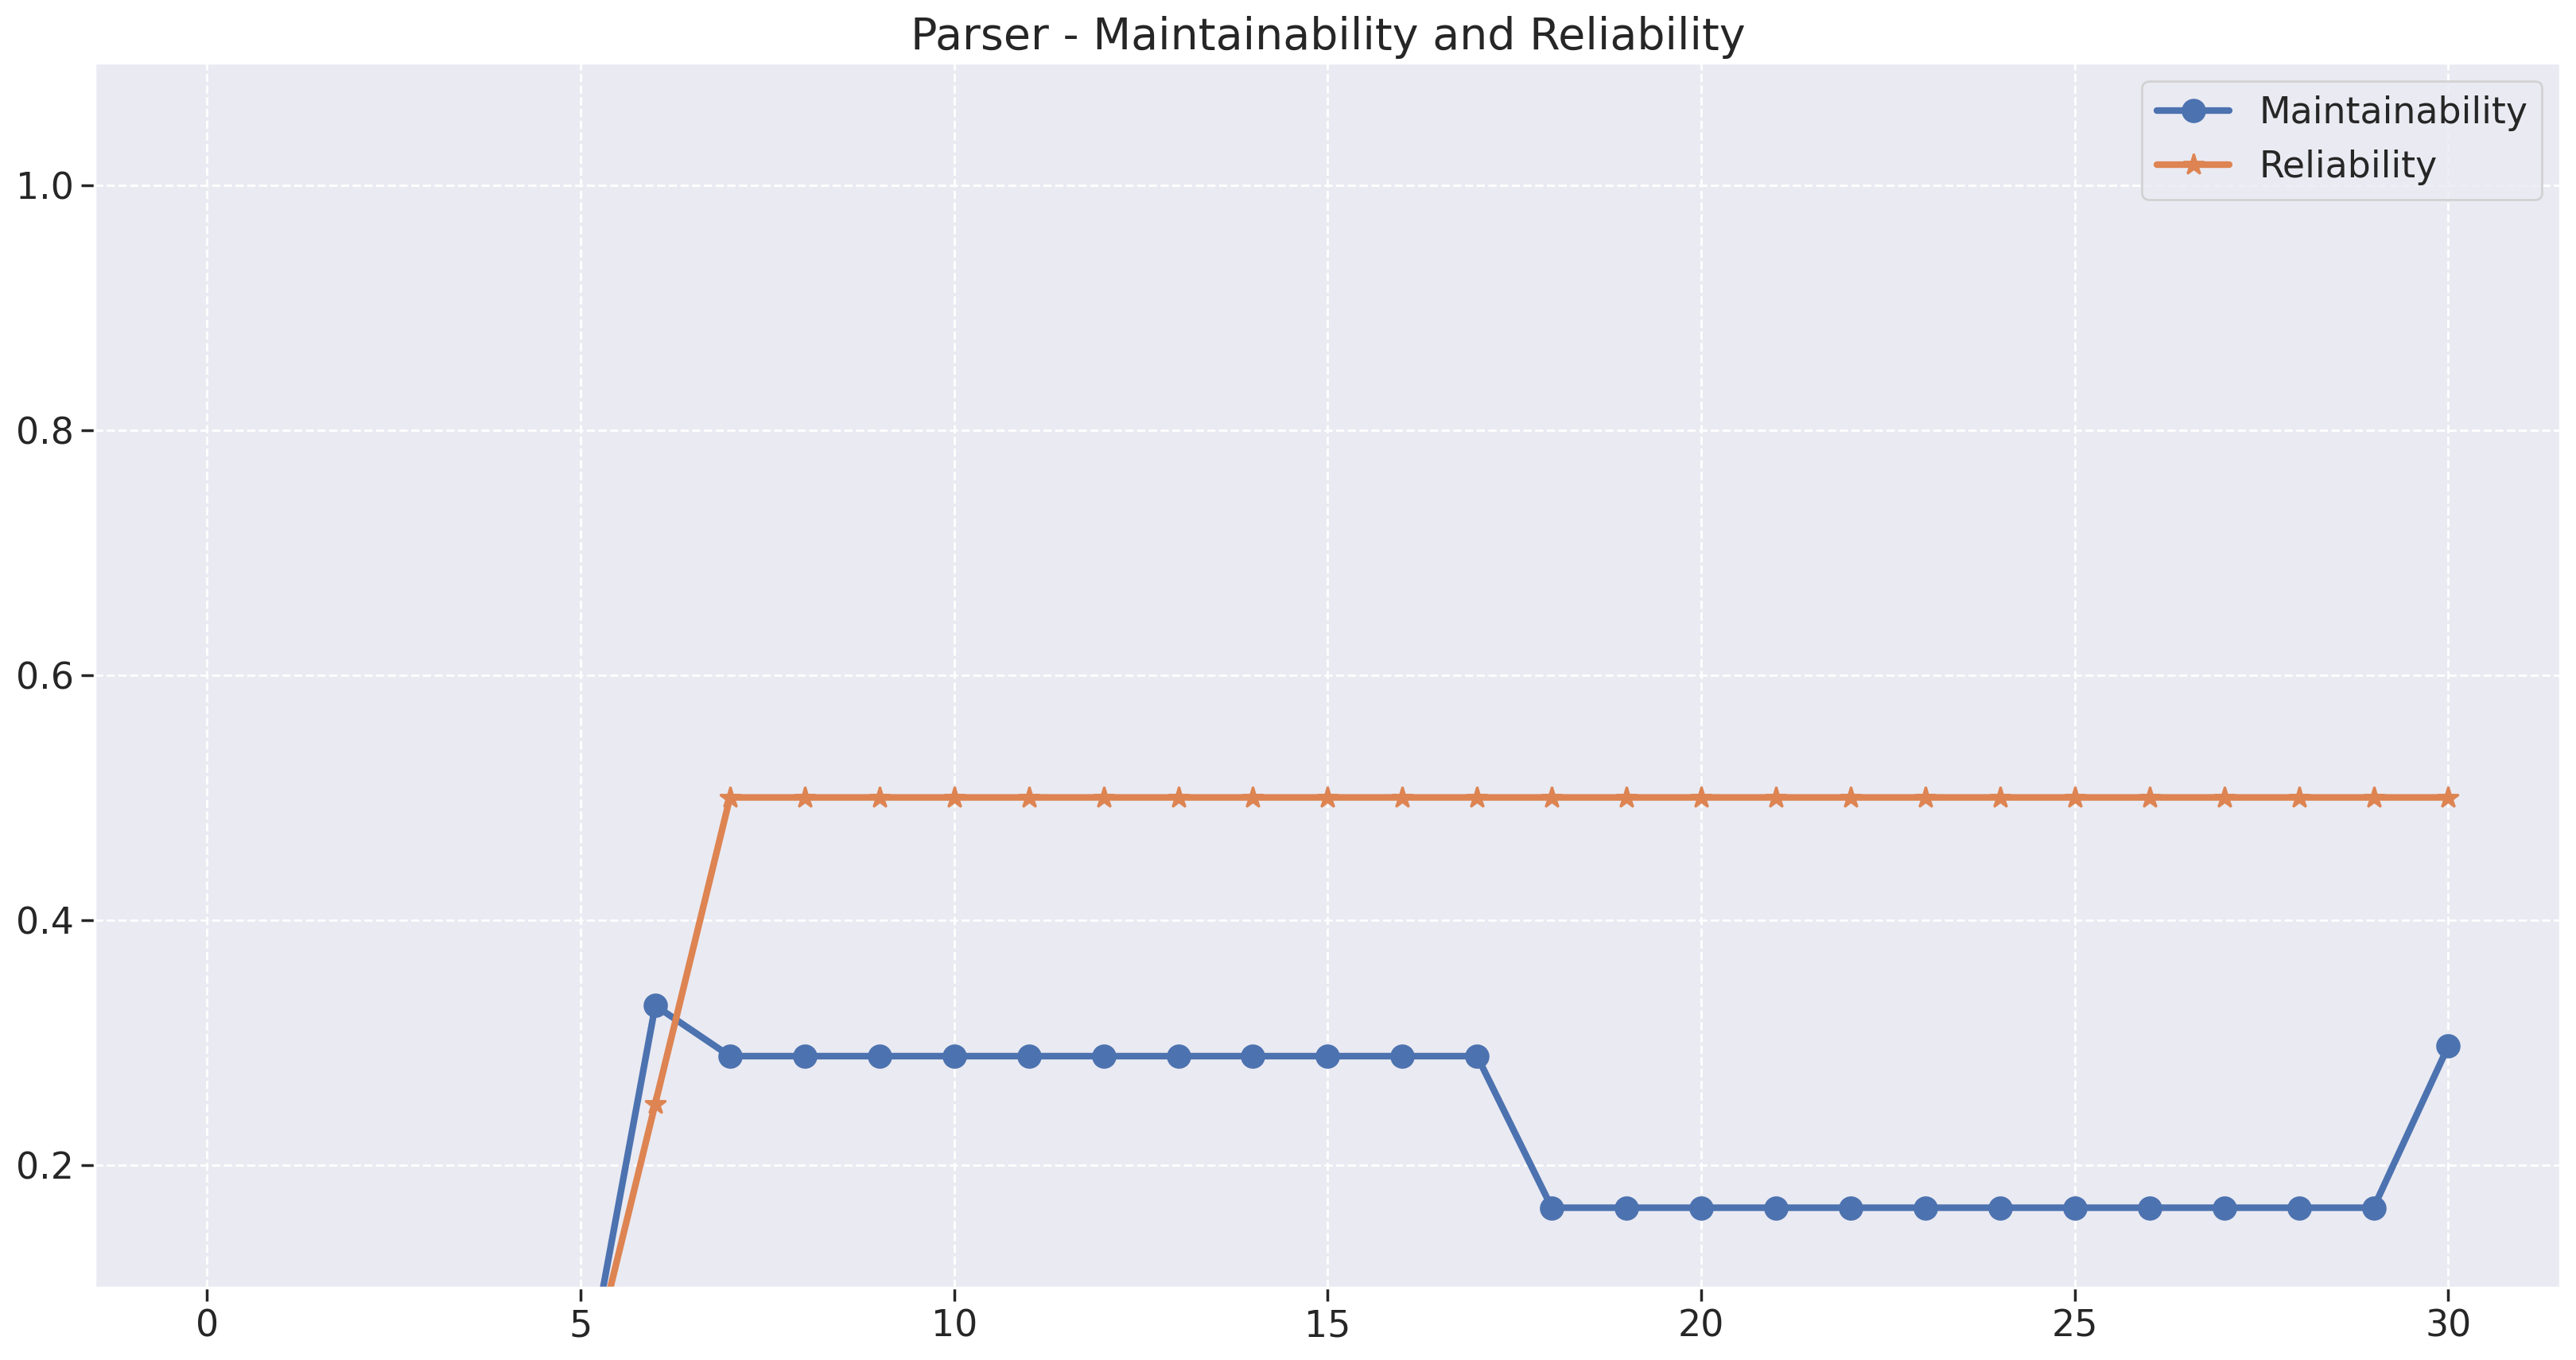

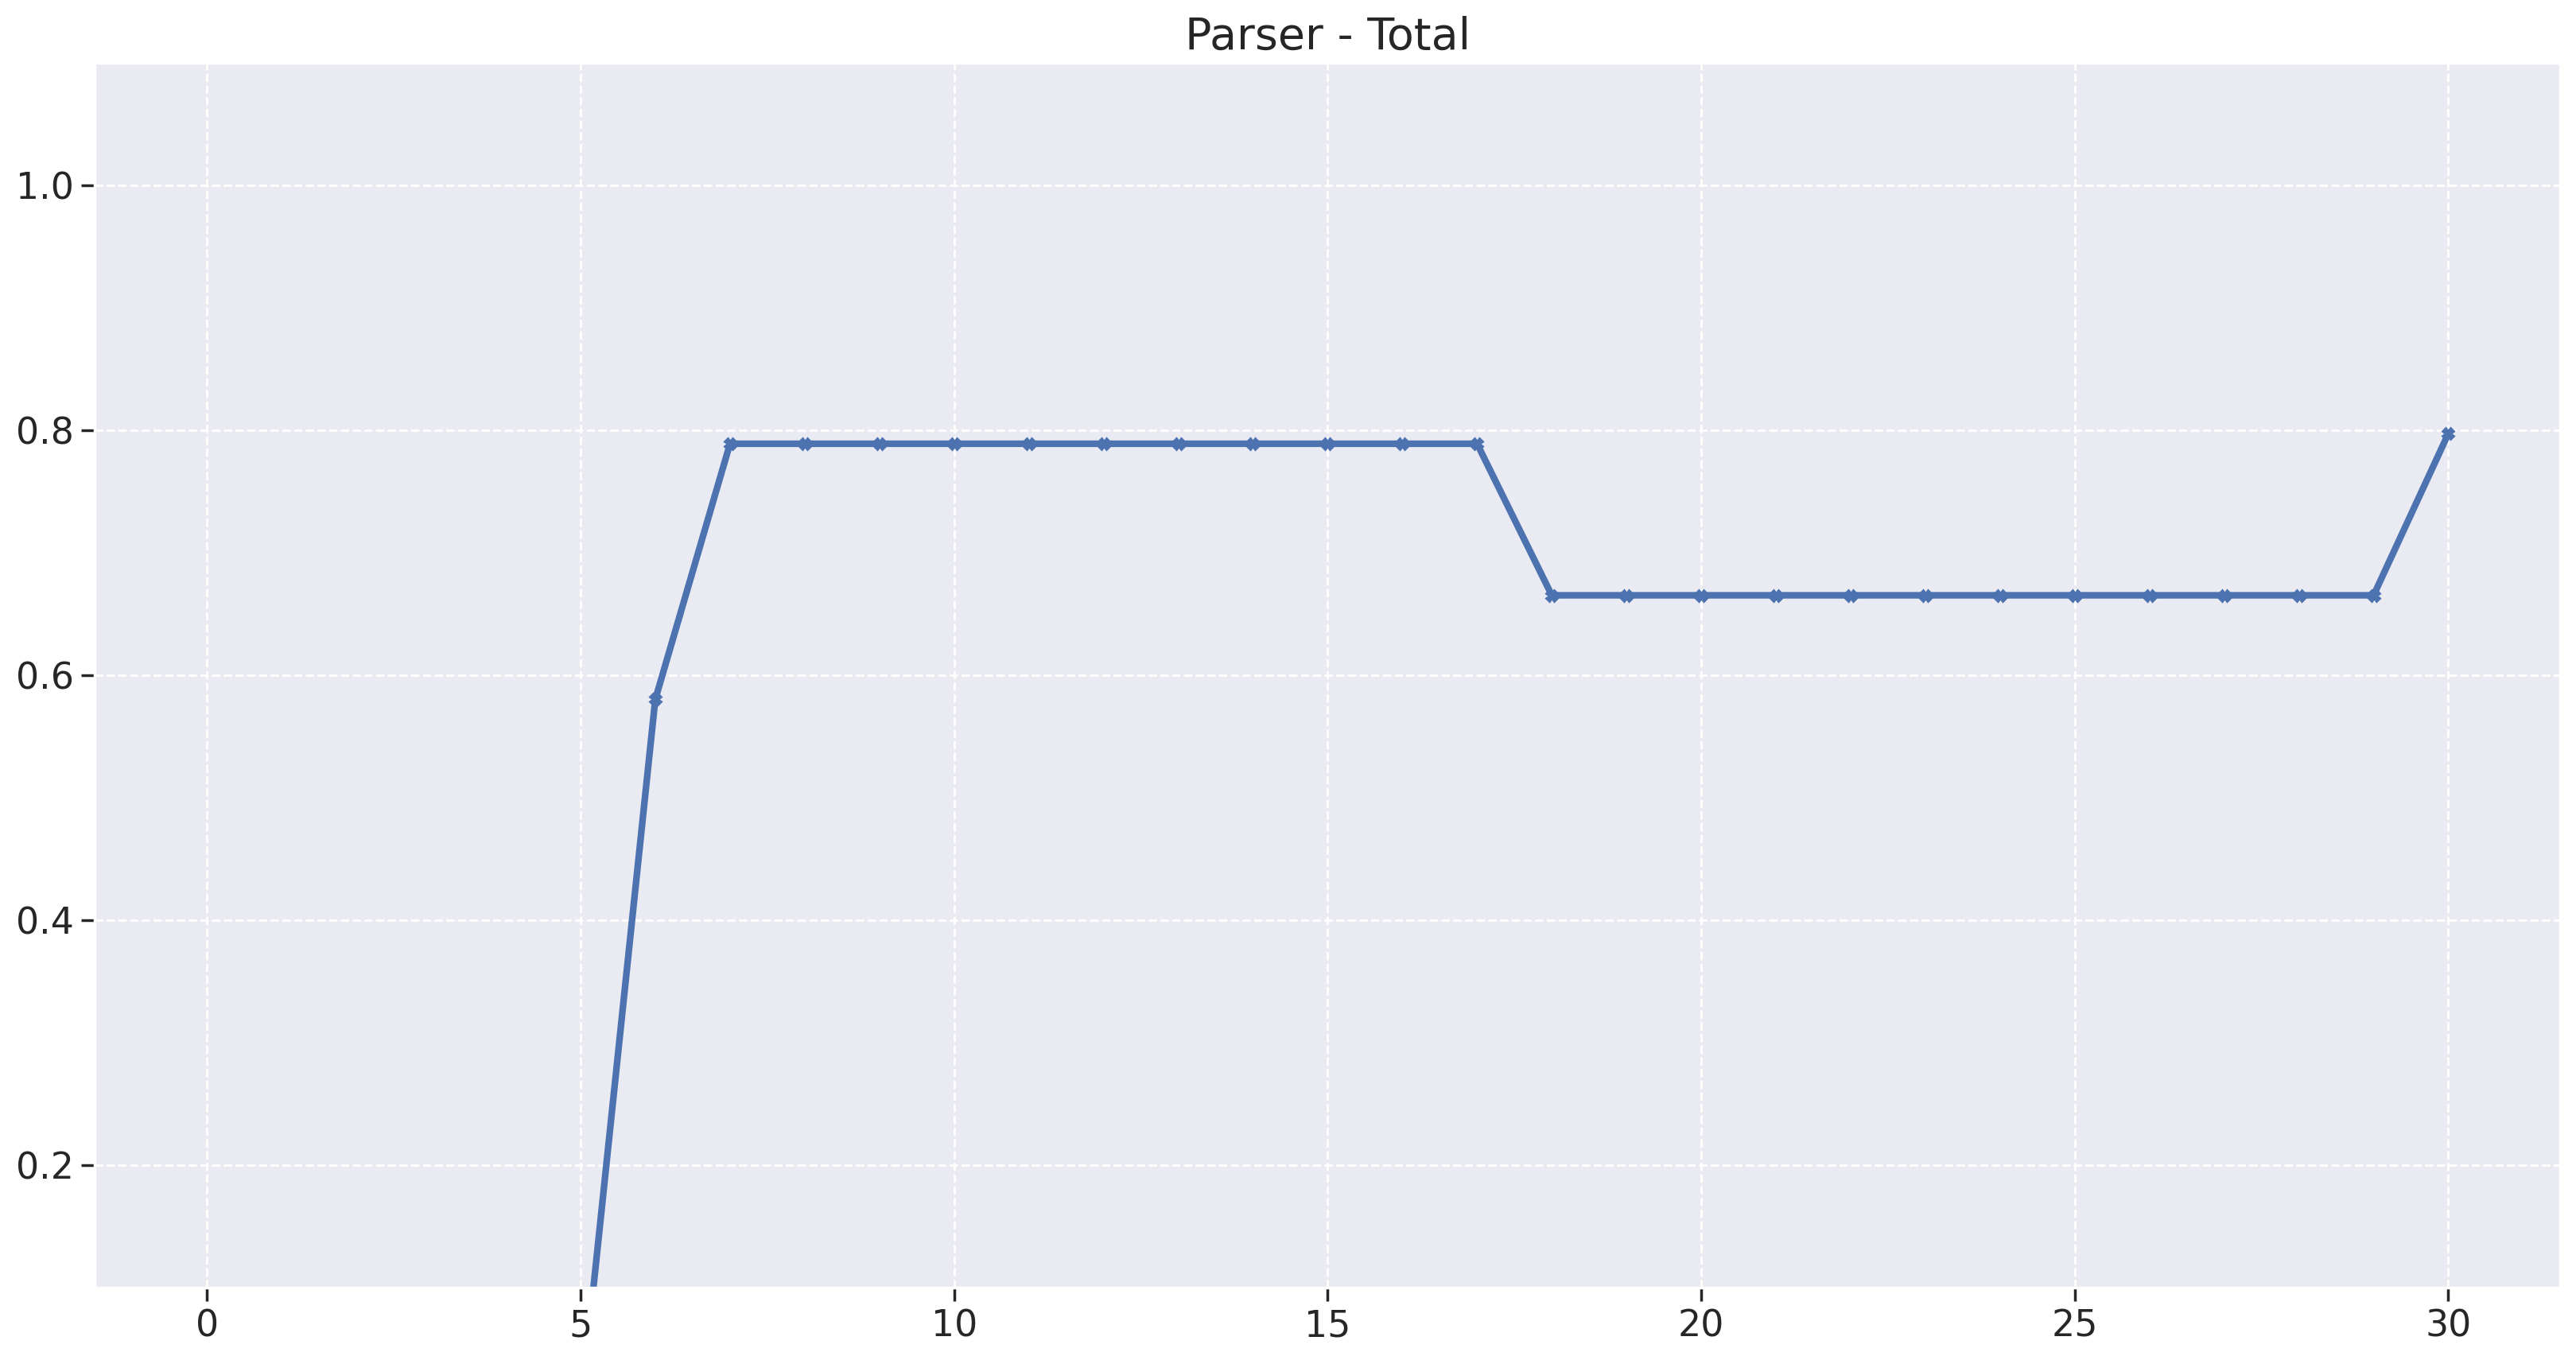

In [30]:
for name, data in metrics.items():
    print(name)
    analysis(data, name)

### Quality characteristic indicator

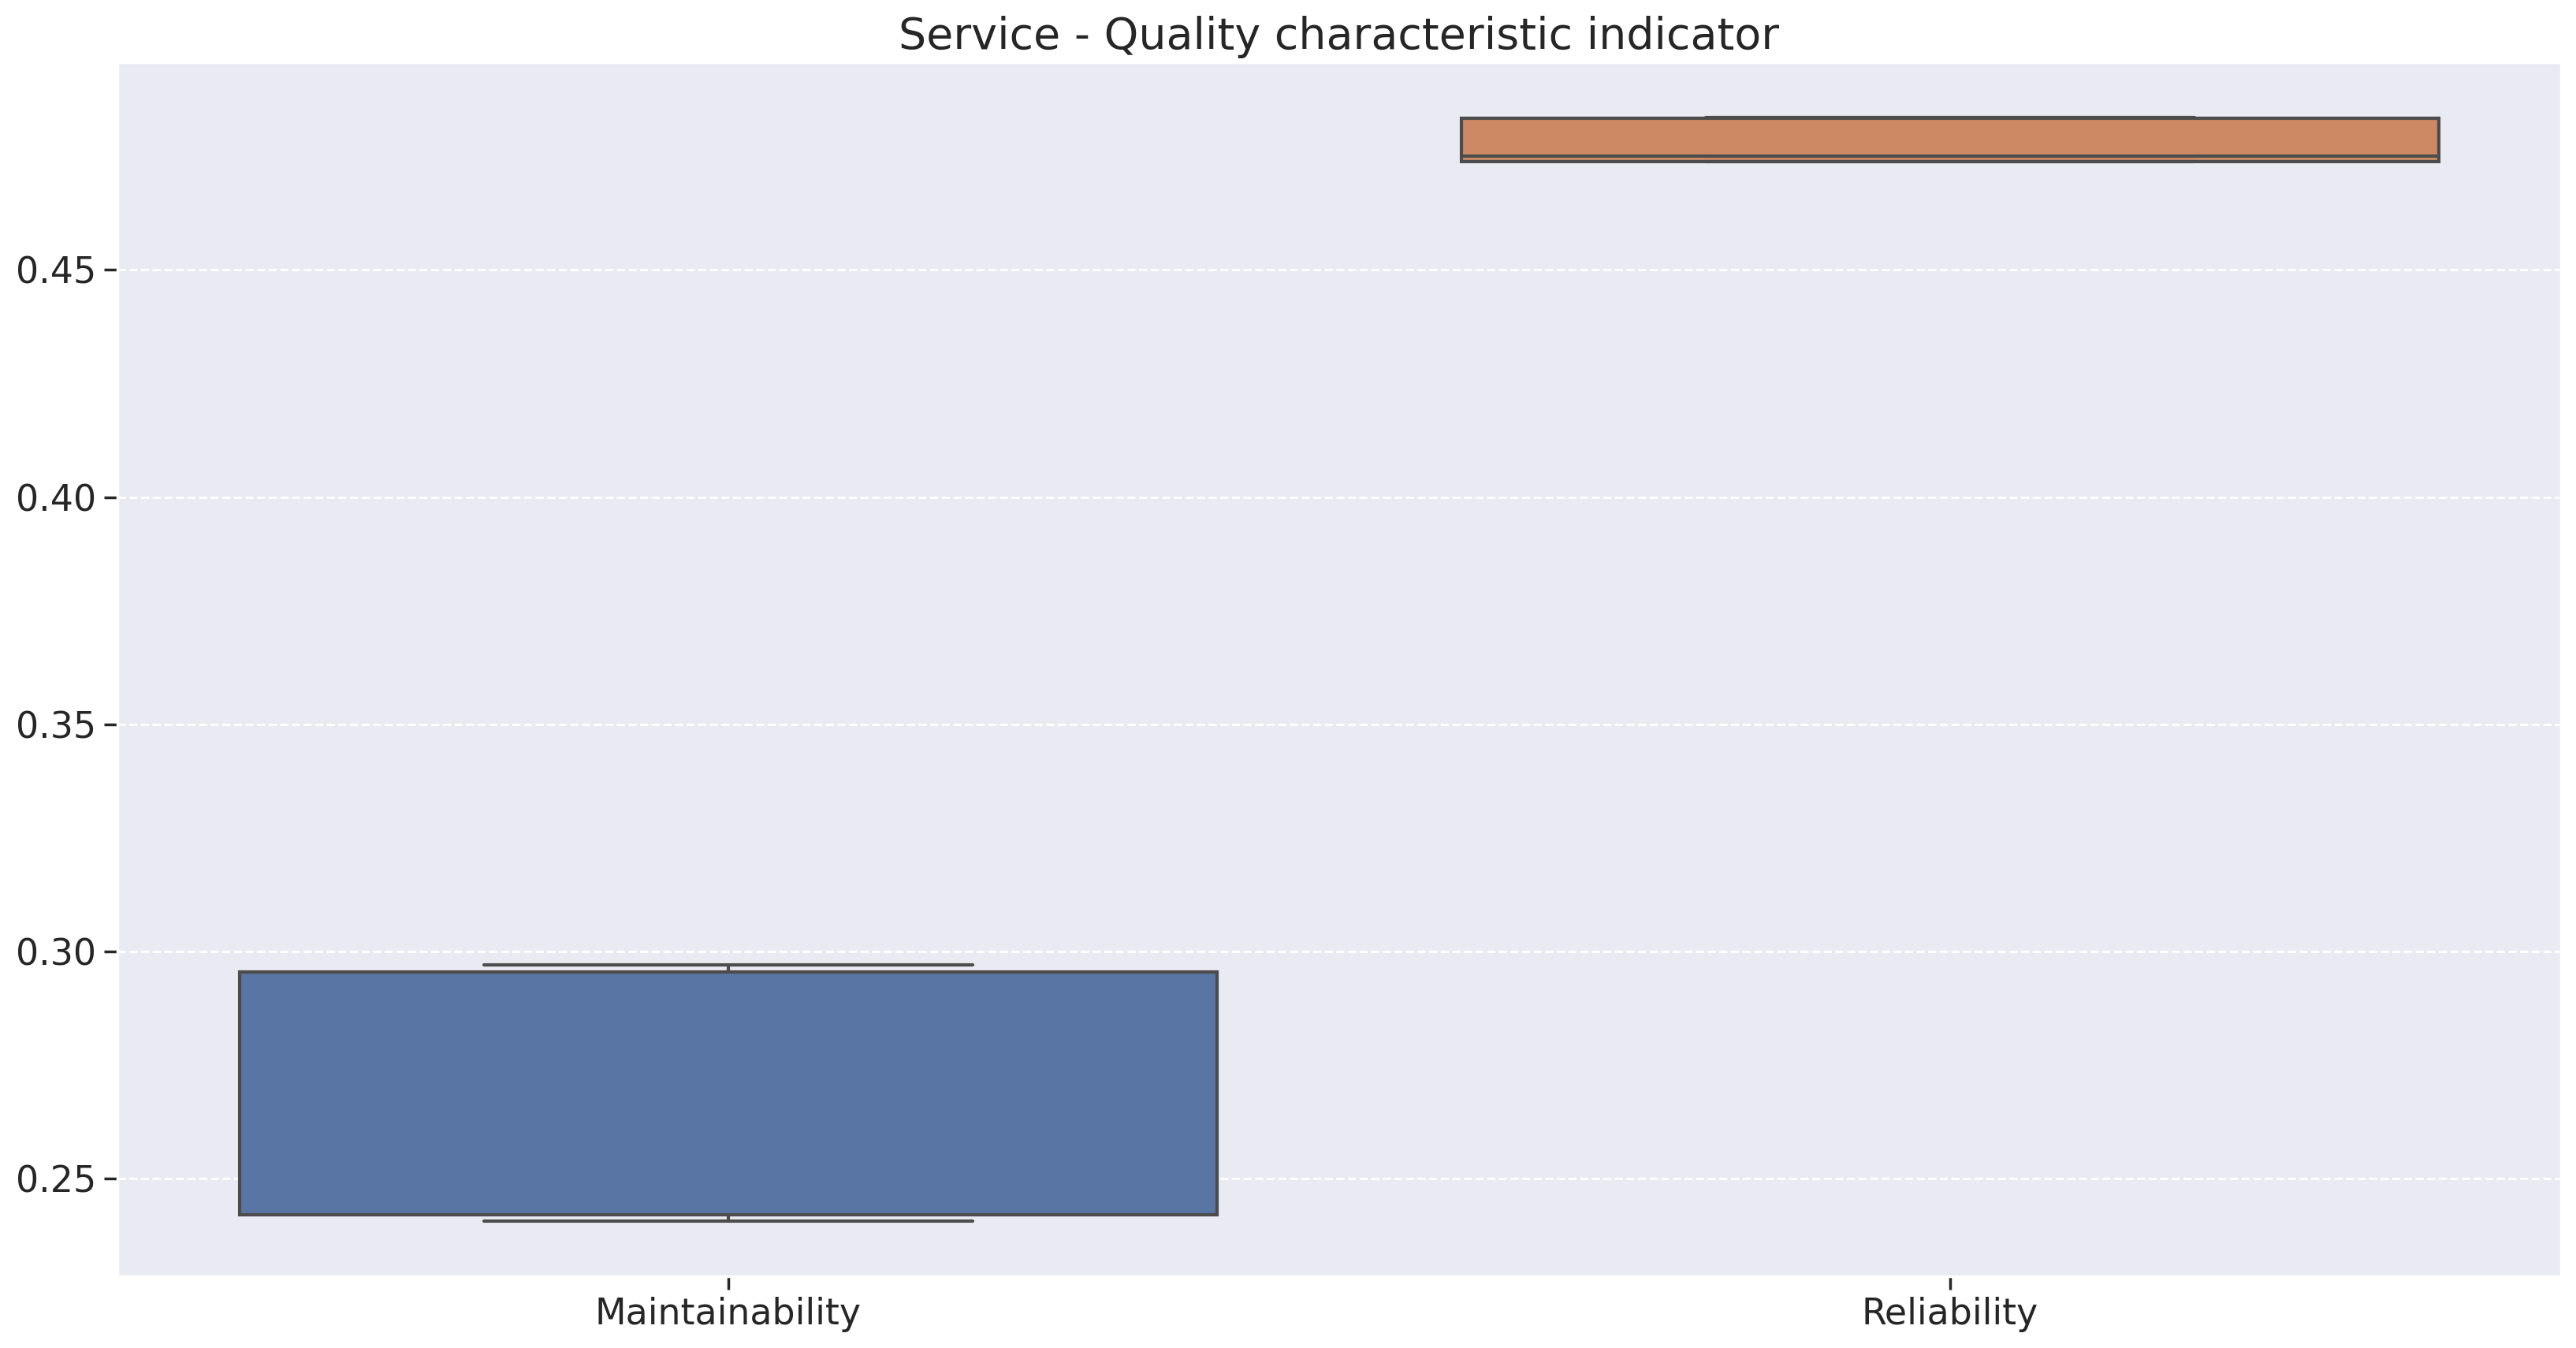

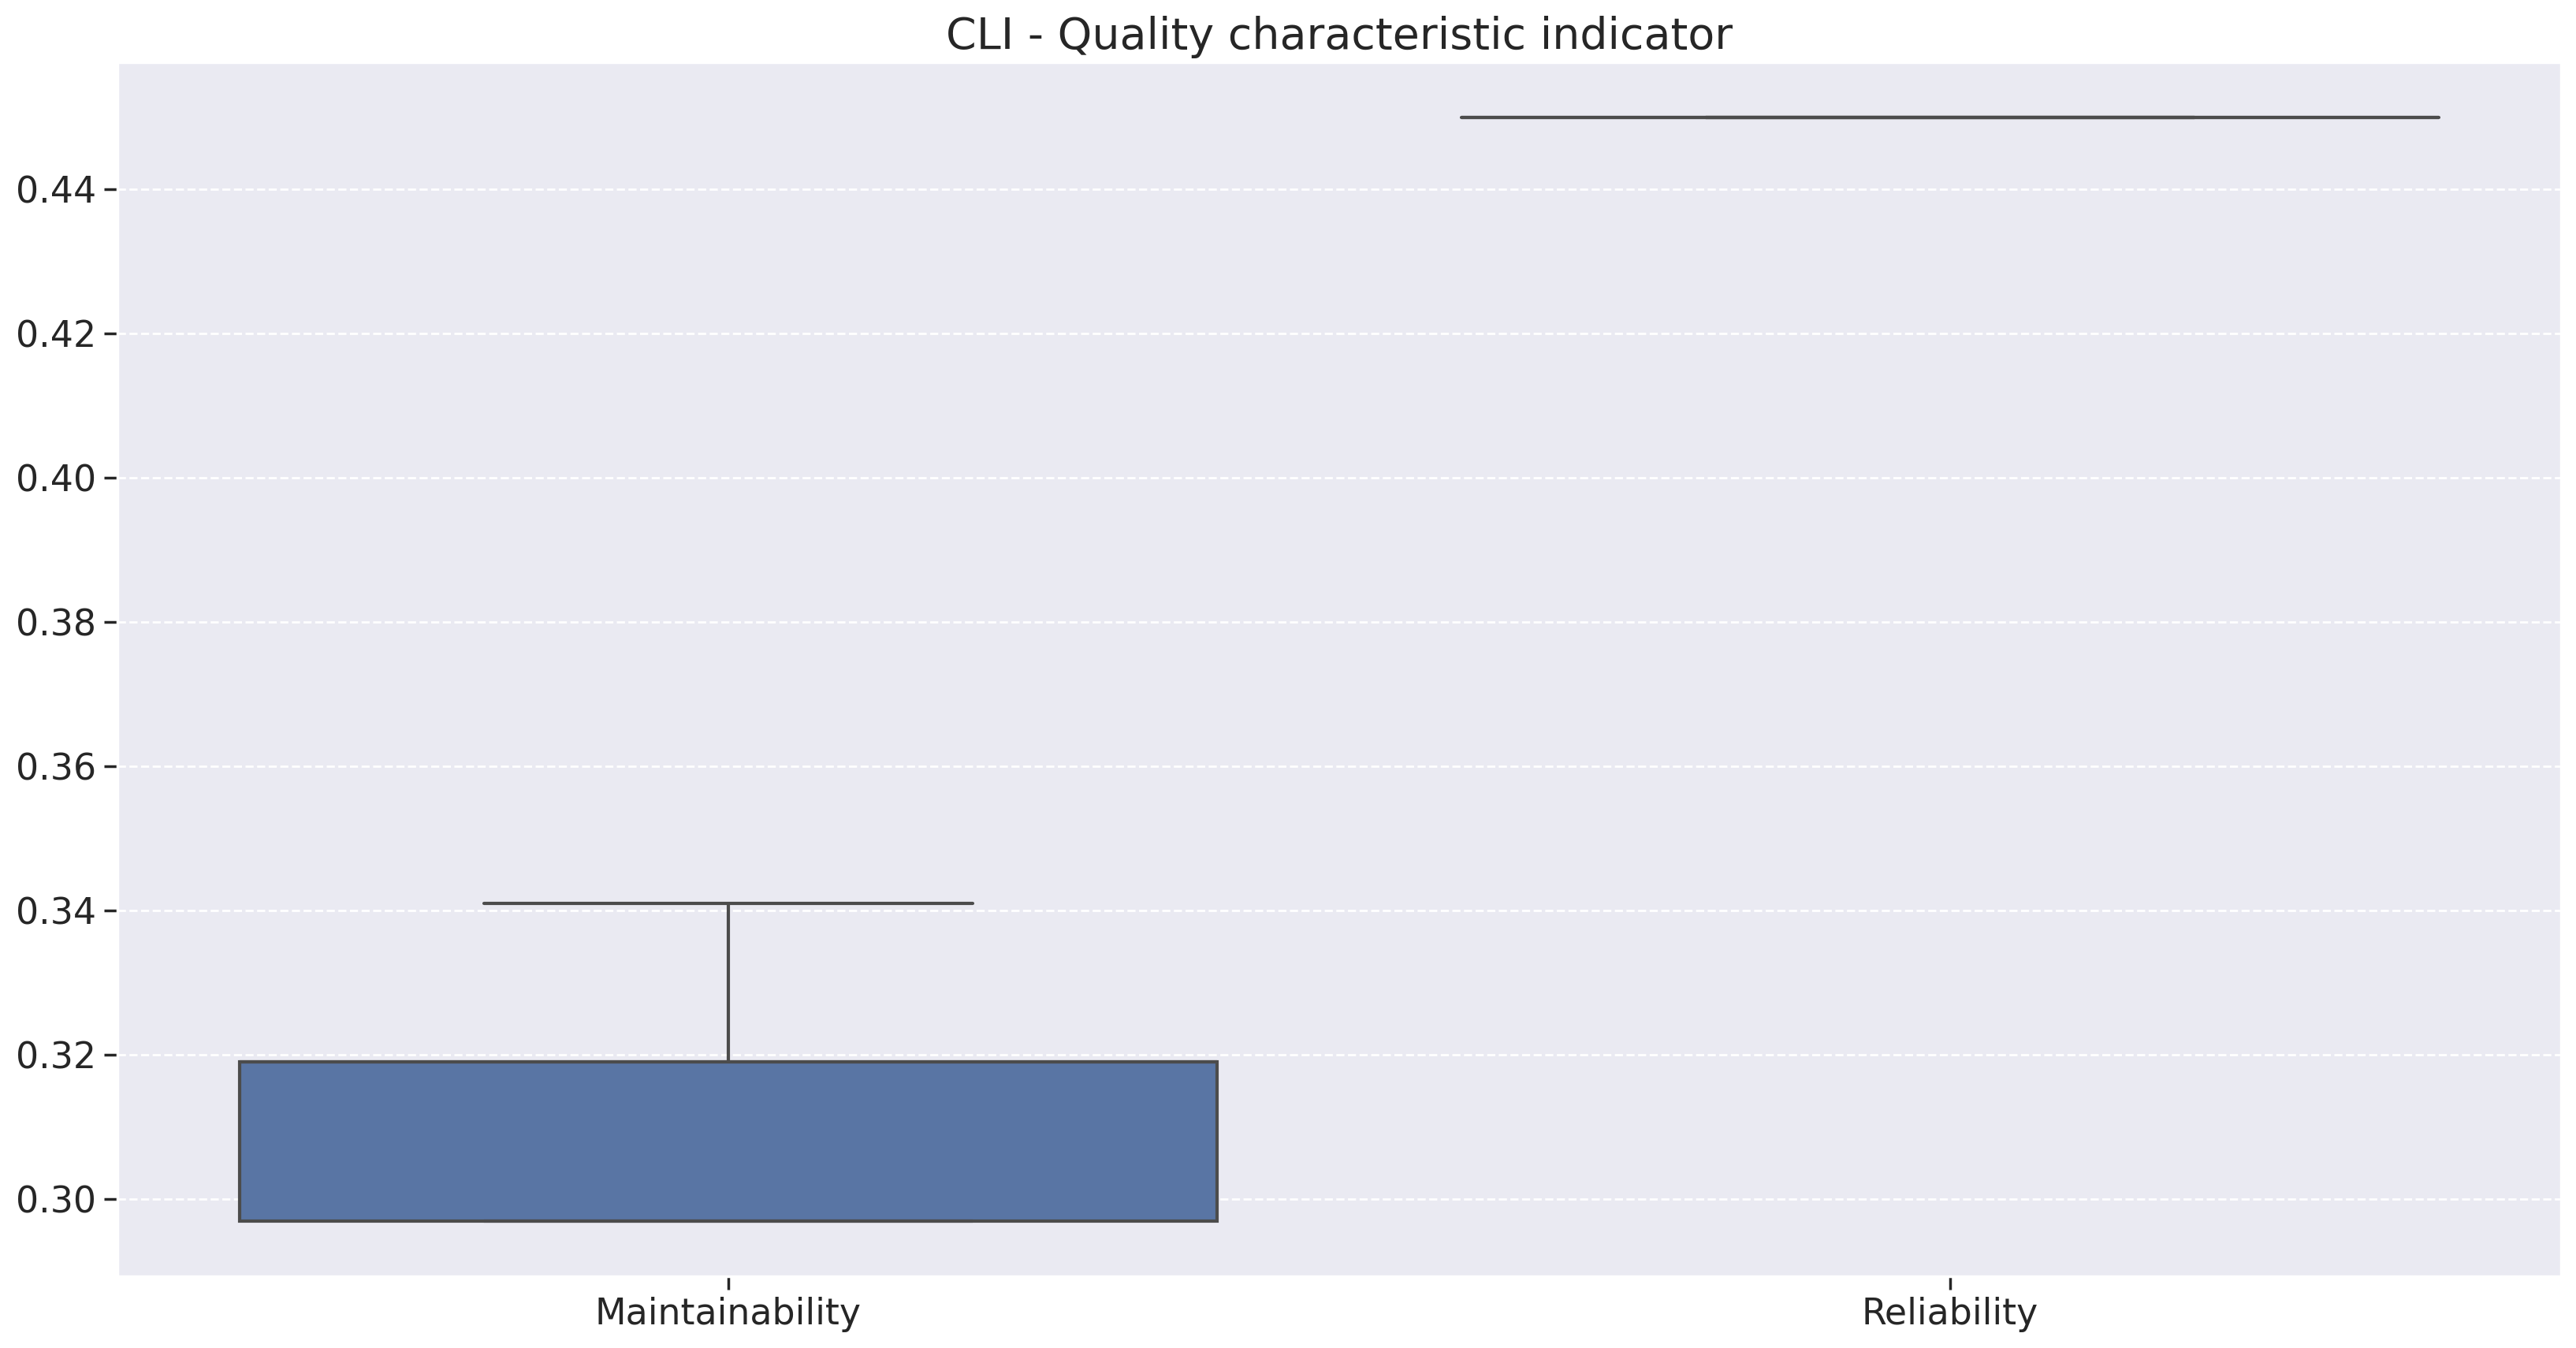

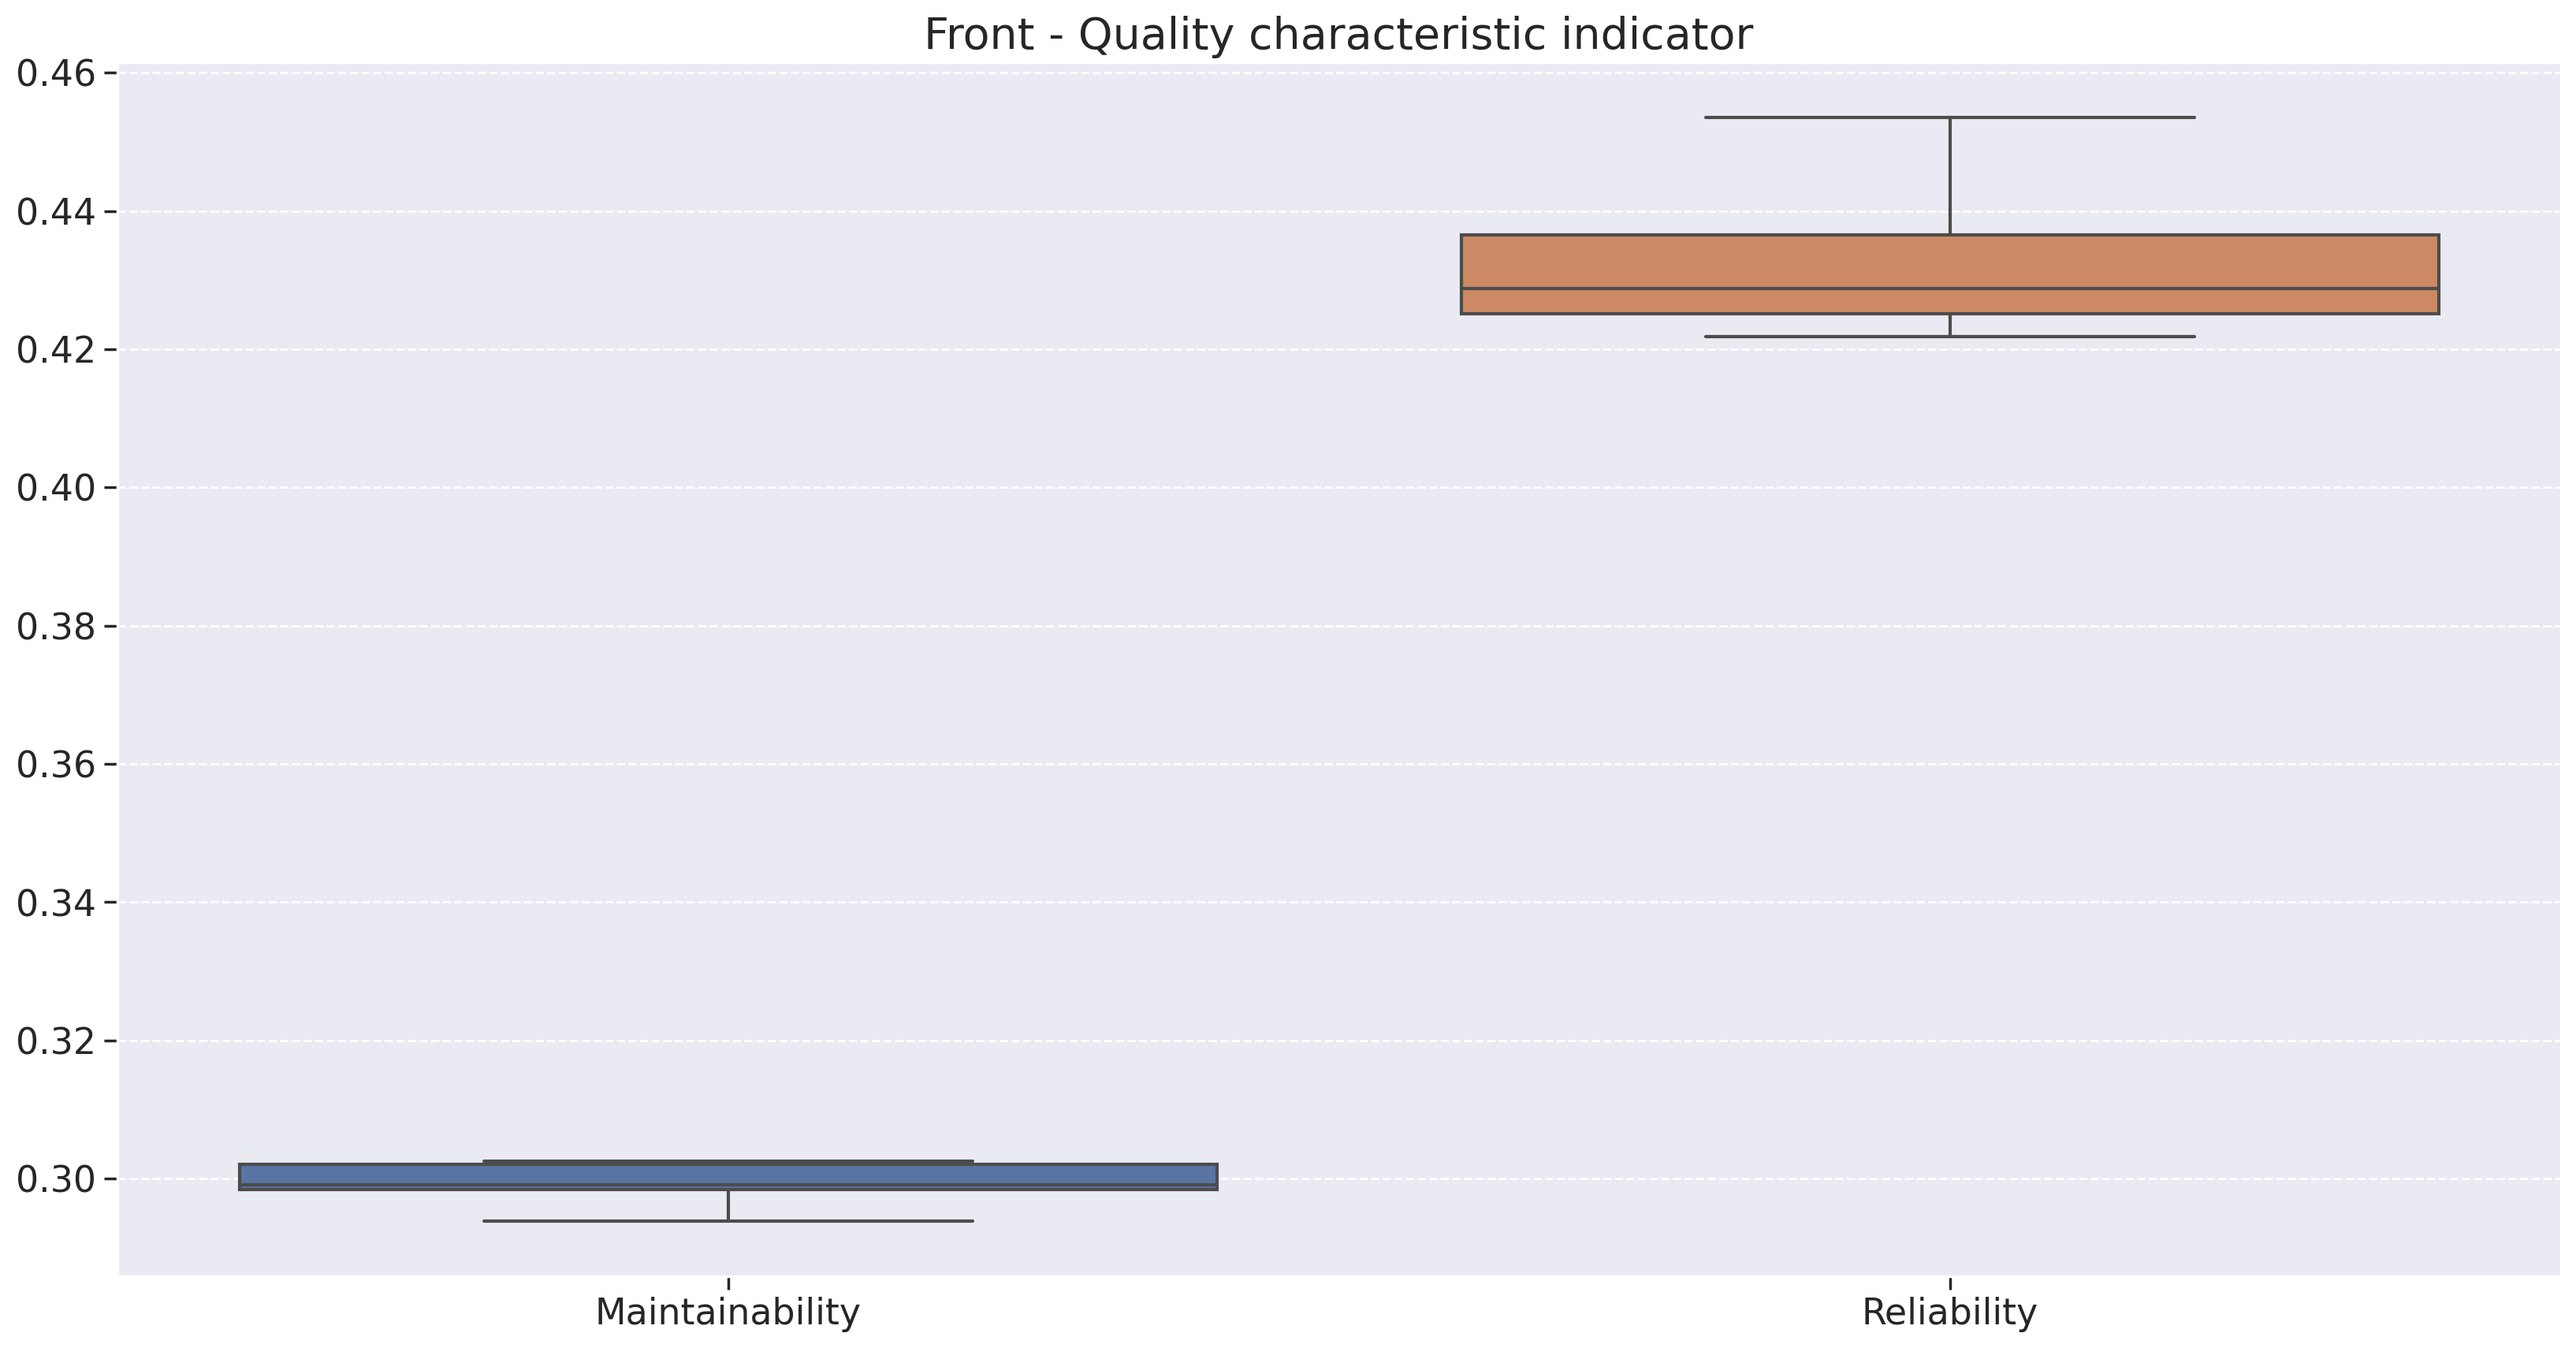

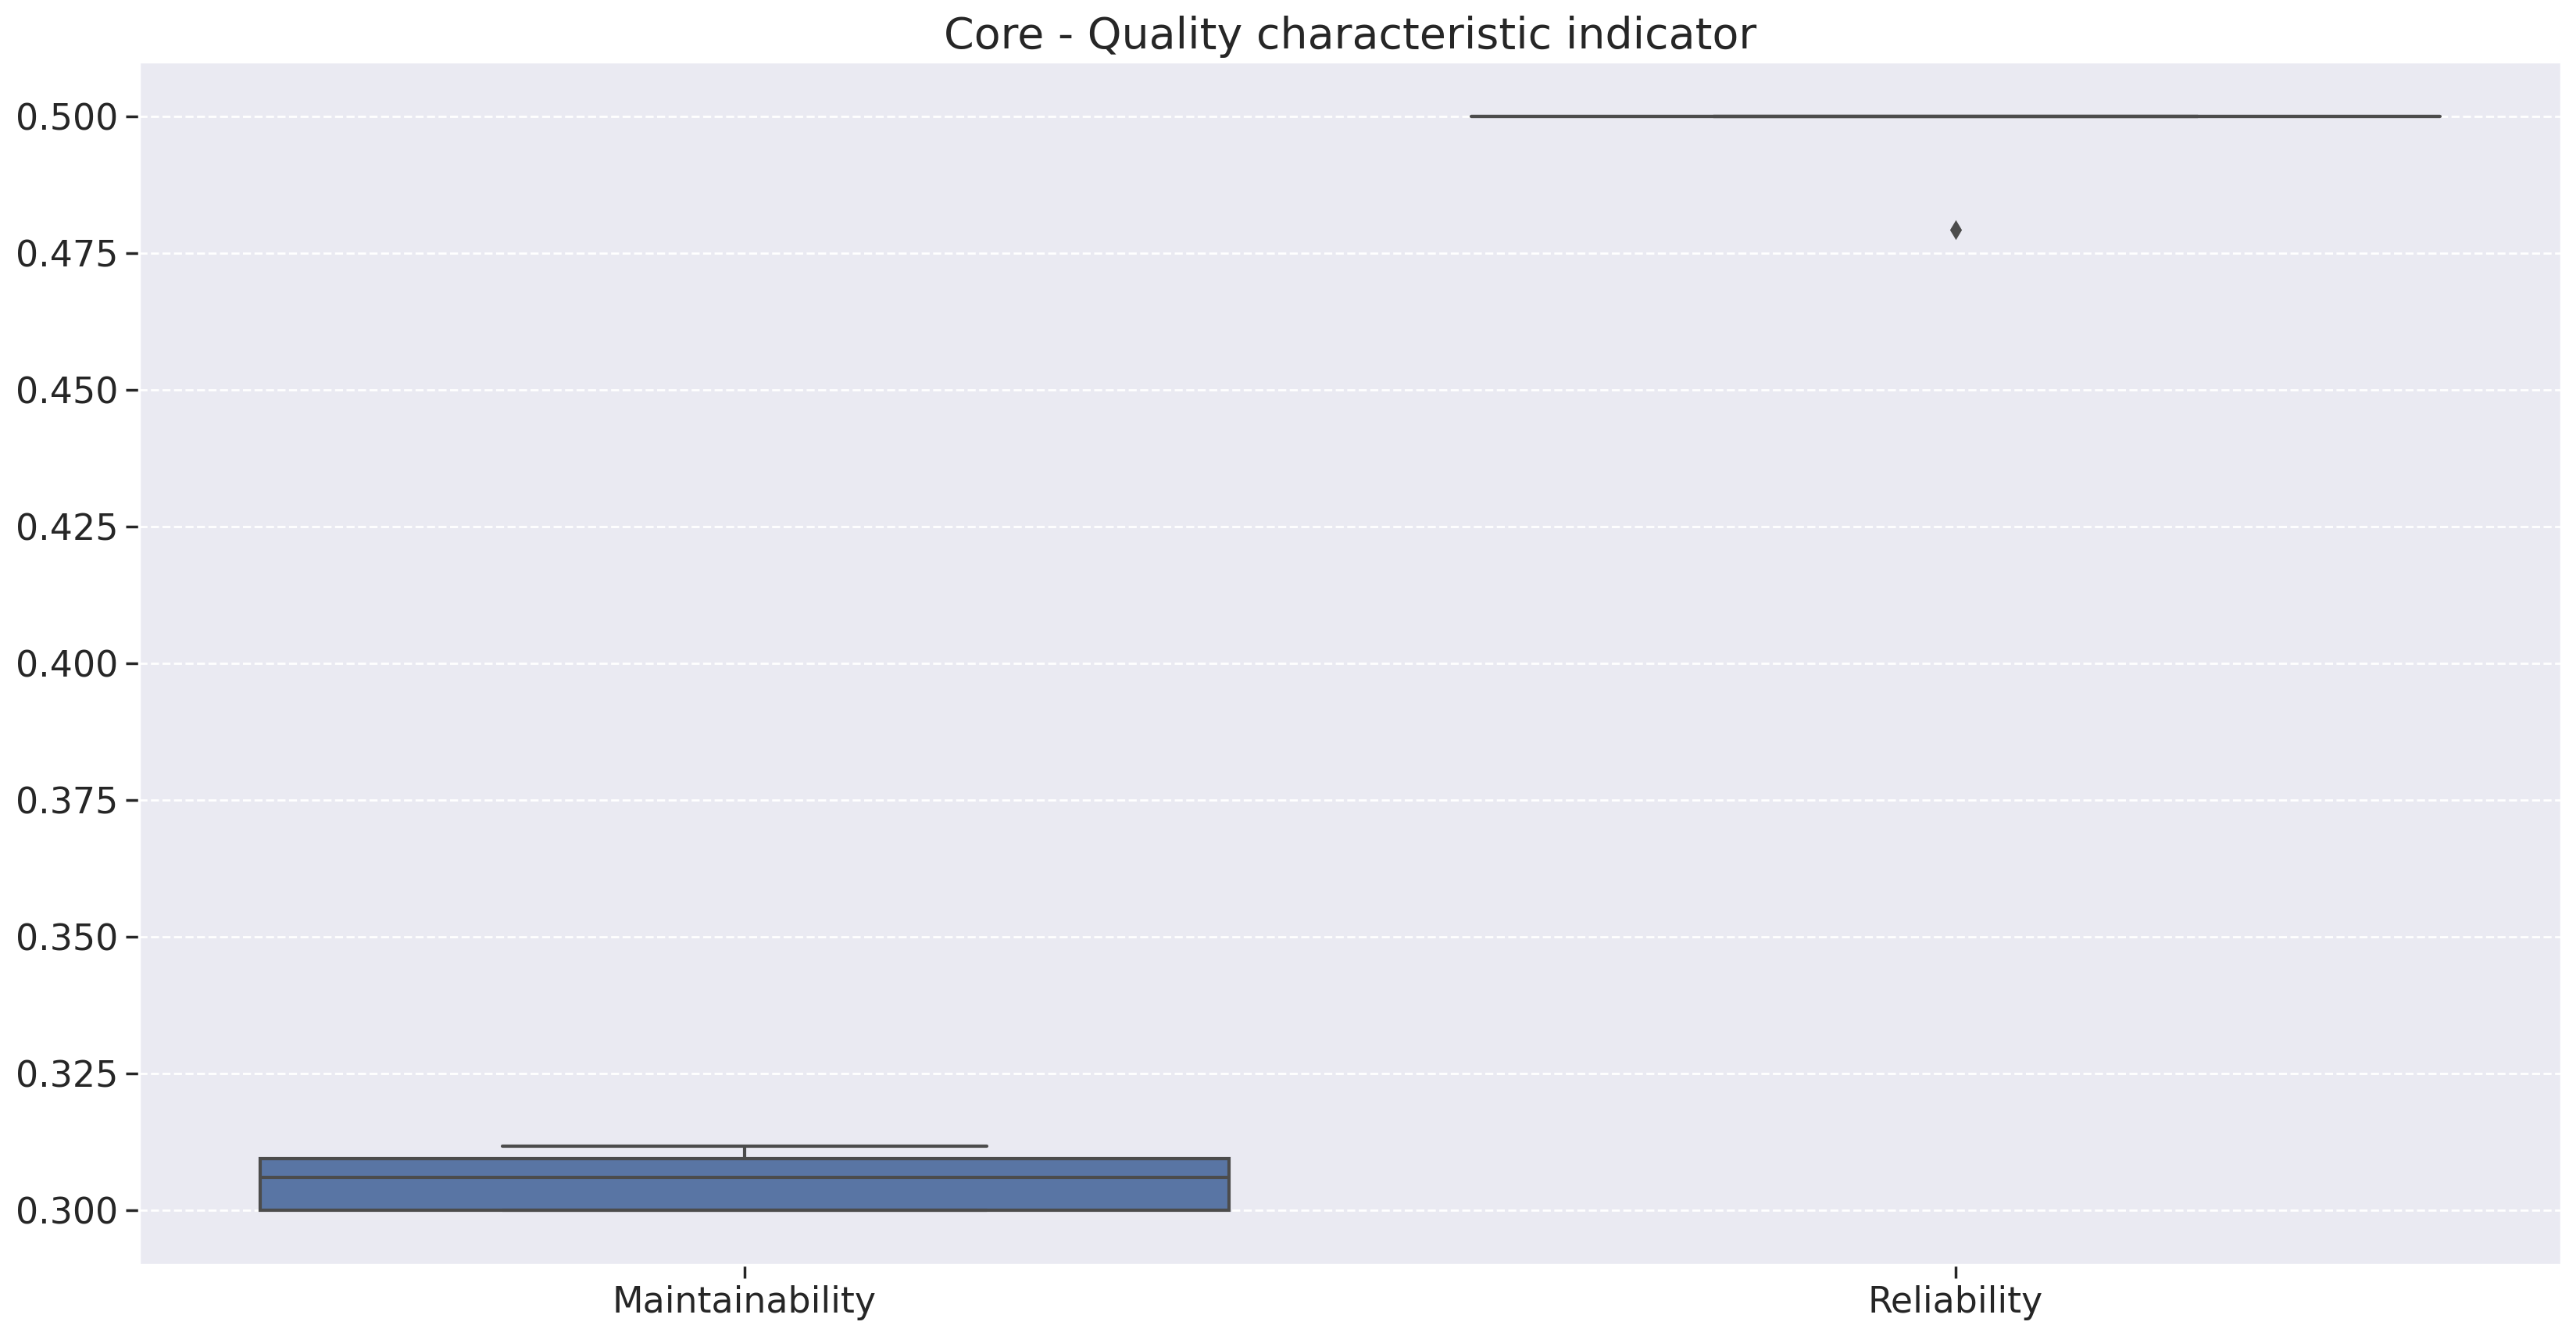

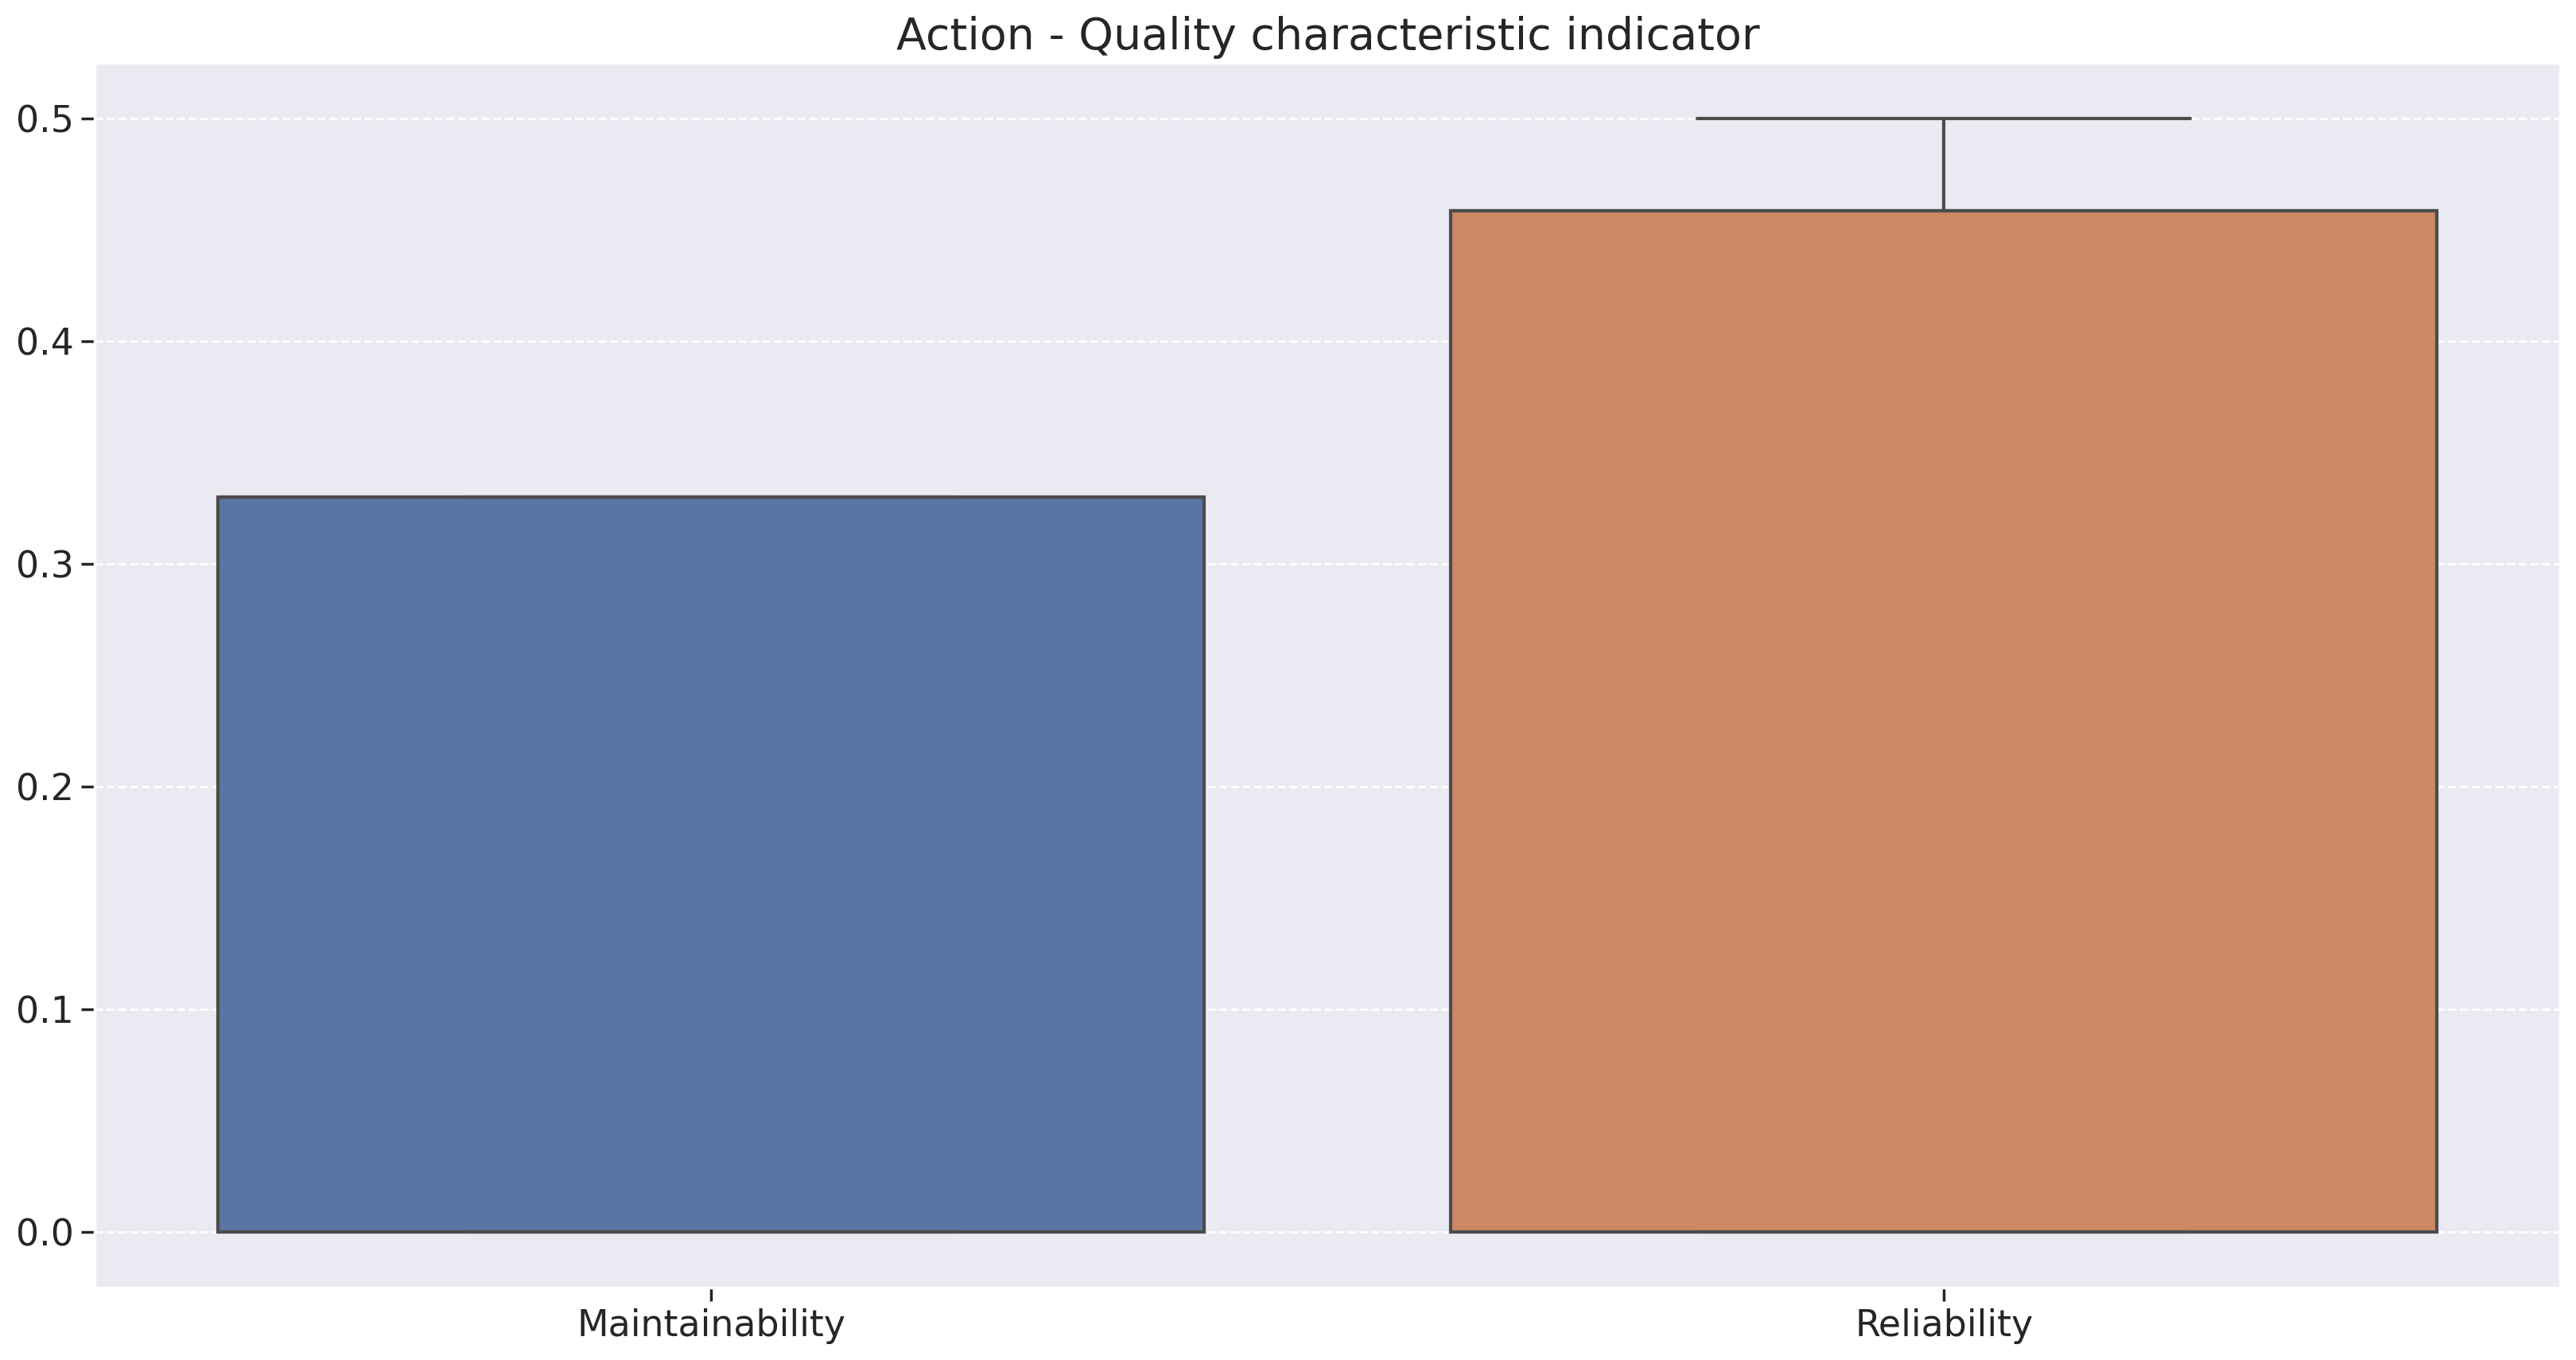

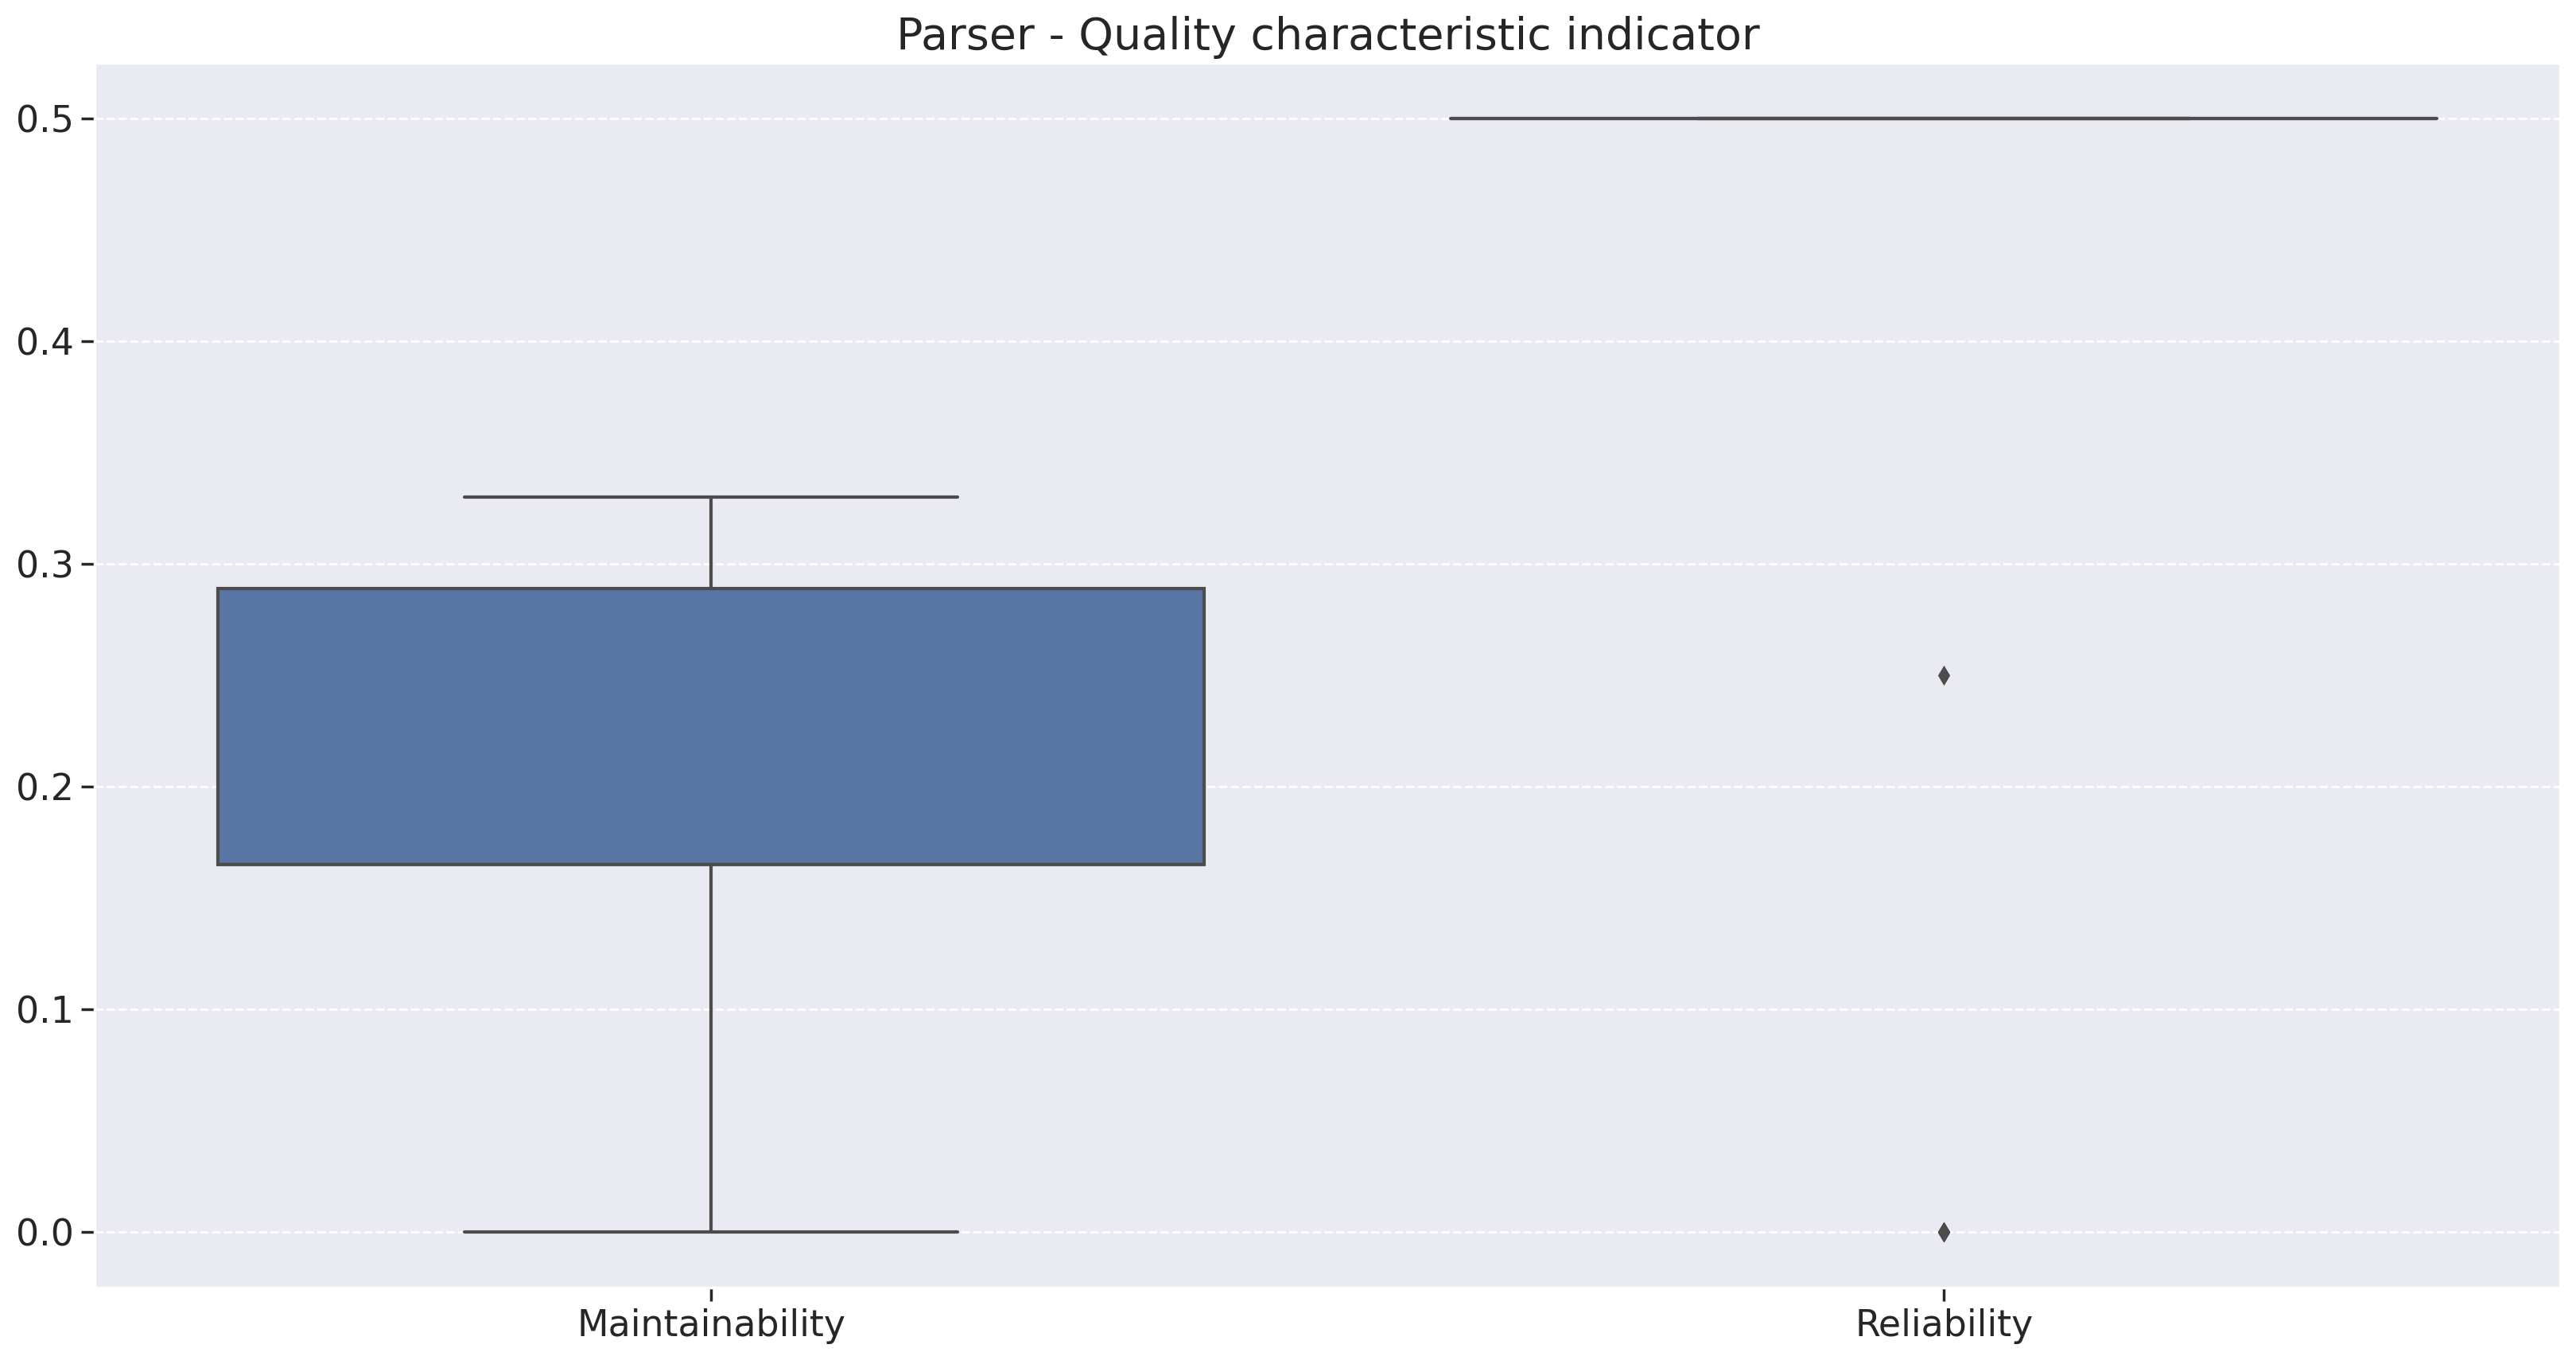

In [31]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

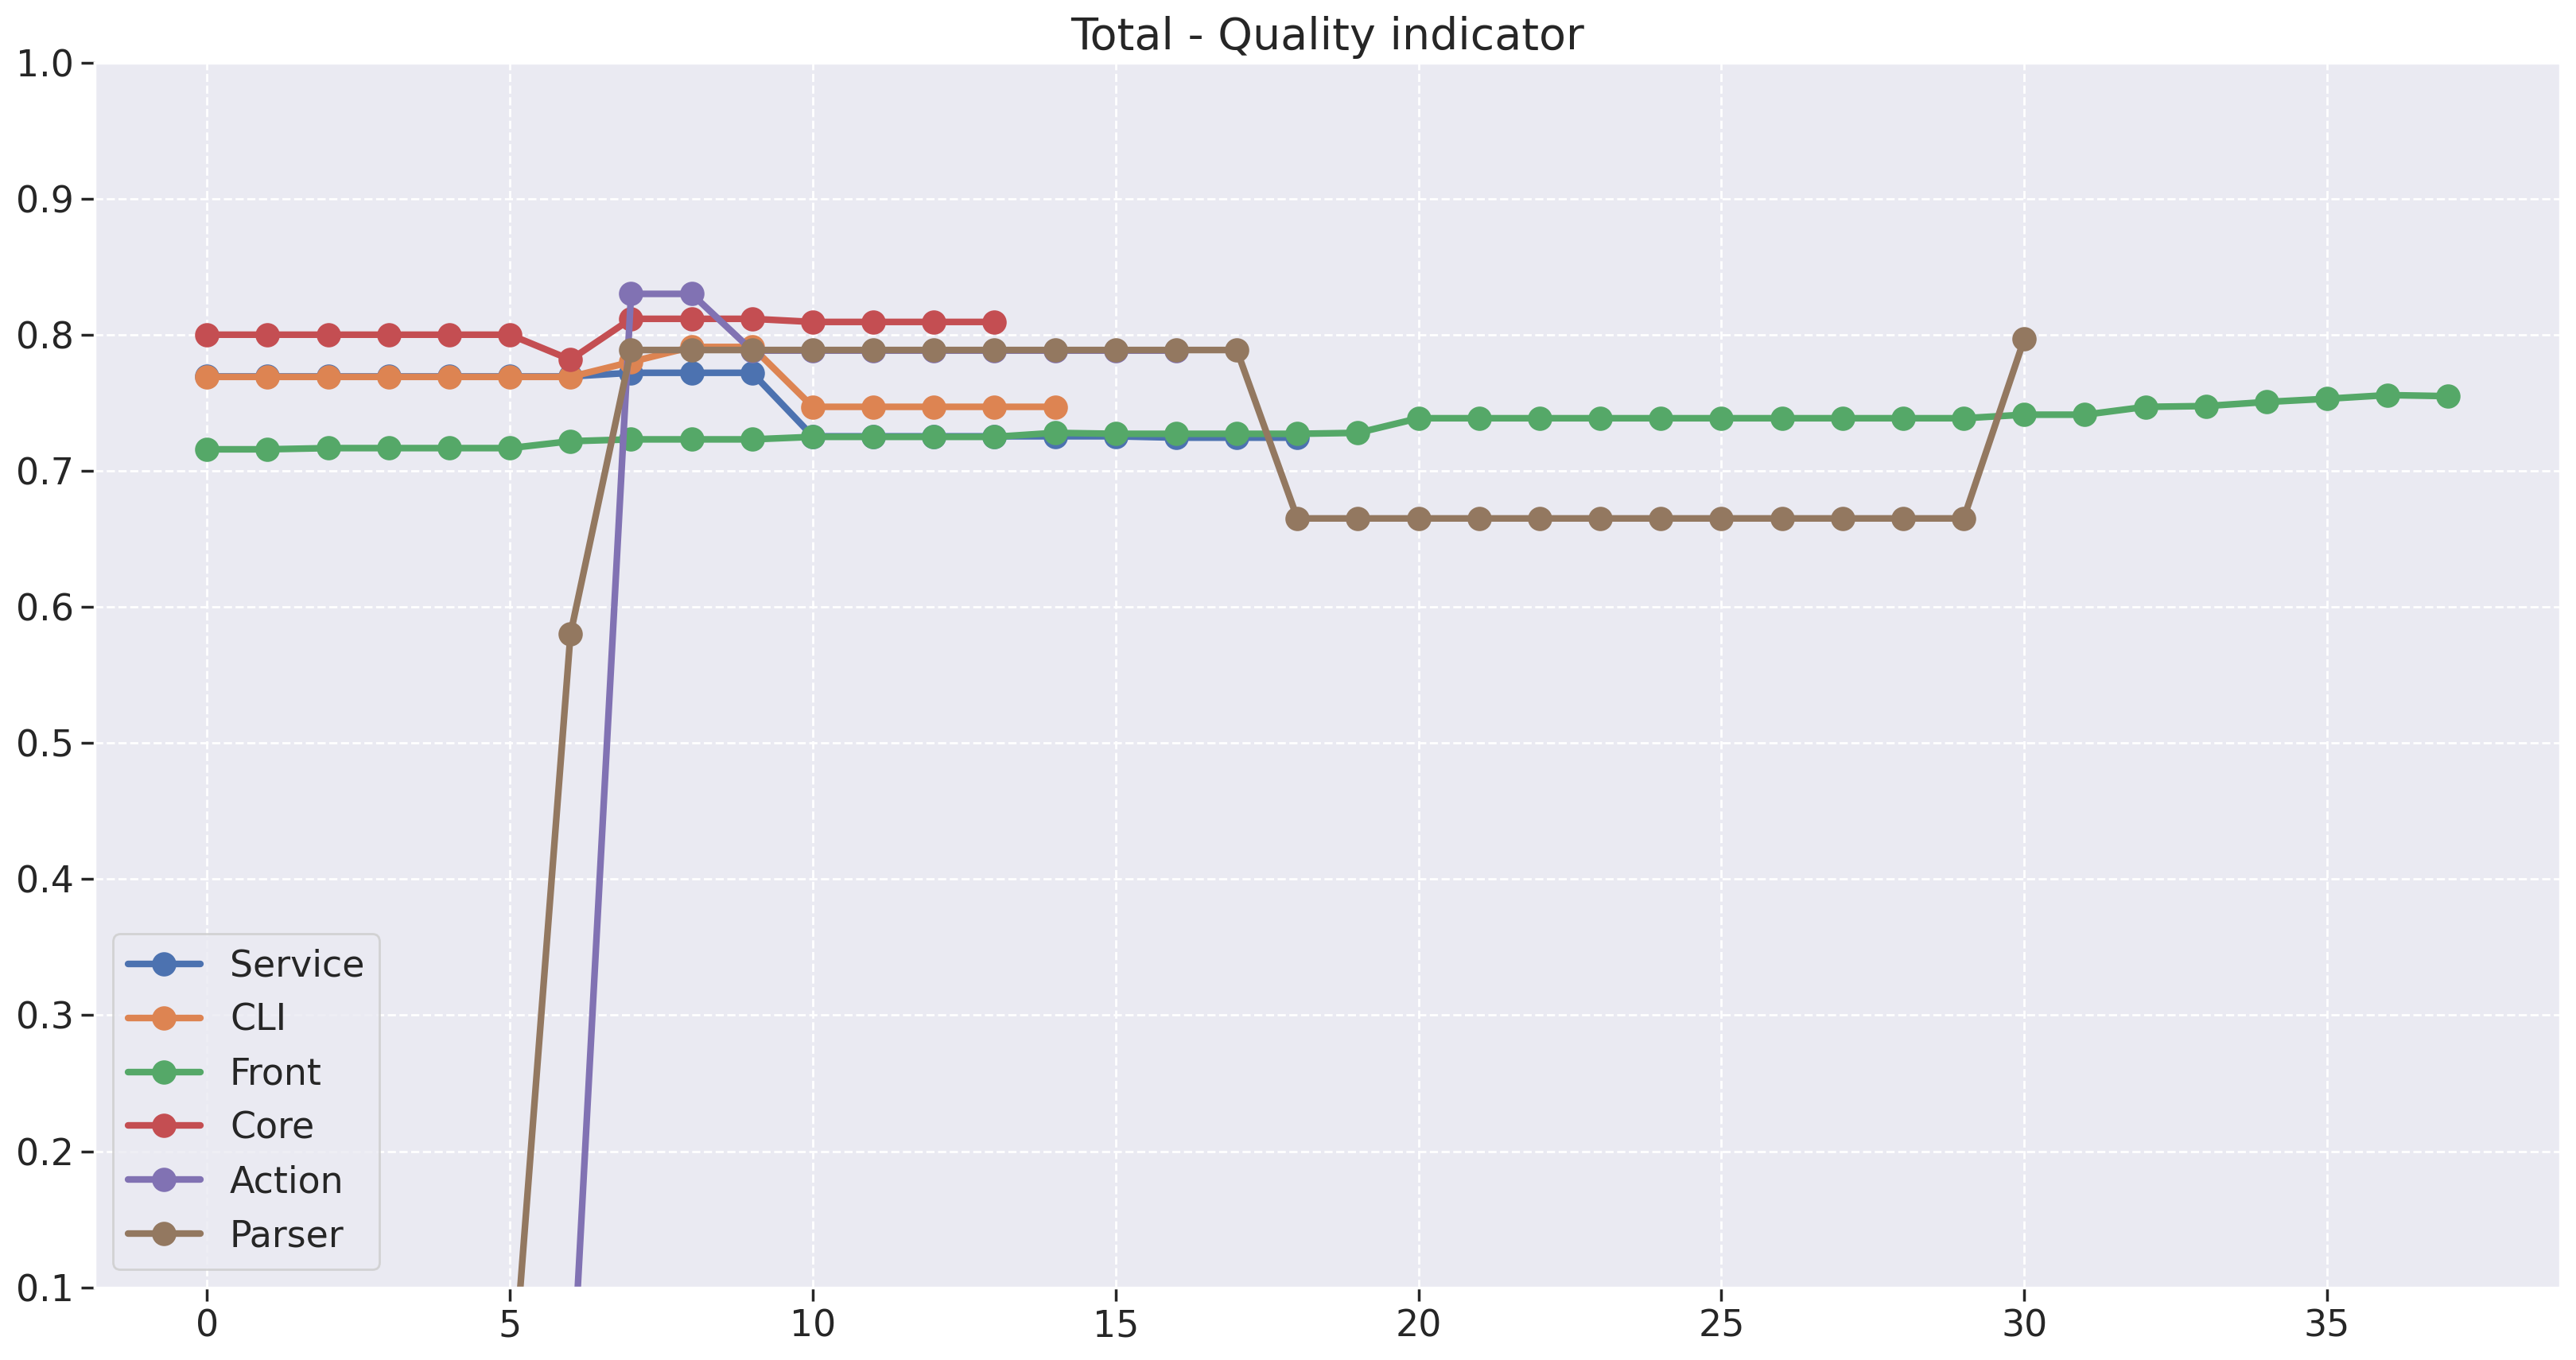

In [32]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

## Export data

In [33]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('./data/fga-eps-mds-2023-1-MeasureSoftGram--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('./data/fga-eps-mds-2023-1-MeasureSoftGram--{}.csv'.format(current_datetime), index = False)

m1        m2        m3   m4   m5        m6  \
0    0.511628  0.279070  1.000000  1.0  1.0  0.895349   
1    0.511628  0.279070  1.000000  1.0  1.0  0.895349   
2    0.511628  0.279070  1.000000  1.0  1.0  0.895349   
3    0.511628  0.279070  1.000000  1.0  1.0  0.895349   
4    0.511628  0.279070  1.000000  1.0  1.0  0.895349   
5    0.511628  0.279070  1.000000  1.0  1.0  0.895349   
6    0.511628  0.279070  1.000000  1.0  1.0  0.895349   
7    0.533333  0.266667  1.000000  1.0  1.0  0.900000   
8    0.533333  0.266667  1.000000  1.0  1.0  0.900000   
9    0.533333  0.266667  1.000000  1.0  1.0  0.900000   
10   0.316667  0.150000  1.000000  1.0  1.0  0.933333   
11   0.316667  0.150000  1.000000  1.0  1.0  0.933333   
12   0.316667  0.150000  1.000000  1.0  1.0  0.933333   
13   0.316667  0.150000  1.000000  1.0  1.0  0.933333   
14   0.316667  0.150000  1.000000  1.0  1.0  0.933333   
15   0.316667  0.150000  1.000000  1.0  1.0  0.933333   
16   0.311475  0.147541  1.000000  1.0  1.0  0.934426   
17   0.311475  0.147541  1.000000  1.0  1.0  0.934426   
18   0.311475  0.147541  1.000000  1.0  1.0  0.934426   
19   0.866667  0.066667  1.000000  1.0  1.0  0.800000   
20   0.866667  0.066667  1.000000  1.0  1.0  0.800000   
21   0.866667  0.066667  1.000000  1.0  1.0  0.800000   
22   0.866667  0.066667  1.000000  1.0  1.0  0.800000   
23   0.866667  0.066667  1.000000  1.0  1.0  0.800000   
24   0.866667  0.066667  1.000000  1.0  1.0  0.800000   
25   0.866667  0.066667  1.000000  1.0  1.0  0.800000   
26   0.866667  0.133333  1.000000  1.0  1.0  0.800000   
27   0.866667  0.200000  1.000000  1.0  1.0  0.800000   
28   0.866667  0.200000  1.000000  1.0  1.0  0.800000   
29   0.600000  0.200000  1.000000  1.0  1.0  0.800000   
30   0.600000  0.200000  1.000000  1.0  1.0  0.800000   
31   0.600000  0.200000  1.000000  1.0  1.0  0.800000   
32   0.600000  0.200000  1.000000  1.0  1.0  0.800000   
33   0.600000  0.200000  1.000000  1.0  1.0  0.800000   
34   0.789062  0.007812  0.984375  1.0  1.0  0.687500   
35   0.789062  0.007812  0.984375  1.0  1.0  0.687500   
36   0.790698  0.007752  0.984496  1.0  1.0  0.689922   
37   0.790698  0.007752  0.984496  1.0  1.0  0.689922   
38   0.790698  0.007752  0.984496  1.0  1.0  0.689922   
39   0.790698  0.007752  0.984496  1.0  1.0  0.689922   
40   0.795455  0.022727  0.984848  1.0  1.0  0.696970   
41   0.801471  0.022059  0.985294  1.0  1.0  0.698529   
42   0.801471  0.022059  0.985294  1.0  1.0  0.698529   
43   0.801471  0.022059  0.985294  1.0  1.0  0.698529   
44   0.801471  0.022059  0.985294  1.0  1.0  0.705882   
45   0.801471  0.022059  0.985294  1.0  1.0  0.705882   
46   0.801471  0.022059  0.985294  1.0  1.0  0.705882   
47   0.801471  0.022059  0.985294  1.0  1.0  0.705882   
48   0.812500  0.013889  0.986111  1.0  1.0  0.715278   
49   0.811189  0.013986  0.986014  1.0  1.0  0.713287   
50   0.811189  0.013986  0.986014  1.0  1.0  0.713287   
51   0.811189  0.013986  0.986014  1.0  1.0  0.713287   
52   0.811189  0.013986  0.986014  1.0  1.0  0.713287   
53   0.812500  0.013889  0.986111  1.0  1.0  0.715278   
54   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
55   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
56   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
57   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
58   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
59   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
60   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
61   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
62   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
63   0.830769  0.015385  0.984615  1.0  1.0  0.746154   
64   0.832061  0.015267  0.984733  1.0  1.0  0.755725   
65   0.832061  0.015267  0.984733  1.0  1.0  0.755725   
66   0.812950  0.014388  0.985612  1.0  1.0  0.791367   
67   0.814286  0.014286  0.985714  1.0  1.0  0.792857   
68   0.812950  0.014388  0.985612  1.0  1.0  0.805755   
69   0.814286  0.0142

## Análise de qualidade

A partir do gráfico final de qualidade é possível perceber que o nível de qualidade dos repositórios até o momento parece seguir com o mesmo nível de qualidade já estabelecido do semestre anterior. Isso demonstra que os limites mínimos de qualidade exigidos pela pipeline estão ajudando a manter um certo nível de qualidade de código do produto.

### Front
O front atualmente é o único repositório que está com a cobertura de testes abaixo de 80%. Atualmente é 58.3%, apesar de que é possível ver uma melhoria na cobertura, ainda existe a necessidade de priorizar essa cobertura de testes.

Fora isso, atualmente o sonar cloud reporta a existência de 25 bugs que foram introduzidos recentemente no repositório. E que também devem ser priorizados.

### Action

De acordo com o gráfico de qualidade, este repositório começou com um nível de qualidade acima dos outros repositórios. Mas o time deve ficar atento para que a qualidade de código do produto não diminua com o tempo.

### Service

Possui 7,8% de código duplicado, enquanto todos os outros repositórios possuem quase 0%.

## Parser

O projeto do parser, por mais que tenhamos um projeto novo, conseguimos manter um repositorio com as metricas de qualidade em um nivel aceitavel, com isso, podemos dizer que o projeto esta indo bem, e que o time esta conseguindo manter a qualidade do codigo comparado com os outros repositorios.